## 线性回归

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
# 创建示例数据集
data = {
    "0": [2, 3, 4, 5, 6],
    "X": [1, 2, 3, 4, 5],
    "1": [5, 4, 3, 2, 1],
    "2": [1, 2, 3, 4, 5],
    "Y": [3, 4, 2, 5, 6]
}

# 将数据集转换为 DataFrame
dataset = pd.DataFrame(data)

def Squared_term(dataset, variables):
    for var in variables:
        dataset[f'{var}_squared_term'] = dataset[var] ** 2
    return dataset

def Interaction_term(dataset, variables):
    for i in range(len(variables)):
        for j in range(i + 1, len(variables)):
            dataset[f'{variables[i]}_{variables[j]}'] = dataset[variables[i]] * dataset[variables[j]]
    return dataset

In [3]:
variables = dataset.columns.drop(["X", "Y"]).tolist()
model1_features = ["X"] + variables
d1 = Squared_term(dataset[model1_features], variables)
d1 = Interaction_term(d1, variables)
model1_features = ["X"] + variables + [f'{var}_squared_term' for var in variables]
print(model1_features)
model1_features = d1.columns.tolist()
print(model1_features)

['X', '0', '1', '2', '0_squared_term', '1_squared_term', '2_squared_term']
['X', '0', '1', '2', '0_squared_term', '1_squared_term', '2_squared_term', '0_1', '0_2', '1_2']


In [4]:
scaler = StandardScaler()
d1_scaled = scaler.fit_transform(d1)
model1 = LinearRegression().fit(d1_scaled, dataset[["Y"]])
model1_coefs = model1.coef_[0].tolist()
model1_dict = {name: coef for name, coef in zip(model1_features, model1_coefs)}
print(model1_dict)

{'X': 0.08959372776926722, '0': 0.08959372776926722, '1': -0.0895937277692671, '2': 0.0895937277692671, '0_squared_term': 0.13368279918203282, '1_squared_term': -0.028323816801206637, '2_squared_term': 0.1474778756831382, '0_1': -0.2930171810439319, '0_2': 0.13966211127148917, '1_2': -0.3079290260806433}


In [4]:
# 将 X 放到第一列
variables.remove("X")
variables = ["X"] + variables

In [5]:
model = LinearRegression().fit(dataset[variables], dataset[["Y"]])
coefs = model.coef_[0].tolist()
names = model.feature_names_in_.tolist()
variables.remove("X")

In [6]:
df = []
for i, variable in enumerate(variables):
    for j, name in enumerate(names):
        if variable == name:
            df.append({
                "variable": variable,
                "v~Y_coefficient": coefs[j],
            })
    
df = pd.DataFrame(df)
df
# df["dataset"] = dataset.name

,variable,v~Y_coefficient
0,0,0.233333
1,1,-0.233333


In [7]:
df["X~Y_coefficient"] = coefs[0]

# # Reorder columns:
# df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

In [8]:
df

,variable,v~Y_coefficient,X~Y_coefficient
0,0,0.233333,0.233333
1,1,-0.233333,0.233333


## 岭回归

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import crunch
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>


In [3]:
X_train, y_train, X_test = crunch.load_data()

download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exists: file length match


In [4]:
def ridge_regression_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()
    param_grid = {'alpha': np.logspace(-6, 6, 13)}
    
    # model1: Fit X, v ~ Y
    model1_features = ["X"] + variables
    scaler1 = StandardScaler()
    d1_scaled = scaler1.fit_transform(dataset[model1_features])
    model1 = GridSearchCV(Ridge(random_state=42), param_grid, cv=5)
    model1.fit(d1_scaled, dataset["Y"])
    model1_coefs = model1.best_estimator_.coef_.tolist()
    model1_dict = {name: coef for name, coef in zip(model1_features, model1_coefs)}
    
    # model2: Fit v ~ X
    model2_features = variables
    scaler2 = StandardScaler()
    d2_scaled = scaler2.fit_transform(dataset[model2_features])
    model2 = GridSearchCV(Ridge(random_state=42), param_grid, cv=5)
    model2.fit(d2_scaled, dataset["X"])
    model2_coefs = model2.best_estimator_.coef_.tolist()
    model2_dict = {name: coef for name, coef in zip(model2_features, model2_coefs)}
    
    df = []
    for i, variable in enumerate(variables):
        df.append({
            "variable": variable,
            "v~Y_ridge_coefficient": model1_dict[variable],
            "v~X_ridge_coefficient": model2_dict[variable]
        })
        
    df = pd.DataFrame(df)
    # df["dataset"] = dataset.name
    
    df["X~Y_ridge_coefficient"] = model1_dict["X"]
    
    # Reorder columns:
    # df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    # 获取最优的 alpha 值
    best_alpha_model1 = model1.best_params_['alpha']
    best_alpha_model2 = model2.best_params_['alpha']

    return df, best_alpha_model1, best_alpha_model2

In [5]:
alpha_model1 = []
alpha_model2 = []
from tqdm import tqdm
count = 0

for key, df in tqdm(X_train.items(), total=len(X_train), desc="Processing datasets"):
    df, best_alpha_model1, best_alpha_model2 = ridge_regression_feature(df)
    alpha_model1.append(best_alpha_model1)
    alpha_model2.append(best_alpha_model2)
    count+=1
    if count == 2000:
        break

Processing datasets:   9%|▊         | 1999/23500 [06:01<1:04:48,  5.53it/s]


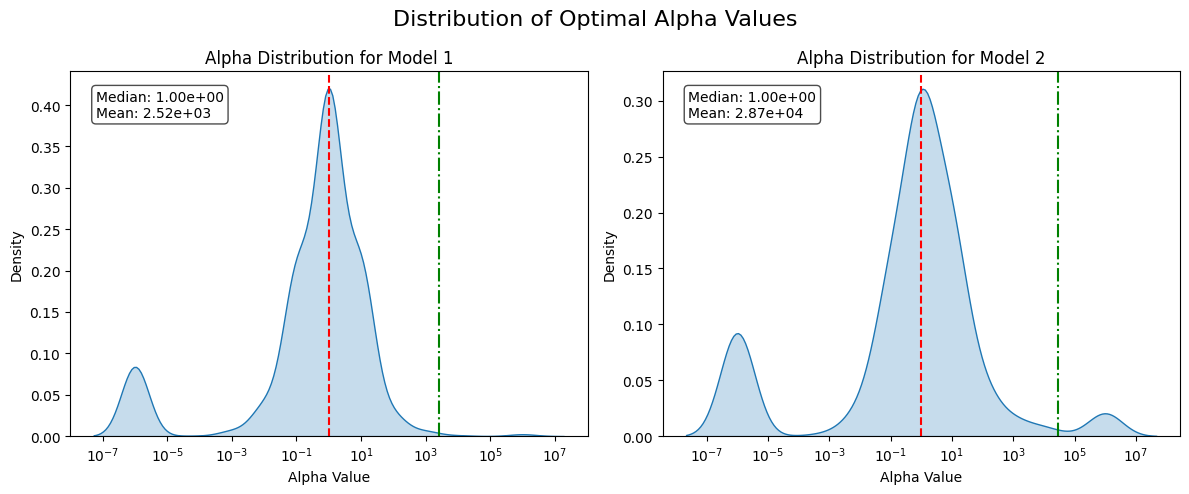

In [6]:
def plot_alpha_distributions(alpha_model1, alpha_model2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Distribution of Optimal Alpha Values', fontsize=16)

    for ax, data, title in zip([ax1, ax2], [alpha_model1, alpha_model2], ['Model 1', 'Model 2']):
        sns.kdeplot(data, ax=ax, log_scale=True, fill=True)
        ax.set_title(f'Alpha Distribution for {title}')
        ax.set_xlabel('Alpha Value')
        ax.set_ylabel('Density')

        # 添加统计信息
        median = np.median(data)
        mean = np.mean(data)
        ax.axvline(median, color='r', linestyle='--', label=f'Median: {median:.2e}')
        ax.axvline(mean, color='g', linestyle='-.', label=f'Mean: {mean:.2e}')
        
        # 添加文本注释
        ax.text(0.05, 0.95, f'Median: {median:.2e}\nMean: {mean:.2e}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

# 调用函数
plot_alpha_distributions(alpha_model1, alpha_model2)

## 聚类特征

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd

In [2]:
def enhanced_cluster_features(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()
    scaler = StandardScaler()
    d_scaled = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

    results = []
    eps_values = [0.3, 0.5, 0.7]
    
    for variable in variables:
        cluster_counts = []
        noise_counts = []
        avg_cluster_sizes = []
        density_variations = []
        feature_importances = []
        silhouette_scores = []
        
        for eps in eps_values:
            cluster_df = d_scaled[[variable, "X", "Y"]].copy()
            dbscan = DBSCAN(eps=eps, min_samples=5)
            cluster_df["cluster"] = dbscan.fit_predict(cluster_df)
            
            # 基本统计
            cluster_count = len(set(cluster_df["cluster"])) - (1 if -1 in cluster_df["cluster"] else 0)
            noise_count = (cluster_df["cluster"] == -1).sum()
            cluster_counts.append(cluster_count)
            noise_counts.append(noise_count)
            
            # 密度分析
            cluster_sizes = cluster_df[cluster_df["cluster"] != -1]["cluster"].value_counts()
            avg_cluster_size = cluster_sizes.mean() if not cluster_sizes.empty else 0
            density_variation = cluster_sizes.std() / avg_cluster_size if avg_cluster_size > 0 else 0
            avg_cluster_sizes.append(avg_cluster_size)
            density_variations.append(density_variation)
            
            # 特征重要性
            if cluster_count > 1:  # 确保有多个簇
                feature_importance = abs(np.corrcoef(cluster_df[variable], cluster_df["cluster"]))[0, 1]
            else:
                feature_importance = 0
            feature_importances.append(feature_importance)
            
            # 轮廓系数
            non_noise_mask = cluster_df["cluster"] != -1
            if len(set(cluster_df.loc[non_noise_mask, "cluster"])) > 1:
                sil_score = silhouette_score(cluster_df.loc[non_noise_mask, [variable, "X", "Y"]], 
                                             cluster_df.loc[non_noise_mask, "cluster"], 
                                             metric="euclidean")
            else:
                sil_score = 0
            silhouette_scores.append(sil_score)
        
        result = {
            "variable": variable
        }
        for i, eps in enumerate(eps_values):
            result.update({
                f"cluster_count_{eps}": cluster_counts[i],
                f"noise_count_{eps}": noise_counts[i],
                f"avg_cluster_size_{eps}": avg_cluster_sizes[i],
                f"density_variation_{eps}": density_variations[i],
                f"feature_importance_{eps}": feature_importances[i],
                f"silhouette_score_{eps}": silhouette_scores[i]
            })
        results.append(result)

    df = pd.DataFrame(results)
    # df["dataset"] = dataset.name

    # # Reorder columns:
    # df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

In [3]:
# 创建示例数据集
data = {
    "0": [2, 3, 4, 5, 6],
    "X": [1, 2, 3, 4, 5],
    "1": [5, 4, 3, 2, 1],
    "2": [1, 2, 3, 4, 5],
    "Y": [3, 4, 2, 5, 6]
}

# 将数据集转换为 DataFrame
dataset = pd.DataFrame(data)
print(dataset)

   0  X  1  2  Y
0  2  1  5  1  3
1  3  2  4  2  4
2  4  3  3  3  2
3  5  4  2  4  5
4  6  5  1  5  6


In [4]:
df = enhanced_cluster_features(dataset)
print(df)

  variable  cluster_count_0.3  noise_count_0.3  avg_cluster_size_0.3  \
0        0                  1                5                     0   
1        1                  1                5                     0   
2        2                  1                5                     0   

   density_variation_0.3  feature_importance_0.3  silhouette_score_0.3  \
0                      0                       0                     0   
1                      0                       0                     0   
2                      0                       0                     0   

   cluster_count_0.5  noise_count_0.5  avg_cluster_size_0.5  \
0                  1                5                     0   
1                  1                5                     0   
2                  1                5                     0   

   density_variation_0.5  feature_importance_0.5  silhouette_score_0.5  \
0                      0                       0                     0   
1            

## PC

In [1]:
import numpy as np
import pandas as pd
from pgmpy.estimators import PC
from pgmpy.independencies import Independencies

In [2]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [3]:
# 数据预处理函数
def preprocess_data(data):
    # 确保数据是浮点型
    data = data.astype(float)
    # 替换无穷大值为NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 删除包含NaN的行
    data.dropna(inplace=True)
    return data

def discretize_dataframe(df, n_bins=5, strategy='uniform', labels=None):
    """
    将数据框中的所有连续变量离散化为分箱后的离散变量。

    参数:
    df (pandas.DataFrame): 输入的数据框
    n_bins (int 或 dict): 分箱数量。可以是整数（对所有列使用相同的分箱数），
                          或者是字典（为每列指定不同的分箱数）
    strategy (str 或 dict): 分箱策略，可选 'uniform'（等宽）, 'quantile'（等频）或 'kmeans'
                            可以是字符串（对所有列使用相同的策略），
                            或者是字典（为每列指定不同的策略）
    labels (bool 或 dict): 是否用标签替换分箱的整数。True 使用标签，False 使用整数。
                           可以是布尔值（对所有列使用相同的设置），
                           或者是字典（为每列指定不同的设置）

    返回:
    pandas.DataFrame: 离散化后的数据框
    """
    df_discretized = df.copy()
    
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            # 获取当前列的参数
            col_bins = n_bins[column] if isinstance(n_bins, dict) else n_bins
            col_strategy = strategy[column] if isinstance(strategy, dict) else strategy
            col_labels = labels[column] if isinstance(labels, dict) else labels
            
            # 处理特殊情况：如果列中的唯一值少于分箱数，就直接使用这些唯一值
            unique_values = df[column].nunique()
            if unique_values <= col_bins:
                df_discretized[column] = pd.Categorical(df[column])
            else:
                # 执行离散化
                if col_strategy == 'uniform':
                    df_discretized[column] = pd.cut(df[column], bins=col_bins, labels=col_labels)
                elif col_strategy == 'quantile':
                    df_discretized[column] = pd.qcut(df[column], q=col_bins, labels=col_labels)
                elif col_strategy == 'kmeans':
                    from sklearn.preprocessing import KBinsDiscretizer
                    kbd = KBinsDiscretizer(n_bins=col_bins, encode='ordinal', strategy='kmeans')
                    df_discretized[column] = kbd.fit_transform(df[[column]])
                    if col_labels:
                        df_discretized[column] = pd.Categorical(df_discretized[column])
                else:
                    raise ValueError(f"不支持的策略 '{col_strategy}' 用于列 '{column}'")
    
    return df_discretized

A = X_train['00016']
A = preprocess_data(A)
# A = discretize_dataframe(A, n_bins=5, strategy='uniform', labels=[1, 2, 3, 4, 5])
B = y_train['00016']
print(A)
print(B)

         0      1      2      Y      4      X
0    0.023 -0.365  0.781  0.255  0.223 -0.367
1    0.177 -0.057 -0.333 -0.165 -0.625  0.759
2    0.393 -0.035 -0.879 -0.565 -0.065  0.243
3   -0.501  0.211 -0.273 -0.377 -0.551  0.345
4    0.119  0.849  0.727 -0.737  0.343 -0.165
..     ...    ...    ...    ...    ...    ...
995 -0.487 -0.805  0.001  0.767  0.357 -0.617
996 -0.521 -0.913 -0.215 -0.031  0.931 -0.929
997 -0.585  0.441 -0.189 -0.581 -0.357  0.449
998 -0.857 -0.643  0.191  0.495  0.405 -0.707
999  0.301  0.659  0.441 -0.489  0.035 -0.005

[1000 rows x 6 columns]
        0  1  2  Y  4  X
parent                  
0       0  0  0  0  0  0
1       0  0  0  1  0  0
2       1  0  0  1  0  0
Y       1  0  0  0  0  0
4       1  1  0  1  0  1
X       1  0  0  1  0  0


In [4]:
# 使用estimate方法学习DAG结构
est = PC(A)
estimated_model = est.estimate(
    variant='parallel',
    ci_test='pearsonr',
    max_cond_vars=3,  # 减少最大条件变量数
    return_type='dag',
    significance_level=0.05,
    n_jobs=-1,  # 使用所有可用的CPU核心
)

# 打印估计的边
print("Estimated edges:")
print(estimated_model.edges())

# 将估计的模型转换为邻接矩阵格式
adj_matrix = np.zeros((6, 6), dtype=int)
for edge in estimated_model.edges():
    i = A.columns.get_loc(edge[0])
    j = A.columns.get_loc(edge[1])
    adj_matrix[i, j] = 1

print("\nEstimated adjacency matrix:")
print(adj_matrix)

# 比较估计的结构与真实结构
true_adj_matrix = y_train['00016'].values

print("\nTrue adjacency matrix:")
print(true_adj_matrix)

# 计算结构学习的准确度
accuracy = np.mean(adj_matrix == true_adj_matrix)
print(f"\nStructure learning accuracy: {accuracy:.2f}")

  0%|          | 0/3 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


Estimated edges:
[('X', '0'), ('4', '1'), ('4', '0'), ('4', 'X'), ('2', 'Y')]

Estimated adjacency matrix:
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [1 1 0 0 0 1]
 [1 0 0 0 0 0]]

True adjacency matrix:
[[0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 1 0 1 0 1]
 [1 0 0 1 0 0]]

Structure learning accuracy: 0.86


In [7]:
import pandas as pd
import numpy as np
from pgmpy.estimators import PC
from tqdm import tqdm

def classify_relationship(edges):
    edge_set = set(edges)
    if ('X', 'Y') not in edge_set:
        return "Invalid (X->Y not found)"
    if (('v', 'X') in edge_set or ('X', 'v') in edge_set) and (('v', 'Y') in edge_set or ('Y', 'v') in edge_set):
        return "Mediator or Confounder"
    if ('X', 'v') in edge_set and ('Y', 'v') in edge_set:
        return "Collider"
    if ('v', 'X') in edge_set:
        return "Cause of X"
    if ('v', 'Y') in edge_set:
        return "Cause of Y"
    if ('X', 'v') in edge_set:
        return "Consequence of X"
    if ('Y', 'v') in edge_set:
        return "Consequence of Y"
    return "Independent"

def print_adjacency_matrix(edges, variables):
    adj_matrix = np.zeros((len(variables), len(variables)), dtype=int)
    for i, v1 in enumerate(variables):
        for j, v2 in enumerate(variables):
            if (v1, v2) in edges:
                adj_matrix[i, j] = 1
    print(pd.DataFrame(adj_matrix, index=variables, columns=variables))

variables = A.columns.drop(["X", "Y"]).tolist()
results = {}
true_relationships = {}

for variable in tqdm(variables, desc="Analyzing variables"):
    # 使用estimate方法学习DAG结构
    data = A[[variable, "X", "Y"]]
    est = PC(data)
    estimated_model = est.estimate(
        variant='parallel',
        ci_test='pearsonr',
        return_type='dag',
        significance_level=0.05,
        n_jobs=-1,
    )

    # 获取估计的边
    estimated_edges = estimated_model.edges()
    
    # 分类关系
    relationship = classify_relationship(estimated_edges)
    results[variable] = relationship

    # 获取真实关系
    true_adj_matrix = y_train['00016'].values
    true_edges = []
    if true_adj_matrix[A.columns.get_loc(variable), A.columns.get_loc("X")] == 1:
        true_edges.append((variable, "X"))
    if true_adj_matrix[A.columns.get_loc(variable), A.columns.get_loc("Y")] == 1:
        true_edges.append((variable, "Y"))
    if true_adj_matrix[A.columns.get_loc("X"), A.columns.get_loc("Y")] == 1:
        true_edges.append(("X", "Y"))
    true_relationship = classify_relationship(true_edges)
    true_relationships[variable] = true_relationship

    # 打印结果和邻接矩阵
    print(f"\nVariable: {variable}")
    print(f"Estimated relationship: {relationship}")
    print(f"True relationship: {true_relationship}")
    
    print("\nEstimated Adjacency Matrix:")
    print_adjacency_matrix(estimated_edges, [variable, "X", "Y"])
    
    print("\nTrue Adjacency Matrix:")
    print_adjacency_matrix(true_edges, [variable, "X", "Y"])

# 计算准确率
accuracy = sum(results[v] == true_relationships[v] for v in variables) / len(variables)
print(f"\nOverall accuracy: {accuracy:.2f}")

# 打印结果汇总
print("\nResults summary:")
for relationship in set(results.values()):
    count = list(results.values()).count(relationship)
    print(f"{relationship}: {count}")

Analyzing variables:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Analyzing variables:  25%|██▌       | 1/4 [00:00<00:00,  7.41it/s]


Variable: 0
Estimated relationship: Independent
True relationship: Independent

Estimated Adjacency Matrix:
   0  X  Y
0  0  1  1
X  0  0  1
Y  0  0  0

True Adjacency Matrix:
   0  X  Y
0  0  0  0
X  0  0  1
Y  0  0  0


  0%|          | 0/5 [00:00<?, ?it/s]

Analyzing variables:  50%|█████     | 2/4 [00:00<00:00,  8.12it/s]


Variable: 1
Estimated relationship: Independent
True relationship: Independent

Estimated Adjacency Matrix:
   1  X  Y
1  0  0  1
X  1  0  1
Y  0  0  0

True Adjacency Matrix:
   1  X  Y
1  0  0  1
X  0  0  1
Y  0  0  0


  0%|          | 0/5 [00:00<?, ?it/s]

Analyzing variables:  75%|███████▌  | 3/4 [00:00<00:00,  8.36it/s]


Variable: 2
Estimated relationship: Independent
True relationship: Independent

Estimated Adjacency Matrix:
   2  X  Y
2  0  0  1
X  0  0  1
Y  0  0  0

True Adjacency Matrix:
   2  X  Y
2  0  0  1
X  0  0  1
Y  0  0  0


  0%|          | 0/5 [00:00<?, ?it/s]


Variable: 4

Analyzing variables: 100%|██████████| 4/4 [00:00<00:00,  8.71it/s]


Estimated relationship: Invalid (X->Y not found)
True relationship: Independent

Estimated Adjacency Matrix:
   4  X  Y
4  0  0  1
X  1  0  0
Y  0  0  0

True Adjacency Matrix:
   4  X  Y
4  0  1  1
X  0  0  1
Y  0  0  0

Overall accuracy: 0.75

Results summary:
Independent: 3
Invalid (X->Y not found): 1


In [ ]:
from pgmpy.estimators import PC, HillClimbSearch
from pgmpy.models import BayesianNetwork
import pandas as pd
import numpy as np

# 假设数据已经准备好，存储在DataFrame中
data = pd.DataFrame(np.random.rand(1000, 3), columns=['v', 'X', 'Y'])

# 使用PC算法
pc = PC(data)
pc_graph = pc.estimate(variant='stable')
print("PC Algorithm Result:")
print(pc_graph.edges())

# 使用Hill-Climb搜索
hc = HillClimbSearch(data)
hc_model = hc.estimate()
print("\nHill-Climb Search Result:")
print(hc_model.edges())

# 将结果映射到预定义的关系类型
def map_to_relationship(edges):
    if ('X', 'Y') not in edges:
        return "Invalid (X->Y not found)"
    if ('v', 'X') in edges and ('v', 'Y') in edges:
        return "Confounder"
    if ('X', 'v') in edges and ('Y', 'v') in edges:
        return "Collider"
    # ... 添加其他关系类型的判断
    return "Unknown"

print("\nInferred Relationship (PC):", map_to_relationship(pc_graph.edges()))
print("Inferred Relationship (HC):", map_to_relationship(hc_model.edges()))

## PC-0926

In [1]:
import numpy as np
import pandas as pd
from pgmpy.estimators import PC
from pgmpy.independencies import Independencies

In [2]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [3]:
def preprocess_data(data):
    # 确保数据是浮点型
    data = data.astype(float)
    # 替换无穷大值为NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 删除包含NaN的行
    data.dropna(inplace=True)
    return data

In [4]:
def PC_estimate(dataset, mcv, significance, isprint):
    dim = dataset.shape[1]
    if mcv == 'dim-1':
        mcv = dim - 1
    else:
        mcv = int(mcv)

    # 使用estimate方法学习DAG结构
    est = PC(dataset)
    estimated_model = est.estimate(
        variant='parallel',
        ci_test='pearsonr',
        max_cond_vars=mcv,  # 减少最大条件变量数
        return_type='dag',
        significance_level=significance,
        n_jobs=-1,  # 使用所有可用的CPU核心
    )

    # 打印估计的边
    if isprint:
        print("Estimated edges:")
        print(estimated_model.edges())

    # 将估计的模型转换为邻接矩阵格式
    adj_matrix = np.zeros((dim, dim), dtype=int)
    for edge in estimated_model.edges():
        i = dataset.columns.get_loc(edge[0])
        j = dataset.columns.get_loc(edge[1])
        adj_matrix[i, j] = 1

    # 打印估计的邻接矩阵
    if isprint:
        print("\nEstimated adjacency matrix:")
        print(adj_matrix)

    return adj_matrix

In [44]:
A = X_train['00016']
A = preprocess_data(A)
# A = discretize_dataframe(A, n_bins=5, strategy='uniform', labels=[1, 2, 3, 4, 5])
B = y_train['00016']
print(A.columns)
print(B)

adj_matrix = PC_estimate(A, 4, 0.1, True)
adj_df = pd.DataFrame(adj_matrix, index=A.columns, columns=A.columns)
print(adj_df)

# 比较估计的结构与真实结构
true_adj_matrix = B.values

print("\nTrue adjacency matrix:")
print(true_adj_matrix)

# 计算结构学习的准确度
accuracy = np.mean(adj_matrix == true_adj_matrix)
print(f"\nStructure learning accuracy: {accuracy:.2f}")

Index(['0', '1', '2', 'Y', '4', 'X'], dtype='object')
        0  1  2  Y  4  X
parent                  
0       0  0  0  0  0  0
1       0  0  0  1  0  0
2       1  0  0  1  0  0
Y       1  0  0  0  0  0
4       1  1  0  1  0  1
X       1  0  0  1  0  0


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


Estimated edges:
[('X', '0'), ('0', 'Y'), ('2', 'Y'), ('2', '0'), ('4', 'X')]

Estimated adjacency matrix:
[[0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [1 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]]
   0  1  2  Y  4  X
0  0  0  0  1  0  0
1  0  0  0  0  0  0
2  1  0  0  1  0  0
Y  0  0  0  0  0  0
4  0  0  0  0  0  1
X  1  0  0  0  0  0

True adjacency matrix:
[[0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 1 0 0]
 [1 0 0 0 0 0]
 [1 1 0 1 0 1]
 [1 0 0 1 0 0]]

Structure learning accuracy: 0.81


In [9]:
A = X_train['00018']
A = preprocess_data(A)
# A = discretize_dataframe(A, n_bins=5, strategy='uniform', labels=[1, 2, 3, 4, 5])
B = y_train['00018']
print(A.shape)

adj_matrix = PC_estimate(A, 3, 0.05, True)

# 比较估计的结构与真实结构
true_adj_matrix = B.values

print("\nTrue adjacency matrix:")
print(true_adj_matrix)

# 计算结构学习的准确度
accuracy = np.mean(adj_matrix == true_adj_matrix)
print(f"\nStructure learning accuracy: {accuracy:.2f}")

(1000, 9)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


Estimated edges:
[('4', '6'), ('5', 'Y'), ('Y', '4'), ('7', '6'), ('7', 'Y'), ('X', '5'), ('3', 'X')]

Estimated adjacency matrix:
[[0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1]
 [0 0 0 0 1 0 0 0 0]]

True adjacency matrix:
[[0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]]

Structure learning accuracy: 0.85


In [25]:
A = X_train['00024']
A = preprocess_data(A)
# A = discretize_dataframe(A, n_bins=5, strategy='uniform', labels=[1, 2, 3, 4, 5])
B = y_train['00024']
print(A.shape)

adj_matrix = PC_estimate(A, '3')

# 比较估计的结构与真实结构
true_adj_matrix = B.values

print("\nTrue adjacency matrix:")
print(true_adj_matrix)

# 计算结构学习的准确度
accuracy = np.mean(adj_matrix == true_adj_matrix)
print(f"\nStructure learning accuracy: {accuracy:.2f}")

(1000, 8)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


Estimated edges:
[('6', '3'), ('5', '3'), ('0', '3'), ('Y', '3'), ('Y', '6'), ('X', 'Y'), ('7', '5'), ('1', '0')]

Estimated adjacency matrix:
[[0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]]

True adjacency matrix:
[[0 0 0 1 0 0 1 0]
 [1 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]]

Structure learning accuracy: 0.94


In [ ]:
def PC_feature(dataset):
    variables = dataset.columns.drop(["X", "Y"]).tolist()

    results = []     # 用于存储每个变量的特征
    PC_result = {}   # 存储不同显著性水平下的PC算法结果
    significance = [0.01, 0.05, 0.1]  # 显著性水平列表
    
    for sig in significance:
        adj_matrix = PC_estimate(dataset, 3, sig, False)
        adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
        PC_result[sig] = adj_df

    df = []
    for variable in variables:
        result = {
            "variable": variable
        }
        for sig in significance:
            adj_df = PC_result[sig]

            # 检查变量与'X'和'Y'之间的边
            v_to_X = adj_df.loc[variable, 'X']
            X_to_v = adj_df.loc['X', variable]
            v_to_Y = adj_df.loc[variable, 'Y']
            Y_to_v = adj_df.loc['Y', variable]

            # 将结果添加到特征字典中
            result.update({
                f"v~X_PC_{sig}": v_to_X,
                f"X~v_PC_{sig}": X_to_v,
                f"v~Y_PC_{sig}": v_to_Y,
                f"Y~v_PC_{sig}": Y_to_v
            })
        results.append(result)

    df = pd.DataFrame(results)
    df["dataset"] = dataset.name

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

In [ ]:
X_y_group_train_copy = X_y_group_train.copy()

In [ ]:
X_y_group_train = X_y_group_train_copy.copy()
print(X_y_group_train.shape)
X_y_group_train = X_y_group_train.drop(columns=[
     'v~X_PC_0.01', 'X~v_PC_0.01', 'v~Y_PC_0.01', 'Y~v_PC_0.01', 'X~Y_PC_0.01',
     # 'v~X_PC_0.05', 'X~v_PC_0.05', 'v~Y_PC_0.05', 'Y~v_PC_0.05', 'X~Y_PC_0.05', 
     # 'v~X_PC_0.1', 'X~v_PC_0.1', 'v~Y_PC_0.1', 'Y~v_PC_0.1', 'X~Y_PC_0.1'
])
print(X_y_group_train.shape)

## DML

In [1]:
import pandas as pd
import numpy as np

In [2]:
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')

A = X_train['00018']
print(A.columns)
B = y_train['00018']

Index(['X', '1', '2', '3', '4', '5', '6', '7', 'Y'], dtype='object')


In [9]:
from econml.dml import CausalForestDML, LinearDML
from sklearn.linear_model import LassoCV

# 设置处理变量、结果变量和控制变量
T_ = '1'
Y_ = 'X'
X_ = ['2', '3', '4', '5', '6', '7', 'Y']
data = A.copy()

T = data[T_].values
Y = data[Y_].values
X = data[X_].values

# # 定义 LassoCV 作为第一阶段模型
# model_t = LassoCV(random_state=42, n_jobs=None)
# model_y = LassoCV(random_state=42, n_jobs=None)

model_t = "forest"
model_y = "forest"

# 初始化 CausalForestDML 使用自定义的估计器
model = CausalForestDML(model_t=model_t, model_y=model_y,
    cv=4, n_estimators=36, n_jobs=None, random_state=42, inference=True)

# # 初始化 LinearDML 使用自定义的估计器
# model = LinearDML(model_t=model_t, model_y=model_y, cv=4, random_state=42)

model.fit(Y, T, X=X)

In [10]:
# 平均边际处理效应的推断结果
amte_inference = model.ate_inference(X=X)
print(amte_inference.summary())
print(amte_inference.mean_point)
print(amte_inference.pvalue())
print(amte_inference.std_point)
print(amte_inference.stderr_point)

               Uncertainty of Mean Point Estimate              
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     0.001        0.03 0.042  0.966        -0.058          0.06
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.019          -0.033           0.039
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.035         -0.069          0.073
------------------------------------------

Note: The stderr_mean is a conservative upper bound.
0.0012724049502857565
0.9663466719115306
0.018725126616904446
0.035498740393624


In [11]:
# 条件平均处理效应的推断结果
cate_inference = model.effect_inference(X=X)
print(cate_inference.summary_frame())

     point_estimate  stderr  zstat  pvalue  ci_lower  ci_upper
X                                                             
0             0.002   0.036  0.045   0.964    -0.068     0.071
1            -0.007   0.026 -0.278   0.781    -0.059     0.044
2            -0.017   0.029 -0.569   0.570    -0.074     0.041
3             0.008   0.038  0.210   0.833    -0.066     0.082
4            -0.005   0.029 -0.156   0.876    -0.062     0.053
..              ...     ...    ...     ...       ...       ...
995           0.000   0.019  0.010   0.992    -0.037     0.038
996          -0.001   0.032 -0.017   0.986    -0.063     0.062
997           0.031   0.028  1.115   0.265    -0.023     0.085
998           0.003   0.029  0.116   0.908    -0.054     0.060
999          -0.012   0.022 -0.532   0.595    -0.054     0.031

[1000 rows x 6 columns]


In [12]:
# 边际处理效果
mate_inference = model.marginal_ate_inference(T=T, X=X)
print(mate_inference.summary())

               Uncertainty of Mean Point Estimate              
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     0.001        0.03 0.042  0.966        -0.058          0.06
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.019          -0.033           0.039
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.035         -0.069          0.073
------------------------------------------

Note: The stderr_mean is a conservative upper bound.


In [13]:
# 常数边际处理效果
cmate_inference = model.const_marginal_ate_inference(X=X)
print(cmate_inference.summary())

               Uncertainty of Mean Point Estimate              
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     0.001        0.03 0.042  0.966        -0.058          0.06
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.019          -0.033           0.039
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.035         -0.069          0.073
------------------------------------------

Note: The stderr_mean is a conservative upper bound.


## Independence test

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [4]:
# Example usage
A = X_train['00000']
A = A.values
B = y_train['00000']
print(A)
print(B)
X = 8   # '8'
Y = 9   # 'X'
Z = [0, 2, 3, 4, 5, 6, 7]  # 不含'Y'

[[ 0.311 -0.365  0.327 ...  0.183  0.515  0.951]
 [ 0.125  0.657 -0.097 ...  0.711  0.591 -0.515]
 [ 0.499 -0.307 -0.395 ...  0.015  0.267  0.109]
 ...
 [ 0.795  0.409 -0.629 ...  0.355  0.941  0.363]
 [ 0.855 -0.721  0.193 ... -0.007 -0.329  0.715]
 [-0.851 -0.395 -0.925 ... -0.773 -0.691  0.001]]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0


In [5]:
from causallearn.utils.cit import CIT
# 使用高斯核，自动估计带宽
kci_gaussian = CIT(
    A, 
    "kci",
    kernelX='Gaussian', 
    kernelY='Gaussian', 
    kernelZ='Gaussian',
    est_width='empirical'
)

In [6]:
# 计算p值
pValue = kci_gaussian(X, Y, Z)
print("p-value:", pValue)

p-value: 0.0005533800093291408


In [7]:
from causallearn.utils.cit import CIT
# 使用多项式核，次数为3，常数项为1.0
kci_polynomial = CIT(
    A, 
    "kci",
    kernelX='Polynomial', 
    kernelY='Polynomial', 
    kernelZ='Polynomial',
    polyd=2,
    c=1.0
)

In [8]:
# 计算p值
pValue = kci_polynomial(X, Y, Z)
print("p-value:", pValue)

p-value: 0.00015758140856281244


In [9]:
from causallearn.utils.cit import CIT
# 使用线性核
kci_linear = CIT(
    A, 
    "kci",
    kernelX='Linear', 
    kernelY='Linear', 
    kernelZ='Linear'
)

In [10]:
# 计算p值
pValue = kci_linear(X, Y, Z)
print("p-value:", pValue)

p-value: 1.5863954662576063e-05


## Causal-learn

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
def handle_multicollinearity(data, epsilon=1e-7, corr_threshold=0.99):
    """
    检查数据中的多重共线性，并在需要时向存在多重共线性的列添加随机扰动。
    
    参数:
    - data (np.ndarray): 输入的数据矩阵，形状为 (样本数, 特征数)。
    - epsilon (float): 添加的随机扰动的尺度，默认值为1e-10。
    - corr_threshold (float): 判断高相关性的阈值，默认值为0.95。
    
    返回:
    - data (np.ndarray): 处理后的数据矩阵。
    """
    # 计算相关系数矩阵
    corr_matrix = np.corrcoef(data, rowvar=False)
    n_cols = corr_matrix.shape[0]

    # 使用集合存储所有涉及多重共线性的列索引，避免重复
    high_corr_indices = set()
    
    # 遍历相关系数矩阵的上三角部分，寻找高相关的列对
    for i in range(n_cols):
        for j in range(i+1, n_cols):
            if np.abs(corr_matrix[i, j]) > corr_threshold:
                high_corr_indices.add(i)
                high_corr_indices.add(j)
    
    if high_corr_indices:
        sorted_indices = sorted(high_corr_indices)
        # print(f"检测到多重共线性，涉及的列索引: {sorted_indices}。正在添加随机扰动...")
        
        # 生成与高相关性列对应的随机扰动
        noise = np.random.normal(0, epsilon, (data.shape[0], len(sorted_indices)))
        
        # 将扰动添加到相应的列
        data[:, sorted_indices] += noise
    
    return data

def convert_bidirectional_to_dag(bidirectional_adj: pd.DataFrame) -> pd.DataFrame:
    """
    将双向编码的邻接矩阵转换为单向编码的邻接矩阵（DAG表示）。
    
    在双向编码的邻接矩阵中：
    - [j, i] = 1 且 [i, j] = -1 表示 i → j
    - [j, i] = 1 且 [i, j] = 1 表示 i ↔ j（互为因果）
    - 其他情况 [i, j] = 0 表示无边
    
    转换后，单向编码的邻接矩阵将：
    - [i, j] = 1 表示 i → j
    - [i, j] = 1 且 [j, i] = 1 表示 i ↔ j
    - [i, j] = 0 表示无边
    
    参数:
    - bidirectional_adj (pd.DataFrame): 双向编码的邻接矩阵，使用 1 和 -1 表示有向边。
    
    返回:
    - pd.DataFrame: 单向编码的邻接矩阵（DAG表示）。
    """
    # 确保输入是一个方阵
    if bidirectional_adj.shape[0] != bidirectional_adj.shape[1]:
        raise ValueError("输入的邻接矩阵必须是方阵（行数等于列数）。")
    
    # 确保行列索引一致
    if not bidirectional_adj.index.equals(bidirectional_adj.columns):
        raise ValueError("邻接矩阵的行索引和列索引必须相同。")
    
    # 初始化一个全零的邻接矩阵
    single_direction_adj = pd.DataFrame(0, index=bidirectional_adj.index, columns=bidirectional_adj.columns)
    
    # 遍历每一对变量，确定有向边
    for source in bidirectional_adj.columns:
        for target in bidirectional_adj.index:
            if source == target:
                # 根据DAG定义，通常不允许自环，因此设置为0
                single_direction_adj.at[source, target] = 0
                continue
            
            # 检查双向编码的邻接矩阵来确定有向边
            if bidirectional_adj.at[target, source] == 1:
                if bidirectional_adj.at[source, target] == -1:
                    # 表示 source → target
                    single_direction_adj.at[source, target] = 1
                elif bidirectional_adj.at[source, target] == 1:
                    # 表示 source ↔ target（互为因果）
                    single_direction_adj.at[source, target] = 1
                    single_direction_adj.at[target, source] = 1
                # 如果 [source, target] == 0 或其他情况，不设置边
    return single_direction_adj

def convert_dag_with_strength_to_dag(adj: pd.DataFrame) -> pd.DataFrame:
    """
    将表示因果影响强度的邻接矩阵数据框转换为二元邻接矩阵数据框。
    无论存在正向影响还是负向影响，都将其转换为1；不存在影响则为0。
    
    参数:
    - adj (pd.DataFrame): 原始的因果影响强度邻接矩阵，元素可以是正数、负数或0。
    
    返回:
    - pd.DataFrame: 二元邻接矩阵，元素为0或1。
    """
    # 确保输入是一个方阵
    if adj.shape[0] != adj.shape[1]:
        raise ValueError("输入的邻接矩阵必须是方阵（行数等于列数）。")
    
    # 确保行列索引一致
    if not adj.index.equals(adj.columns):
        raise ValueError("邻接矩阵的行索引和列索引必须相同。")
    
    # 将所有非零元素转换为1，零元素保持为0
    return adj.ne(0).astype(int)

def has_directed_edge(adj, source, target):
    """
    判断DAG邻接矩阵中是否存在从source到target的有向边。
    根据用户的邻接矩阵表示：
    - [source, target] = 1 表示 source -> target
    """
    return adj.at[source, target] == 1

def evaluate_causal_discovery(estimate_adj, true_adj, focus_vars=['X', 'Y']):
    """
    评估因果发现算法的效果，关注变量与指定focus_vars（默认是'X'和'Y'）之间的连接正确率。
    
    参数:
    - estimate_adj (pd.DataFrame): 因果发现算法输出的邻接矩阵。
    - true_adj (pd.DataFrame): 真实的因果关系邻接矩阵。
    - focus_vars (list): 需要关注的变量列表，默认 ['X', 'Y']。
    
    返回:
    - dict: 包含正确率相关信息的字典。
    """
    
    # 1. 验证邻接矩阵的形状和索引/列名是否一致
    if not (estimate_adj.index.equals(true_adj.index) and estimate_adj.columns.equals(true_adj.columns)):
        raise ValueError("estimate_adj 和 true_adj 必须具有相同的行索引和列名。")
    
    all_vars = list(estimate_adj.columns)
    
    # 2. 验证focus_vars是否在邻接矩阵中
    for var in focus_vars:
        if var not in all_vars:
            raise ValueError(f"关注变量 '{var}' 不存在于邻接矩阵中。")
    
    # 3. 确定其他变量
    other_vars = [v for v in all_vars if v not in focus_vars]
    
    # 4. 构建需要检查的连接对
    connections_to_check = []
    
    for ov in other_vars:
        for fv in focus_vars:
            if ov != fv:
                connections_to_check.append( (ov, fv) )  # ov -> fv
                connections_to_check.append( (fv, ov) )  # fv -> ov
    
    # 5. 初始化计数器
    correct = 0
    total = 0
    
    # 6. 遍历每个连接对，比较估计结果与真实数据
    for (source, target) in connections_to_check:
        est_edge = has_directed_edge(estimate_adj, source, target)
        true_edge = has_directed_edge(true_adj, source, target)
        
        if est_edge == true_edge:
            correct += 1
        total += 1
    
    # 7. 计算正确率
    accuracy = correct / total if total > 0 else 0
    accuracy_percentage = accuracy * 100
    
    # 8. 计算每个其他变量与 focus_vars 的四种连接关系是否全部正确
    strict_correct_count = 0
    for ov in other_vars:
        all_correct = True  # 假设该变量的所有连接都正确
        
        for fv in focus_vars:
            if ov != fv:
                # 检查 ov -> fv
                est_edge = has_directed_edge(estimate_adj, ov, fv)
                true_edge = has_directed_edge(true_adj, ov, fv)
                if est_edge != true_edge:
                    all_correct = False
                    break  # 提前退出，不需要继续检查
                
                # 检查 fv -> ov
                est_edge = has_directed_edge(estimate_adj, fv, ov)
                true_edge = has_directed_edge(true_adj, fv, ov)
                if est_edge != true_edge:
                    all_correct = False
                    break  # 提前退出，不需要继续检查
        
        if all_correct:
            strict_correct_count += 1
    
    # 9. 计算严格正确率（所有四种连接均正确的 other_vars 比例）
    strict_accuracy = strict_correct_count / len(other_vars) if other_vars else 0
    strict_accuracy_percentage = strict_accuracy * 100

    # 10. 返回结果
    return {
        'dimension': len(all_vars),
        'correct_connections': correct,
        'total_connections': total,
        'accuracy': accuracy,
        'accuracy_percentage': accuracy_percentage,
        'strict_accuracy': strict_accuracy,
        'strict_accuracy_percentage': strict_accuracy_percentage
    }

def plot_average_accuracy(evaluation_results, name):
    """
    绘制不同维度数据集的平均准确率和严格准确率柱状图。

    每个维度展示两个柱状图：分别是accuracy_percentage的均值和strict_accuracy_percentage的均值。

    参数:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
                                  e.g., {'dataset1': {...}, 'dataset2': {...}, ...}
    """
    # 将评估结果转换为DataFrame
    df = pd.DataFrame.from_dict(evaluation_results, orient='index')

    # 检查必要的列是否存在
    required_columns = {'dimension', 'accuracy_percentage', 'strict_accuracy_percentage'}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise ValueError(f"缺少必要的列: {missing}")

    # 按维度分组，计算每个维度的平均 accuracy_percentage 和 strict_accuracy_percentage
    avg_metrics = df.groupby('dimension')[['accuracy_percentage', 'strict_accuracy_percentage']].mean().reset_index()

    # 排序维度以便更清晰的展示
    avg_metrics = avg_metrics.sort_values('dimension')

    # 设置柱状图的位置
    x = np.arange(len(avg_metrics))  # 维度的数量
    width = 0.35  # 每个柱状图的宽度

    # 绘制柱状图
    plt.figure(figsize=(12, 8))
    plt.bar(x - width/2, avg_metrics['accuracy_percentage'], width, label='Accuracy Percentage', color='skyblue')
    plt.bar(x + width/2, avg_metrics['strict_accuracy_percentage'], width, label='Strict Accuracy Percentage', color='salmon')

    # 添加标签和标题
    plt.xlabel('Number of Variables', fontsize=14)
    plt.ylabel('Average Accuracy (%)', fontsize=14)
    plt.title(f'{name} - Average Accuracy and Strict Accuracy for Datasets of Different Dimensions', fontsize=16)
    plt.xticks(x, avg_metrics['dimension'].astype(int), fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 100)

    # 添加图例
    plt.legend(fontsize=12, loc='upper left')

    # 添加数据标签（可选）
    for i in range(len(avg_metrics)):
        plt.text(x[i] - width/2, avg_metrics['accuracy_percentage'].iloc[i] + 1, 
                 f"{avg_metrics['accuracy_percentage'].iloc[i]:.1f}%", ha='center', va='bottom', fontsize=10)
        plt.text(x[i] + width/2, avg_metrics['strict_accuracy_percentage'].iloc[i] + 1, 
                 f"{avg_metrics['strict_accuracy_percentage'].iloc[i]:.1f}%", ha='center', va='bottom', fontsize=10)

    # 优化布局
    plt.tight_layout()
    plt.show()

In [8]:
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')
print(len(X_train), len(y_train))

23500 23500


### Constrain-based causal discovery

In [4]:
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.GraphUtils import GraphUtils

#### PC

In [12]:
def Squared_col(dataset, variables):
    for var in variables:
        dataset[var] = dataset[var] ** 2
    return dataset

def Cos_col(dataset, variables):
    for var in variables:
        dataset[var] = np.cos(dataset[var])
    return dataset

def Sin_col(dataset, variables):
    for var in variables:
        dataset[var] = np.sin(dataset[var])
    return dataset

def merge_dags(dag_dfs):
    if not dag_dfs:
        return pd.DataFrame()  # 如果列表为空，返回一个空的 DataFrame
    
    # 初始化一个与输入的 DataFrame 形状相同的全零 DataFrame
    merged_dag = pd.DataFrame(0, index=dag_dfs[0].index, columns=dag_dfs[0].columns)
    
    # 遍历每个 DAG 数据框，进行逻辑或操作
    for dag_df in dag_dfs:
        merged_dag |= dag_df  # 使用位运算符进行逻辑或操作
        
    return merged_dag

In [21]:
from causallearn.search.ConstraintBased.PC import pc

def PC_estimate(dataset, alpha=0.05, indep_test='fisherz', kernel=None, stable=True, 
               uc_rule=0, uc_priority=2, verbose=False, show_progress=False):
    """
    使用PC算法进行因果发现，并应用先验知识。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - alpha (float): 显著性水平，默认值为0.05。
    - indep_test (str): 独立性检验方法，默认值为'fisherz'。
    - kernel (str): 核函数类型，默认值为'linear'。
    - stable (bool): 是否运行稳定的骨架发现，默认值为True。
    - uc_rule (int): 未屏蔽碰撞点的定向规则，默认值为0。
    - uc_priority (int): 解决未屏蔽碰撞点冲突的优先规则，默认值为2。
    - verbose (bool): 是否打印详细输出，默认值为False。
    - show_progress (bool): 是否显示算法进度，默认值为False。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为pivot_table。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    # 2. 定义先验知识：'X' → 'Y'
    # 创建GraphNode对象
    try:
        node_X = GraphNode('X')
        node_Y = GraphNode('Y')
    except Exception as e:
        raise ValueError("确保数据框中包含名为'X'和'Y'的列。") from e
    
    # 初始化BackgroundKnowledge对象并添加先验知识
    bk = BackgroundKnowledge().add_required_by_node(node_X, node_Y)

    # 3. 配置核参数
    if indep_test == 'kci':
        if kernel is None:
            kernel = 'linear'
        if kernel == 'linear':
            kernel_kwargs = {
                'kernelX': 'Linear', 
                'kernelY': 'Linear', 
                'kernelZ': 'Linear', 
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'polynomial':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Polynomial', 
                'polyd': 3,               # 多项式次数设置为3
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'gaussian':
            kernel_kwargs = {
                'kernelX': 'Gaussian', 
                'kernelY': 'Gaussian', 
                'kernelZ': 'Gaussian', 
                'est_width': 'empirical', # 使用经验宽度
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'mix':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Gaussian',     # Z使用高斯核
                'polyd': 3,                # 多项式次数设置为3
                'est_width': 'median',     # Z的高斯核带宽使用中位数技巧
                'approx': True,            # 使用伽玛近似
                'nullss': 1000,           # 原假设下模拟的样本量
            }
        else:
            raise ValueError(f'Unknown kernel: {kernel}')
    else:
        kernel_kwargs = {}

    # 4. 运行PC算法，传入先验知识
    cg = pc(data, 
            alpha=alpha, 
            indep_test=indep_test, 
            stable=stable, 
            uc_rule=uc_rule, 
            uc_priority=uc_priority, 
            background_knowledge=bk, 
            verbose=verbose, 
            show_progress=show_progress,
            **kernel_kwargs
    )
    
    # 5. 提取邻接矩阵
    adj_matrix = cg.G.graph
    
    # 6. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_pc_on_datasets(X_train, y_train, num=None, merge=False):
    """
    遍历多个数据集，评估PC算法的效果。

    参数:
    - X_train (dict): 输入的训练数据集，键为数据集名称，值为pd.DataFrame。
    - y_train (dict): 真实因果关系的邻接矩阵，键为数据集名称，值为pd.DataFrame。
    - num (int, optional): 要评估的数据集数量，默认遍历全部。

    返回:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
    """
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating PC Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        if merge == True:
            variables = dataset.columns.drop(["X", "Y"]).tolist()
            Raw_dataset = dataset.copy()
            Squared_dataset = Squared_col(dataset, variables)
            Cos_dataset = Cos_col(dataset, variables)
            Sin_dataset = Sin_col(dataset, variables)
            datasets = [Raw_dataset, Squared_dataset, Cos_dataset, Sin_dataset]
            estimate_adj_df_dags = [convert_bidirectional_to_dag(PC_estimate(d)) for d in datasets]
            estimate_adj_df_dag = merge_dags(estimate_adj_df_dags)
        else:
            estimate_adj_df_bidirectional = PC_estimate(dataset)  # 双向的估计因果图
            estimate_adj_df_dag = convert_bidirectional_to_dag(estimate_adj_df_bidirectional)  # 将双向图转换为有向图
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [14]:
# Example usage
A = X_train['00000'].copy()
B = y_train['00000'].copy()
# print(A)
# print(B)
C = PC_estimate(A, alpha=0.05, indep_test='fisherz')
# print(C)
D1 = convert_bidirectional_to_dag(C)
print(D1)

   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  1  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  1  0  0  0  0
4  0  0  0  0  0  0  0  0  0  0
5  0  1  0  0  0  0  0  0  0  0
6  1  1  0  0  0  0  0  0  0  0
7  0  1  0  0  0  1  0  0  0  0
8  0  1  0  0  0  0  0  0  0  0
X  0  1  0  0  0  0  0  0  0  0


In [15]:
# Example usage
A = X_train['00000'].copy()
variables = A.columns.drop(["X", "Y"]).tolist()
A = Squared_col(A, variables)
B = y_train['00000'].copy()
# print(A)
# print(B)
C = PC_estimate(A, alpha=0.05, indep_test='fisherz')
# print(C)
D2 = convert_bidirectional_to_dag(C)
print(D2)

   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  0  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  1  0  0  1  0
4  0  0  0  0  0  0  0  0  0  0
5  1  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  1  0  0  0  0
7  0  1  0  0  0  0  0  0  1  0
8  0  0  0  0  0  0  0  0  0  0
X  0  1  0  0  0  0  0  0  1  0


In [16]:
# Example usage
A = X_train['00000'].copy()
variables = A.columns.drop(["X", "Y"]).tolist()
A = Cos_col(A, variables)
B = y_train['00000'].copy()
# print(A)
# print(B)
C = PC_estimate(A, alpha=0.05, indep_test='fisherz')
# print(C)
D3 = convert_bidirectional_to_dag(C)
print(D3)

   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  0  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  1  0  0  1  0
4  0  0  0  0  0  0  0  0  0  0
5  0  0  0  0  0  0  0  0  0  0
6  1  0  0  0  0  1  0  0  0  0
7  0  1  0  0  0  0  0  0  1  0
8  0  0  0  0  0  0  0  0  0  0
X  0  1  0  0  0  0  0  0  1  0


In [17]:
# Example usage
A = X_train['00000'].copy()
variables = A.columns.drop(["X", "Y"]).tolist()
A = Sin_col(A, variables)
B = y_train['00000'].copy()
# print(A)
# print(B)
C = PC_estimate(A, alpha=0.05, indep_test='fisherz')
# print(C)
D4 = convert_bidirectional_to_dag(C)
print(D4)

   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  1  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  1  0  0  0  0
4  0  0  0  0  0  0  0  0  0  0
5  0  1  0  0  0  0  0  0  0  0
6  1  1  0  0  0  0  0  0  0  0
7  0  1  0  0  0  1  0  0  0  0
8  0  1  0  0  0  0  0  0  0  0
X  0  1  0  0  0  0  0  0  0  0


In [18]:
# Example Megre
B = y_train['00000'].copy()
print(B)
Ds = [D1, D2, D3, D4]
D = merge_dags(Ds)
print(D)

        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0
   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  1  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0
3  1  0  0  0  0  1  0  0  1  0
4  0  0  0  0  0  0  0  0  0  0
5  1  1  0  0  0  0  0  0  0  0
6  1  1  0  0  0  1  0  0  0  0
7  0  1  0  0  0  1  0  0  1  0
8  0  1  0  0  0  0  0  0  0  0
X  0  1  0  0  0  0  0  0  1  0


Evaluating PC Algorithm: 100%|██████████| 1000/1000 [01:00<00:00, 16.48dataset/s]


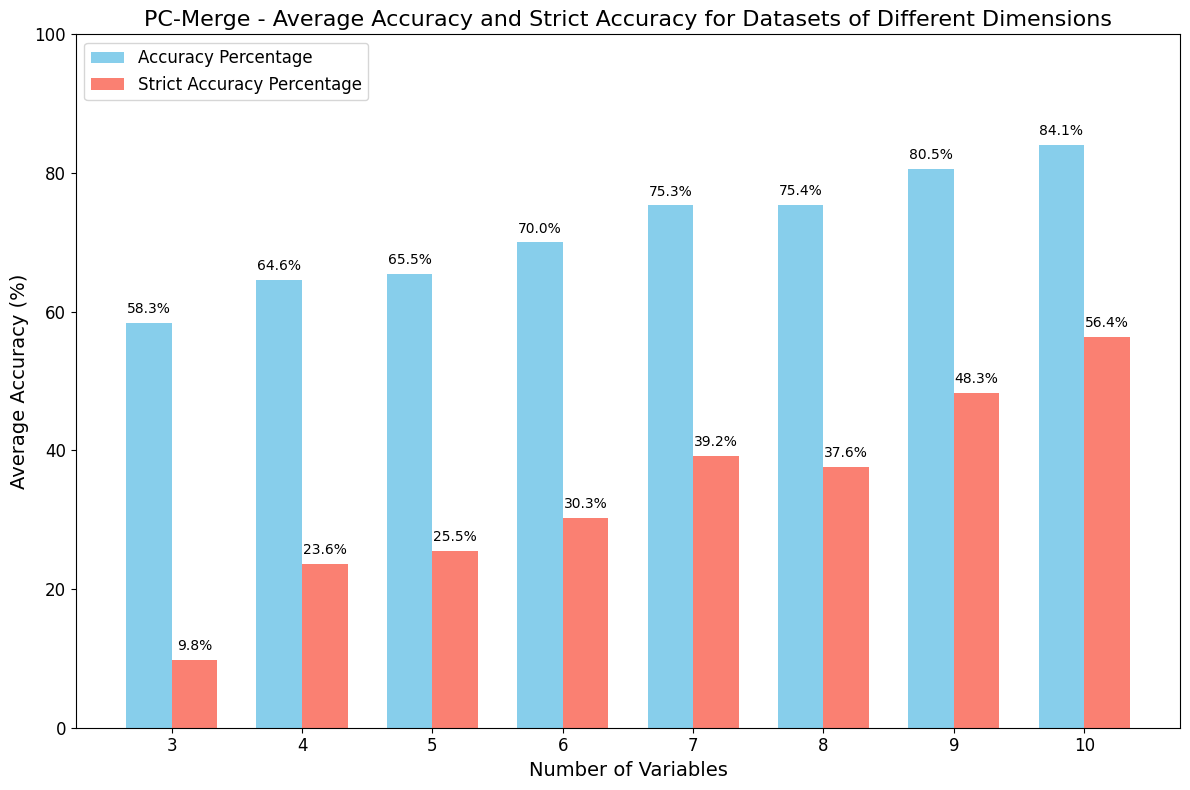

In [22]:
evaluation_results = evaluate_pc_on_datasets(X_train, y_train, num=1000, merge=True)
plot_average_accuracy(evaluation_results, 'PC-Merge')

#### FCI

In [ ]:
from causallearn.search.ConstraintBased.FCI import fci

def FCI_estimate(dataset, alpha=0.05, indep_test='fisherz', kernel=None, 
               depth=-1, max_path_length=-1, verbose=False, show_progress=False):
    """
    使用FCI算法进行因果发现，并应用先验知识。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - alpha (float): 显著性水平，默认值为0.05。
    - indep_test (str): 独立性检验方法，默认值为'fisherz'。
    - kernel (str): 核函数类型，默认值为'linear'。
    - verbose (bool): 是否打印详细输出，默认值为False。
    - show_progress (bool): 是否显示算法进度，默认值为False。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为pivot_table。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    # 2. 定义先验知识：'X' → 'Y'
    # 创建GraphNode对象
    try:
        node_X = GraphNode('X')
        node_Y = GraphNode('Y')
    except Exception as e:
        raise ValueError("确保数据框中包含名为'X'和'Y'的列。") from e
    
    # 初始化BackgroundKnowledge对象并添加先验知识
    bk = BackgroundKnowledge().add_required_by_node(node_X, node_Y)

    # 3. 配置核参数
    if indep_test == 'kci':
        if kernel is None:
            kernel = 'linear'
        if kernel == 'linear':
            kernel_kwargs = {
                'kernelX': 'Linear', 
                'kernelY': 'Linear', 
                'kernelZ': 'Linear', 
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'polynomial':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Polynomial', 
                'polyd': 3,               # 多项式次数设置为3
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'gaussian':
            kernel_kwargs = {
                'kernelX': 'Gaussian', 
                'kernelY': 'Gaussian', 
                'kernelZ': 'Gaussian', 
                'est_width': 'empirical', # 使用经验宽度
                'approx': True,           # 使用伽玛近似
                'nullss': 1000,          # 原假设下模拟的样本量
            }
        elif kernel == 'mix':
            kernel_kwargs = {
                'kernelX': 'Polynomial', 
                'kernelY': 'Polynomial', 
                'kernelZ': 'Gaussian',     # Z使用高斯核
                'polyd': 3,                # 多项式次数设置为3
                'est_width': 'median',     # Z的高斯核带宽使用中位数技巧
                'approx': True,            # 使用伽玛近似
                'nullss': 1000,           # 原假设下模拟的样本量
            }
        else:
            raise ValueError(f'Unknown kernel: {kernel}')
    else:
        kernel_kwargs = {}

    # 4. 运行FCI算法，传入先验知识
    g, edges = fci(data, 
            alpha=alpha, 
            independence_test_method=indep_test, 
            depth=depth,
            max_path_length=max_path_length,
            background_knowledge=bk, 
            verbose=verbose, 
            show_progress=show_progress,
            **kernel_kwargs
    )
    
    # 5. 提取邻接矩阵
    adj_matrix = g.graph
    
    # 6. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

### Score-based causal discovery

#### GES

In [23]:
from causallearn.search.ScoreBased.GES import ges

def GES_estimate(dataset, score_func='local_score_BIC', maxP=None, parameters=None, alpha=0.05):
    """
    使用GES算法进行因果发现。
    
    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - score_func (str): 评分函数，默认为'local_score_BIC'。
    - maxP (int, optional): 最大父节点数量，默认值为None（不限制）。
    - parameters (dict, optional): 评分函数所需的其他参数，默认值为None。
    - alpha (float): 显著性水平，用于多重共线性处理，默认值为0.05。
    
    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为DataFrame。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    
    # 2. 检查相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    # 3. 运行GES算法，使用指定的评分函数和参数
    # 设置默认参数如果未提供
    if parameters is None:
        parameters = {}
    if score_func == 'local_score_CV_general':
        if 'lambda' not in parameters:
            parameters['lambda'] = 0.01
        if 'kfold' not in parameters:
            parameters['kfold'] = 10
            
    if score_func == 'local_score_marginal_general':
        if 'lambda' not in parameters:
            parameters['lambda'] = 0.01

    Record = ges(data, score_func=score_func, maxP=maxP, parameters=parameters)
    
    # 4. 提取邻接矩阵
    adj_matrix = Record['G'].graph
    
    # 5. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_ges_on_datasets(X_train, y_train, num=None, merge=False, score_func='local_score_BIC', maxP=None, parameters=None):
    """
    遍历多个数据集，评估GES算法的效果。
    
    参数:
    - X_train (dict): 输入的训练数据集，键为数据集名称，值为pd.DataFrame。
    - y_train (dict): 真实因果关系的邻接矩阵，键为数据集名称，值为pd.DataFrame。
    - num (int, optional): 要评估的数据集数量，默认遍历全部。
    - score_func (str): 评分函数，默认为'local_score_BIC'。
    - maxP (int, optional): 最大父节点数量，默认值为None（不限制）。
    - parameters (dict, optional): 评分函数所需的其他参数，默认值为None。
    
    返回:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
    """
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating GES Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        if merge == True:
            variables = dataset.columns.drop(["X", "Y"]).tolist()
            Raw_dataset = dataset.copy()
            Squared_dataset = Squared_col(dataset, variables)
            Cos_dataset = Cos_col(dataset, variables)
            Sin_dataset = Sin_col(dataset, variables)
            datasets = [Raw_dataset, Squared_dataset, Cos_dataset, Sin_dataset]
            estimate_adj_df_dags = [convert_bidirectional_to_dag(GES_estimate(d)) for d in datasets]
            estimate_adj_df_dag = merge_dags(estimate_adj_df_dags)
        else:
            estimate_adj_df_bidirectional = GES_estimate(dataset, score_func=score_func, maxP=maxP, parameters=parameters)  # 双向的估计因果图
            estimate_adj_df_dag = convert_bidirectional_to_dag(estimate_adj_df_bidirectional)  # 将双向图转换为有向图
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [8]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = GES_estimate(A)
print(C)
D = convert_bidirectional_to_dag(C)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

Evaluating GES Algorithm:   2%|▏         | 21/1000 [00:33<31:36,  1.94s/dataset]d:\anaconda3\envs\adia_py311\Lib\site-packages\causallearn\score\LocalScoreFunction.py:73: RuntimeWarning: invalid value encountered in log
  H = np.log(cov[i, i] - yX * np.linalg.inv(XX) * yX.T)
Evaluating GES Algorithm:  10%|▉         | 98/1000 [02:32<25:04,  1.67s/dataset]d:\anaconda3\envs\adia_py311\Lib\site-packages\causallearn\score\LocalScoreFunction.py:73: RuntimeWarning: invalid value encountered in log
  H = np.log(cov[i, i] - yX * np.linalg.inv(XX) * yX.T)
Evaluating GES Algorithm:  17%|█▋        | 171/1000 [04:18<19:11,  1.39s/dataset]d:\anaconda3\envs\adia_py311\Lib\site-packages\causallearn\score\LocalScoreFunction.py:73: RuntimeWarning: invalid value encountered in log
  H = np.log(cov[i, i] - yX * np.linalg.inv(XX) * yX.T)
Evaluating GES Algorithm:  18%|█▊        | 185/1000 [04:36<21:38,  1.59s/dataset]d:\anaconda3\envs\adia_py311\Lib\site-packages\causallearn\score\LocalScoreFunction.py:73:

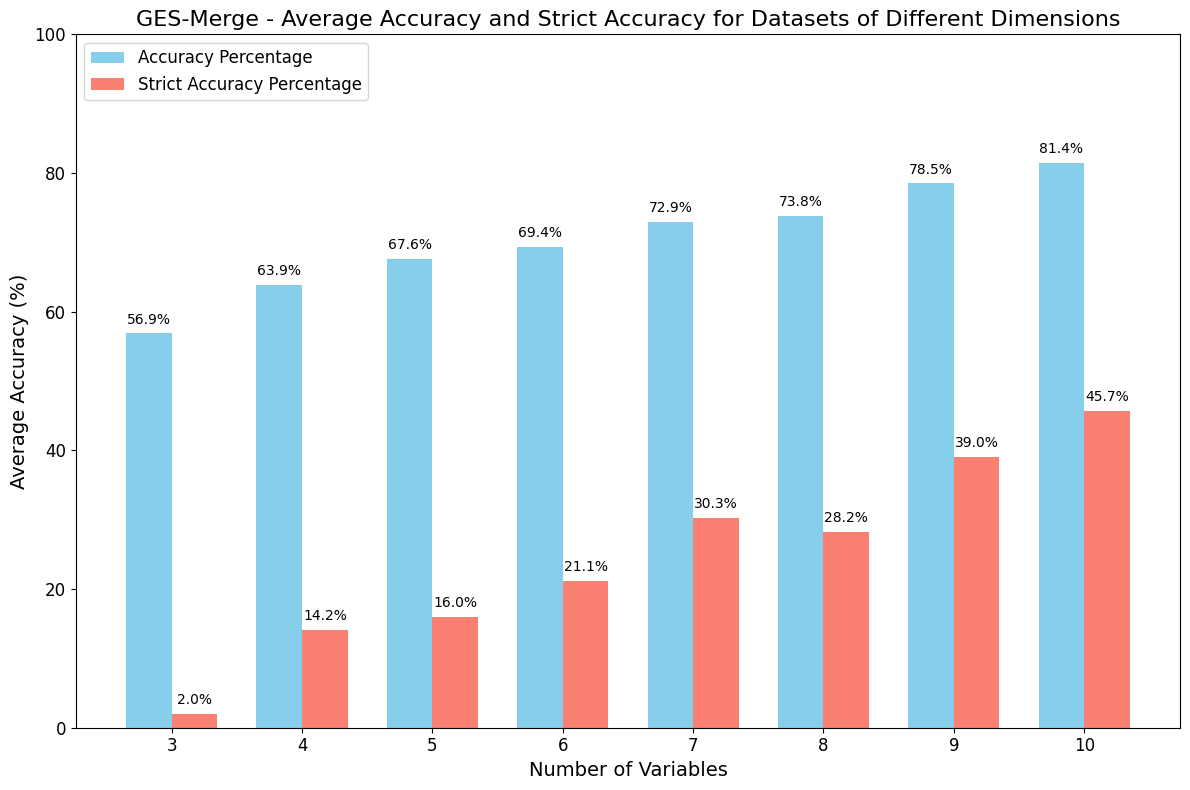

In [24]:
evaluation_results = evaluate_ges_on_datasets(X_train, y_train, num=1000, merge=True)
plot_average_accuracy(evaluation_results, 'GES-Merge')

#### Exact Search

In [23]:
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search

def ExactSearch_estimate(dataset, search_method='astar', use_path_extension=True, 
                        use_k_cycle_heuristic=False, k=3, max_parents=None):
    """
    使用Exact Search算法进行因果发现。
    
    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - search_method (str): Exact Search方法，'astar'或'dp'。默认值为'astar'。
    - use_path_extension (bool): 是否使用路径扩展。默认值为True。
    - use_k_cycle_heuristic (bool): 是否使用k-cycle冲突启发式。仅适用于'astar'方法。默认值为False。
    - k (int): k-cycle启发式的参数。默认值为3。
    - max_parents (int or None): 节点的最大父节点数量。默认值为None。
    
    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为DataFrame。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 2. 定义X→Y的超级图
    d = dataset.shape[1]   
    super_graph = np.ones((d, d), dtype=int)  # 初始化为全1，表示所有边默认允许
    columns = dataset.columns.tolist()
    x_idx = columns.index('X')
    y_idx = columns.index('Y')
    super_graph[y_idx][x_idx] = 0     # 禁止'Y'→'X'
    np.fill_diagonal(super_graph, 0)  # 禁止自环：确保对角线为0
    
    # 3. 运行Exact Search算法，使用指定的参数
    dag_est, search_stats = bic_exact_search(
        X=data, 
        super_graph=super_graph, 
        search_method=search_method,
        use_path_extension=use_path_extension, 
        use_k_cycle_heuristic=use_k_cycle_heuristic,
        k=k, 
        verbose=False, 
        max_parents=max_parents
    )
    
    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(dag_est, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_exact_search_on_datasets(X_train, y_train, num=None, search_method='astar', 
                                      use_path_extension=True, use_k_cycle_heuristic=False, k=3, max_parents=None):
    """
    遍历多个数据集，评估Exact Search算法的效果。
    
    参数:
    - X_train (dict): 输入的训练数据集，键为数据集名称，值为pd.DataFrame。
    - y_train (dict): 真实因果关系的邻接矩阵，键为数据集名称，值为pd.DataFrame。
    - num (int, optional): 要评估的数据集数量，默认遍历全部。
    - super_graph (numpy.ndarray or None): 超结构，用于限制搜索空间。默认值为None。
    - search_method (str): Exact Search方法，'astar'或'dp'。默认值为'astar'。
    - use_path_extension (bool): 是否使用路径扩展。默认值为True。
    - use_k_cycle_heuristic (bool): 是否使用k-cycle冲突启发式。仅适用于'astar'方法。默认值为False。
    - k (int): k-cycle启发式的参数。默认值为3。
    - verbose (bool): 是否打印详细输出。默认值为False。
    - include_graph (bool): 是否在搜索统计中包含图信息。默认值为True。
    - max_parents (int or None): 节点的最大父节点数量。默认值为None。
    - score_func (str): 评分函数。默认为'local_score_BIC'。
    - alpha (float): 显著性水平，用于多重共线性处理。默认值为0.05。
    
    返回:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
    """
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating Exact Search Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df = ExactSearch_estimate(
            dataset, 
            search_method=search_method, 
            use_path_extension=use_path_extension,
            use_k_cycle_heuristic=use_k_cycle_heuristic, 
            k=k, 
            max_parents=max_parents
        )
        estimate_adj_df_dag = estimate_adj_df.astype(int)  # Directly using the estimated DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

Evaluating Exact Search Algorithm: 100%|██████████| 1000/1000 [27:11<00:00,  1.63s/dataset]


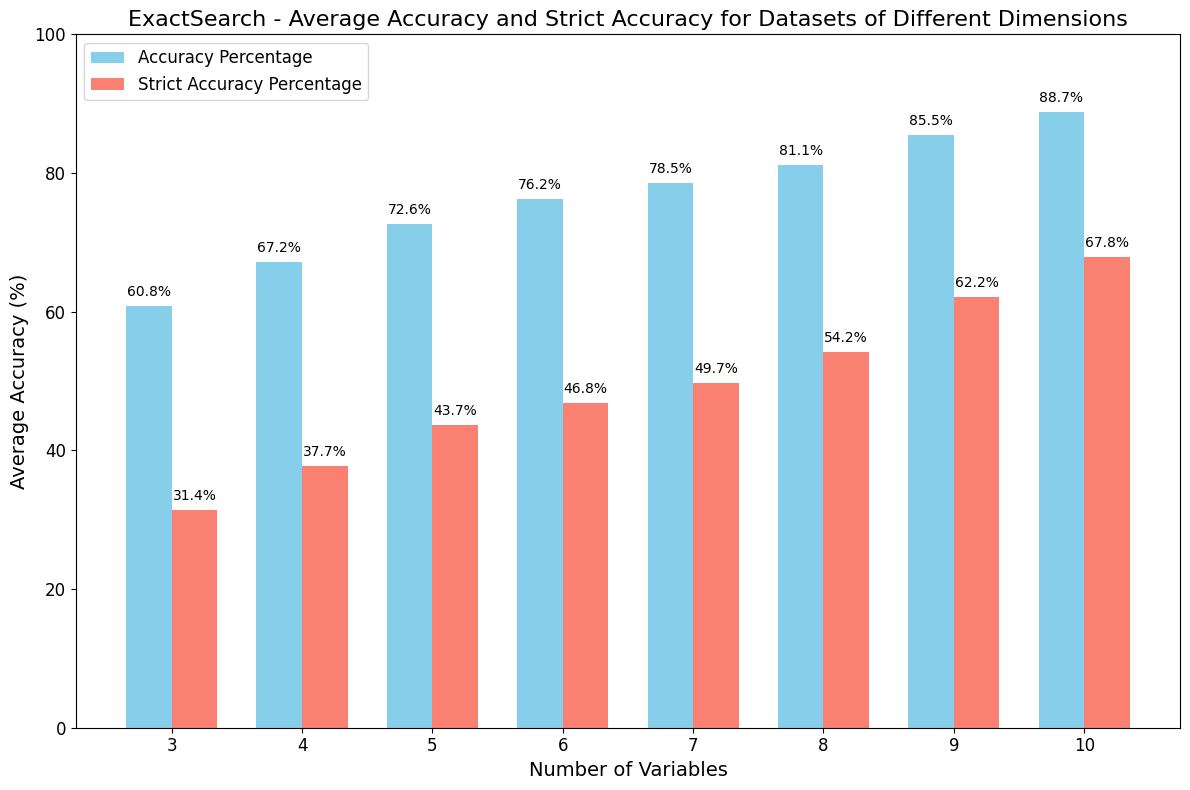

In [24]:
evaluation_results = evaluate_exact_search_on_datasets(X_train, y_train, num=1000)
plot_average_accuracy(evaluation_results, 'ExactSearch')

In [10]:
from dagma.linear import DagmaLinear
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

def NOTEARS_estimate(dataset, lambda1=0.1, w_threshold=0.3):
    """
    使用NOTEARS算法进行因果发现。
    
    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - lambda1 (float): L1正则化参数，默认为0.1。
    - w_threshold (float): 边权重阈值，低于此值的边将被视为不存在，默认为0.3。
    
    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为DataFrame。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    
    # 2. 运行NOTEARS算法
    model = DagmaLinear(loss_type='l2')
    W_est = model.fit(data, lambda1=lambda1)
    
    # 3. 应用阈值
    W_est[np.abs(W_est) < w_threshold] = 0
    
    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(W_est, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_NOTEARS_on_datasets(X_train, y_train, num=None, lambda1=0.1, w_threshold=0.3):
    """
    遍历多个数据集，评估NOTEARS算法的效果。
    
    参数:
    - X_train (dict): 输入的训练数据集，键为数据集名称，值为pd.DataFrame。
    - y_train (dict): 真实因果关系的邻接矩阵，键为数据集名称，值为pd.DataFrame。
    - num (int, optional): 要评估的数据集数量，默认遍历全部。
    - lambda1 (float): L1正则化参数，默认为0.1。
    - w_threshold (float): 边权重阈值，默认为0.3。
    
    返回:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
    - last_est_graph (nx.DiGraph): 最后一个数据集的估计图。
    - last_true_graph (nx.DiGraph): 最后一个数据集的真实图。
    """
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    last_est_graph = None
    last_true_graph = None
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating NOTEARS Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df = NOTEARS_estimate(dataset, lambda1=lambda1, w_threshold=w_threshold)
        estimate_adj_df_dag = (estimate_adj_df != 0).astype(int)  # 将非零值转换为1
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
        
        # 保存最后一个数据集的图
        last_est_graph = nx.from_pandas_adjacency(estimate_adj_df_dag, create_using=nx.DiGraph)
        last_true_graph = nx.from_pandas_adjacency(true_adj_df_dag, create_using=nx.DiGraph)
    
    return evaluation_results, last_est_graph, last_true_graph

def plot_graph(G, title):
    """
    绘制有向图。
    
    参数:
    - G (nx.DiGraph): 要绘制的图。
    - title (str): 图的标题。
    """
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, arrowsize=20, font_size=12)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = NOTEARS_estimate(A)
print(C)
D = (C != 0).astype(int)
print(D)




e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

100%|██████████| 180000/180000.0 [00:03<00:00, 59577.11it/s]

     0         Y    2         3    4         5    6        7    8         X
0  0.0  0.000000  0.0  0.000000  0.0 -0.516909  0.0  0.00000  0.0  0.000000
Y  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0 -0.471042
2  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
3  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
4  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
5  0.0  0.000000  0.0  0.424703  0.0  0.000000  0.0  0.00000  0.0  0.000000
6  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
7  0.0  0.320319  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
8  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.50884  0.0  0.000000
X  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.00000  0.0  0.000000
   0  Y  2  3  4  5  6  7  8  X
0  0  0  0  0  0  1  0  0  0  0
Y  0  0  0  0  0  0  0  0  0  1
2  0  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0  0  0  0
4  0

100%|██████████| 180000/180000.0 [00:03<00:00, 56963.16it/s]?, ?dataset/s]
100%|██████████| 180000/180000.0 [00:06<00:00, 26672.95it/s]05:13,  3.17s/dataset]
100%|██████████| 180000/180000.0 [00:06<00:00, 29173.02it/s]08:37,  5.28s/dataset]
100%|██████████| 180000/180000.0 [00:05<00:00, 33596.03it/s]09:12,  5.69s/dataset]
100%|██████████| 180000/180000.0 [00:02<00:00, 73682.52it/s] 8:54,  5.56s/dataset]
100%|██████████| 180000/180000.0 [00:02<00:00, 85422.63it/s] 7:01,  4.44s/dataset]
100%|██████████| 180000/180000.0 [00:05<00:00, 32099.84it/s]05:43,  3.65s/dataset]
100%|██████████| 180000/180000.0 [00:06<00:00, 27548.98it/s]06:39,  4.29s/dataset]
100%|██████████| 180000/180000.0 [00:04<00:00, 43644.05it/s]07:40,  5.01s/dataset]
100%|██████████| 180000/180000.0 [00:03<00:00, 53432.03it/s]07:10,  4.73s/dataset]
100%|██████████| 180000/180000.0 [00:07<00:00, 24105.36it/s]<06:28,  4.32s/dataset]
100%|██████████| 180000/180000.0 [00:02<00:00, 67914.62it/s] 07:50,  5.28s/dataset]
100%|█████

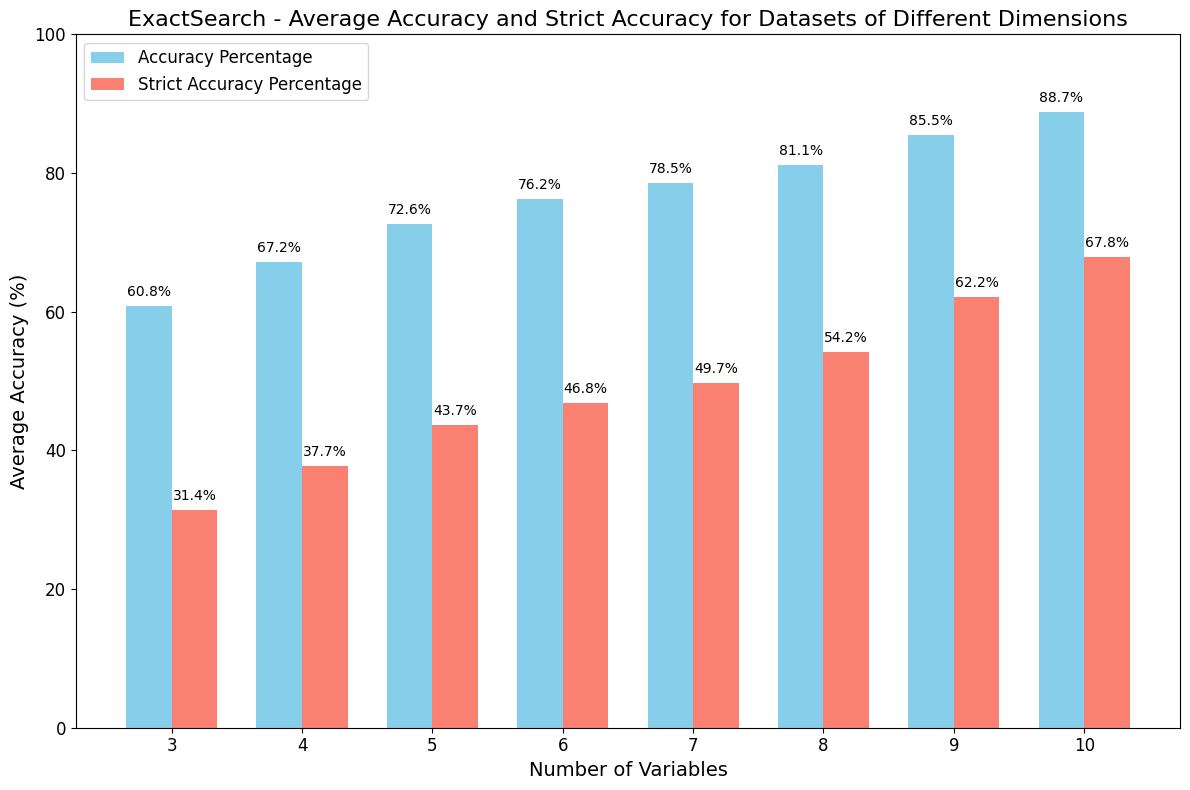

In [16]:
from tqdm import tqdm

evaluation_results = evaluate_NOTEARS_on_datasets(X_train, y_train, num=100)
plot_average_accuracy(evaluation_results, 'NOTEARS')

### LiNGAM-based Methods

#### ICA-based LiNGAM

In [25]:
from causallearn.search.FCMBased import lingam

def ICALiNGAM_estimate(dataset, random_state=42, max_iter=1000):
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    
    # 2. 运行ICALiNGAM算法，使用指定的参数
    model = lingam.ICALiNGAM(random_state=random_state, max_iter=max_iter)
    model.fit(data)

    # print(model.causal_order_)
    # 3. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(model.adjacency_matrix_, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_ICALiNGAM_on_datasets(X_train, y_train, num=None, merge=False, random_state=42, max_iter=1000):
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating ICA-based LiNGAM Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        if merge == True:
            variables = dataset.columns.drop(["X", "Y"]).tolist()
            Raw_dataset = dataset.copy()
            Squared_dataset = Squared_col(dataset, variables)
            Cos_dataset = Cos_col(dataset, variables)
            Sin_dataset = Sin_col(dataset, variables)
            datasets = [Raw_dataset, Squared_dataset, Cos_dataset, Sin_dataset]
            estimate_adj_df_dags = [convert_dag_with_strength_to_dag(ICALiNGAM_estimate(d)) for d in datasets]
            estimate_adj_df_dag = merge_dags(estimate_adj_df_dags)
        else:
            estimate_adj_df = ICALiNGAM_estimate(dataset, random_state=random_state, max_iter=max_iter)
            estimate_adj_df_dag = convert_dag_with_strength_to_dag(estimate_adj_df)  # convert to no-strength DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [36]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = ICALiNGAM_estimate(A)
print(C)
D = convert_dag_with_strength_to_dag(C)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

In [26]:
evaluation_results = evaluate_ICALiNGAM_on_datasets(X_train, y_train, num=1000, merge=True)

Evaluating ICA-based LiNGAM Algorithm:   0%|          | 1/1000 [00:00<03:14,  5.14dataset/s]d:\anaconda3\envs\adia_py311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
d:\anaconda3\envs\adia_py311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
d:\anaconda3\envs\adia_py311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
Evaluating ICA-based LiNGAM Algorithm:   1%|          | 8/1000 [00:02<03:24,  4.85dataset/s]d:\anaconda3\envs\adia_py311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the

ValueError: cost matrix is infeasible

In [ ]:
plot_average_accuracy(evaluation_results, 'ICA-based LiNGAM')

#### DirectLiNGAM

In [50]:
from causallearn.search.FCMBased import lingam

def DirectLiNGAM_estimate(dataset, random_state=42, measure='pwling'):
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 2. 定义先验知识
    d = dataset.shape[1]   
    super_graph = np.ones((d, d), dtype=int) * -1  # 初始化为全-1，表示所有边默认无先验知识
    columns = dataset.columns.tolist()
    x_idx = columns.index('X')
    y_idx = columns.index('Y')
    super_graph[x_idx][y_idx] = 1     # 固定'X'→'Y'
    super_graph[y_idx][x_idx] = 0     # 禁止'Y'→'X'
    np.fill_diagonal(super_graph, 0)  # 禁止自环：确保对角线为0
    
    # 3. 运行DirectLiNGAM算法，使用指定的参数
    model = lingam.DirectLiNGAM(random_state, prior_knowledge=super_graph, apply_prior_knowledge_softly=False, measure=measure)
    model.fit(data)

    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(model.adjacency_matrix_, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_DirectLiNGAM_on_datasets(X_train, y_train, num=None, random_state=42, measure='pwling'):
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating DirectLiNGAM Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df = DirectLiNGAM_estimate(dataset, random_state=random_state, measure=measure)
        estimate_adj_df_dag = convert_dag_with_strength_to_dag(estimate_adj_df)  # convert to no-strength DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [49]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = DirectLiNGAM_estimate(A, random_state=42, measure='pwling')
print(C)
D = convert_dag_with_strength_to_dag(C)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

Evaluating ICA-based LiNGAM Algorithm: 100%|██████████| 1000/1000 [03:20<00:00,  4.99dataset/s]


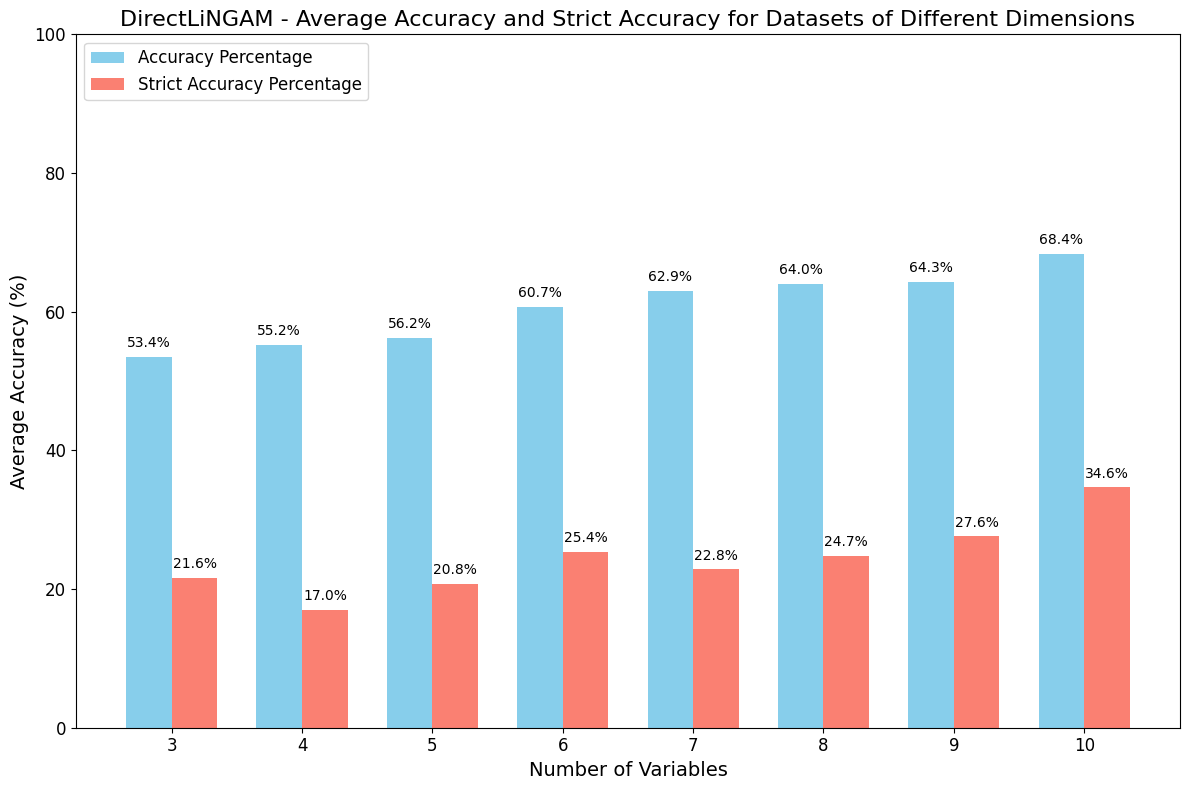

In [51]:
evaluation_results = evaluate_DirectLiNGAM_on_datasets(X_train, y_train, num=1000)
plot_average_accuracy(evaluation_results, 'DirectLiNGAM')

#### RCD

In [52]:
from causallearn.search.FCMBased import lingam

def RCD_estimate(dataset, max_explanatory_num=3, cor_alpha=0.05, ind_alpha=0.05, shapiro_alpha=0.05, MLHSICR=True, bw_method='mdbs'):
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    
    # 2. 运行RCD算法，使用指定的参数
    model = lingam.RCD(
        max_explanatory_num=max_explanatory_num, 
        cor_alpha=cor_alpha, 
        ind_alpha=ind_alpha, 
        shapiro_alpha=shapiro_alpha, 
        MLHSICR=MLHSICR, 
        bw_method=bw_method
    )
    model.fit(data)

    # 3. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(model.adjacency_matrix_, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_RCD_on_datasets(X_train, y_train, num=None, max_explanatory_num=3, cor_alpha=0.05, ind_alpha=0.05, shapiro_alpha=0.05, MLHSICR=True, bw_method='mdbs'):
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating RCD Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df = RCD_estimate(dataset, max_explanatory_num=max_explanatory_num, cor_alpha=cor_alpha,
            ind_alpha=ind_alpha, shapiro_alpha=shapiro_alpha, MLHSICR=MLHSICR, bw_method=bw_method)
        estimate_adj_df_dag = convert_dag_with_strength_to_dag(estimate_adj_df)  # convert to no-strength DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [54]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = RCD_estimate(A, max_explanatory_num=3, cor_alpha=0.05, ind_alpha=0.05, shapiro_alpha=0.05, MLHSICR=False, bw_method='mdbs')
print(C)
D = convert_dag_with_strength_to_dag(C)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

#### CAM-UV

In [6]:
from causallearn.search.FCMBased.lingam import CAMUV

def CAMUV_estimate(dataset, alpha=0.05):
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    num_explanatory_vals = data.shape[1] - 1
    print(num_explanatory_vals)
    
    # 2. 运行CAMUV算法，使用指定的参数
    P, U = CAMUV.execute(data, alpha, num_explanatory_vals)

    # 3. 获取邻接矩阵
    num_features = len(dataset.columns)
    adjacency_matrix = np.zeros((num_features, num_features), dtype=int)
    for child_idx, parents in enumerate(P):
        for parent_idx in parents:
            adjacency_matrix[parent_idx, child_idx] = 1

    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adjacency_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_CAMUV_on_datasets(X_train, y_train, num=None, alpha=0.05):
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating CAM-UV Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df = CAMUV_estimate(dataset, alpha=0.05)
        estimate_adj_df_dag = estimate_adj_df.astype(int)  # Directly using the estimated DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [8]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = CAMUV_estimate(A, alpha=0.05)
print(C)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

### Permutation-based causal discovery methods

#### GRaSP

In [12]:
from causallearn.search.PermutationBased.GRaSP import grasp

def GRaSP_estimate(dataset, score_func='local_score_BIC', maxP=None):    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    parameters = {
        'kfold': 2,         # 2 折交叉验证
        'lambda': 0.01      # 正则化参数
    }

    # 2. 运行PC算法，传入先验知识
    G = grasp(
        data, 
        score_func=score_func, 
        maxP=maxP, 
        parameters=parameters
    )

    # 3. 获取邻接矩阵
    adj_matrix = G.graph
    
    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def evaluate_GRaSP_on_datasets(X_train, y_train, num=None, score_func='local_score_BIC', maxP=None):
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating GRaSP Algorithm", unit="dataset"):
        dataset = X_train[key]
        true_adj_df_dag = y_train[key]
        estimate_adj_df_bidirectional = GRaSP_estimate(dataset, score_func=score_func, maxP=maxP)  # 双向的估计因果图
        estimate_adj_df_dag = convert_bidirectional_to_dag(estimate_adj_df_bidirectional)  # 将双向图转换为有向图
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

In [13]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)
C = GRaSP_estimate(A)
print(C)
D = convert_bidirectional_to_dag(C)
print(D)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

KeyboardInterrupt: 

In [20]:
evaluation_results = evaluate_GRaSP_on_datasets(X_train, y_train, num=1000)

Evaluating GRaSP Algorithm:   0%|          | 0/1000 [00:00<?, ?dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:   0%|          | 1/1000 [00:00<02:59,  5.57dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:   0%|          | 2/1000 [00:00<03:22,  4.92dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:   0%|          | 3/1000 [00:00<03:08,  5.29dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.40s 


Evaluating GRaSP Algorithm:   0%|          | 4/1000 [00:00<04:34,  3.63dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.08s 
GRaSP edge count: 9    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:   1%|          | 6/1000 [00:01<02:45,  5.99dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 10    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:   1%|          | 8/1000 [00:01<02:26,  6.79dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:   1%|          | 9/1000 [00:01<02:34,  6.42dataset/s]

GRaSP edge count: 7     
GRaSP completed in: 0.09s 
GRaSP edge count: 11    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:   1%|          | 11/1000 [00:01<02:39,  6.21dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 

GRaSP completed in: 0.01s 
GRaSP edge count: 21    
GRaSP completed in: 0.34s 


Evaluating GRaSP Algorithm:   1%|▏         | 14/1000 [00:02<02:22,  6.90dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:   2%|▏         | 15/1000 [00:02<02:20,  7.03dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:   2%|▏         | 16/1000 [00:02<02:36,  6.27dataset/s]


GRaSP completed in: 0.04s 

GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:   2%|▏         | 18/1000 [00:02<02:01,  8.08dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:   2%|▏         | 19/1000 [00:02<02:23,  6.84dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:   2%|▏         | 20/1000 [00:03<02:48,  5.81dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.28s 


Evaluating GRaSP Algorithm:   2%|▏         | 21/1000 [00:03<03:17,  4.96dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 15    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:   2%|▏         | 23/1000 [00:03<02:42,  6.03dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:   2%|▏         | 24/1000 [00:03<02:46,  5.85dataset/s]


GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:   2%|▎         | 25/1000 [00:04<02:31,  6.43dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:   3%|▎         | 26/1000 [00:04<03:07,  5.18dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:   3%|▎         | 29/1000 [00:04<02:20,  6.89dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:   3%|▎         | 30/1000 [00:04<02:25,  6.67dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   3%|▎         | 31/1000 [00:04<02:18,  7.01dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:   3%|▎         | 32/1000 [00:05<02:33,  6.32dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   3%|▎         | 33/1000 [00:05<02:23,  6.72dataset/s]


GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:   3%|▎         | 34/1000 [00:05<03:07,  5.15dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:   4%|▎         | 35/1000 [00:05<02:51,  5.62dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 
GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:   4%|▎         | 37/1000 [00:05<02:25,  6.62dataset/s]


GRaSP completed in: 0.02s 

GRaSP completed in: 0.05s 
GRaSP edge count: 9     
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:   4%|▍         | 40/1000 [00:06<01:52,  8.52dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.03s 
GRaSP edge count: 18    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:   4%|▍         | 42/1000 [00:06<01:53,  8.42dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:   4%|▍         | 43/1000 [00:06<02:03,  7.76dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:   4%|▍         | 44/1000 [00:06<02:40,  5.94dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   5%|▍         | 46/1000 [00:07<02:07,  7.49dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:   5%|▍         | 47/1000 [00:07<02:44,  5.78dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 16    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:   5%|▍         | 49/1000 [00:07<02:28,  6.38dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:   5%|▌         | 50/1000 [00:07<02:38,  5.98dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.40s 


Evaluating GRaSP Algorithm:   5%|▌         | 51/1000 [00:08<03:33,  4.45dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:   5%|▌         | 52/1000 [00:08<03:27,  4.57dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:   5%|▌         | 53/1000 [00:08<03:12,  4.91dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 11    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:   6%|▌         | 55/1000 [00:08<02:30,  6.27dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   6%|▌         | 56/1000 [00:08<02:21,  6.65dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:   6%|▌         | 57/1000 [00:09<03:01,  5.19dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.09s 
GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:   6%|▌         | 59/1000 [00:09<02:45,  5.67dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.03s 
GRaSP edge count: 18    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:   6%|▌         | 61/1000 [00:09<02:16,  6.88dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.47s 


Evaluating GRaSP Algorithm:   6%|▌         | 62/1000 [00:10<03:23,  4.60dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.08s 
GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:   6%|▋         | 64/1000 [00:10<02:45,  5.64dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:   7%|▋         | 66/1000 [00:10<02:14,  6.93dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:   7%|▋         | 67/1000 [00:10<02:40,  5.81dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:   7%|▋         | 68/1000 [00:11<02:33,  6.07dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:   7%|▋         | 70/1000 [00:11<01:53,  8.20dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.30s 
GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   7%|▋         | 72/1000 [00:11<02:23,  6.45dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:   7%|▋         | 73/1000 [00:11<02:48,  5.52dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.03s 
GRaSP edge count: 14    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:   8%|▊         | 75/1000 [00:12<02:29,  6.17dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 14    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:   8%|▊         | 77/1000 [00:12<02:08,  7.20dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:   8%|▊         | 78/1000 [00:12<02:43,  5.64dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:   8%|▊         | 79/1000 [00:12<02:43,  5.62dataset/s]

GRaSP edge count: 7     
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:   8%|▊         | 80/1000 [00:13<02:40,  5.73dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:   8%|▊         | 81/1000 [00:13<02:58,  5.15dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.37s 


Evaluating GRaSP Algorithm:   8%|▊         | 82/1000 [00:13<03:44,  4.09dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 16    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:   8%|▊         | 84/1000 [00:13<03:05,  4.94dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:   8%|▊         | 85/1000 [00:14<02:50,  5.37dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:   9%|▊         | 86/1000 [00:14<03:05,  4.93dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:   9%|▊         | 87/1000 [00:14<03:07,  4.87dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:   9%|▉         | 88/1000 [00:14<03:13,  4.72dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:   9%|▉         | 89/1000 [00:14<03:11,  4.76dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 
GRaSP edge count: 11    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:   9%|▉         | 91/1000 [00:15<02:52,  5.27dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:   9%|▉         | 92/1000 [00:15<02:39,  5.71dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:   9%|▉         | 93/1000 [00:15<02:27,  6.15dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.07s 
GRaSP edge count: 5    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  10%|▉         | 95/1000 [00:15<01:49,  8.27dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  10%|▉         | 96/1000 [00:15<01:53,  7.96dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  10%|▉         | 97/1000 [00:16<02:22,  6.33dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  10%|▉         | 98/1000 [00:16<02:49,  5.31dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  10%|▉         | 99/1000 [00:16<02:51,  5.27dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  10%|█         | 100/1000 [00:16<02:58,  5.03dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  10%|█         | 101/1000 [00:17<03:18,  4.54dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  10%|█         | 102/1000 [00:17<03:30,  4.28dataset/s]

GRaSP edge count: 27    
GRaSP completed in: 0.53s 


Evaluating GRaSP Algorithm:  10%|█         | 103/1000 [00:17<04:50,  3.08dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 9    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  10%|█         | 105/1000 [00:17<03:00,  4.95dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 8    
GRaSP completed in: 0.07s 
GRaSP edge count: 16    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  11%|█         | 108/1000 [00:18<02:16,  6.53dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  11%|█         | 109/1000 [00:18<02:41,  5.52dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.06s 
GRaSP edge count: 14    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  11%|█         | 111/1000 [00:18<02:39,  5.58dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  11%|█         | 112/1000 [00:19<02:55,  5.05dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  11%|█▏        | 113/1000 [00:19<02:54,  5.07dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  11%|█▏        | 114/1000 [00:19<02:54,  5.07dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  12%|█▏        | 115/1000 [00:19<03:07,  4.72dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.33s 


Evaluating GRaSP Algorithm:  12%|█▏        | 117/1000 [00:20<02:53,  5.08dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  12%|█▏        | 118/1000 [00:20<02:58,  4.94dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  12%|█▏        | 119/1000 [00:20<02:51,  5.14dataset/s]


GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  12%|█▏        | 120/1000 [00:20<02:55,  5.01dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.37s 


Evaluating GRaSP Algorithm:  12%|█▏        | 121/1000 [00:21<03:41,  3.96dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  12%|█▏        | 122/1000 [00:21<03:38,  4.02dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.40s 


Evaluating GRaSP Algorithm:  12%|█▏        | 123/1000 [00:21<04:19,  3.38dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  12%|█▏        | 124/1000 [00:22<03:41,  3.96dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  12%|█▎        | 125/1000 [00:22<03:25,  4.26dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  13%|█▎        | 126/1000 [00:22<03:04,  4.73dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  13%|█▎        | 127/1000 [00:22<03:01,  4.82dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.05s 
GRaSP edge count: 3    
GRaSP completed in: 0.02s 

GRaSP completed in: 0.01s 
GRaSP edge count: 23    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  13%|█▎        | 131/1000 [00:22<01:43,  8.43dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.09s 
GRaSP edge count: 10    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  13%|█▎        | 133/1000 [00:23<01:45,  8.21dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  13%|█▎        | 134/1000 [00:23<01:47,  8.04dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.44s 


Evaluating GRaSP Algorithm:  14%|█▎        | 135/1000 [00:23<02:45,  5.23dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  14%|█▎        | 136/1000 [00:23<02:41,  5.36dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  14%|█▎        | 137/1000 [00:24<02:55,  4.91dataset/s]


GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  14%|█▍        | 138/1000 [00:24<02:57,  4.85dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  14%|█▍        | 139/1000 [00:24<03:05,  4.63dataset/s]


GRaSP completed in: 0.03s 
GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  14%|█▍        | 141/1000 [00:24<02:19,  6.14dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.34s 


Evaluating GRaSP Algorithm:  14%|█▍        | 142/1000 [00:25<03:00,  4.74dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  14%|█▍        | 143/1000 [00:25<03:11,  4.47dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  14%|█▍        | 144/1000 [00:25<02:46,  5.13dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.42s 


Evaluating GRaSP Algorithm:  14%|█▍        | 145/1000 [00:25<03:44,  3.80dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  15%|█▍        | 146/1000 [00:26<03:50,  3.70dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  15%|█▍        | 147/1000 [00:26<03:44,  3.80dataset/s]


GRaSP completed in: 0.02s 

GRaSP completed in: 0.01s 
GRaSP edge count: 13    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  15%|█▌        | 150/1000 [00:26<02:09,  6.56dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  15%|█▌        | 151/1000 [00:26<02:10,  6.52dataset/s]

GRaSP edge count: 29    
GRaSP completed in: 0.74s 


Evaluating GRaSP Algorithm:  15%|█▌        | 152/1000 [00:27<04:06,  3.43dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  15%|█▌        | 153/1000 [00:27<03:45,  3.76dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  15%|█▌        | 154/1000 [00:27<03:33,  3.96dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.07s 
GRaSP edge count: 11    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  16%|█▌        | 156/1000 [00:28<02:52,  4.90dataset/s]


GRaSP completed in: 0.04s 
GRaSP edge count: 15    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  16%|█▌        | 158/1000 [00:28<02:38,  5.32dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  16%|█▌        | 159/1000 [00:28<02:23,  5.86dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 18    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  16%|█▌        | 161/1000 [00:28<02:01,  6.88dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  16%|█▌        | 162/1000 [00:29<02:06,  6.65dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.43s 


Evaluating GRaSP Algorithm:  16%|█▋        | 163/1000 [00:29<03:02,  4.60dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  16%|█▋        | 164/1000 [00:29<02:45,  5.04dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.04s 
GRaSP edge count: 15    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  17%|█▋        | 166/1000 [00:29<02:14,  6.22dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  17%|█▋        | 167/1000 [00:29<02:09,  6.41dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  17%|█▋        | 168/1000 [00:30<02:23,  5.82dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  17%|█▋        | 169/1000 [00:30<02:51,  4.85dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 12    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  17%|█▋        | 171/1000 [00:30<02:12,  6.24dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  17%|█▋        | 172/1000 [00:30<02:04,  6.67dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  17%|█▋        | 173/1000 [00:30<02:06,  6.55dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 13    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  18%|█▊        | 175/1000 [00:31<02:00,  6.82dataset/s]


GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  18%|█▊        | 176/1000 [00:31<01:56,  7.08dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  18%|█▊        | 177/1000 [00:31<01:59,  6.90dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  18%|█▊        | 178/1000 [00:31<01:52,  7.33dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 12    
GRaSP completed in: 0.28s 


Evaluating GRaSP Algorithm:  18%|█▊        | 180/1000 [00:32<02:06,  6.49dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.02s 
GRaSP edge count: 19    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  18%|█▊        | 182/1000 [00:32<01:56,  7.01dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.03s 
GRaSP edge count: 14    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  18%|█▊        | 184/1000 [00:32<01:58,  6.89dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.36s 


Evaluating GRaSP Algorithm:  18%|█▊        | 185/1000 [00:32<02:35,  5.24dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  19%|█▊        | 186/1000 [00:33<02:22,  5.70dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  19%|█▊        | 187/1000 [00:33<02:30,  5.41dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  19%|█▉        | 188/1000 [00:33<02:30,  5.40dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  19%|█▉        | 189/1000 [00:33<02:20,  5.78dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.28s 


Evaluating GRaSP Algorithm:  19%|█▉        | 190/1000 [00:33<02:47,  4.85dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.02s 
GRaSP edge count: 22    
GRaSP completed in: 0.47s 


Evaluating GRaSP Algorithm:  19%|█▉        | 192/1000 [00:34<03:04,  4.39dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.09s 
GRaSP edge count: 8    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  19%|█▉        | 194/1000 [00:34<02:15,  5.93dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  20%|█▉        | 195/1000 [00:34<02:06,  6.34dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  20%|█▉        | 196/1000 [00:34<02:02,  6.54dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  20%|█▉        | 198/1000 [00:34<01:34,  8.49dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  20%|█▉        | 199/1000 [00:35<02:08,  6.25dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.04s 
GRaSP edge count: 15    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  20%|██        | 201/1000 [00:35<01:58,  6.75dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  20%|██        | 202/1000 [00:35<02:00,  6.60dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  20%|██        | 203/1000 [00:35<02:31,  5.25dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  20%|██        | 204/1000 [00:36<02:22,  5.59dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  20%|██        | 205/1000 [00:36<02:27,  5.38dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  21%|██        | 207/1000 [00:36<01:52,  7.02dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  21%|██        | 208/1000 [00:36<01:49,  7.23dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  21%|██        | 209/1000 [00:36<02:03,  6.39dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  21%|██        | 210/1000 [00:36<01:52,  7.05dataset/s]


GRaSP completed in: 0.01s 

GRaSP completed in: 0.02s 
GRaSP edge count: 9     
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  21%|██▏       | 213/1000 [00:37<01:16, 10.29dataset/s]


GRaSP completed in: 0.01s 

GRaSP completed in: 0.06s 
GRaSP edge count: 13    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  22%|██▏       | 216/1000 [00:37<01:10, 11.14dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  22%|██▏       | 218/1000 [00:37<01:22,  9.47dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  22%|██▏       | 219/1000 [00:37<01:37,  8.02dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  22%|██▏       | 220/1000 [00:38<01:45,  7.42dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  22%|██▏       | 221/1000 [00:38<02:02,  6.34dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  22%|██▏       | 222/1000 [00:38<02:29,  5.22dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  22%|██▏       | 223/1000 [00:38<02:27,  5.28dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  22%|██▏       | 224/1000 [00:38<02:26,  5.29dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  22%|██▎       | 225/1000 [00:39<02:33,  5.06dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  23%|██▎       | 226/1000 [00:39<02:32,  5.09dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  23%|██▎       | 227/1000 [00:39<02:43,  4.73dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 15    
GRaSP completed in: 0.43s 


Evaluating GRaSP Algorithm:  23%|██▎       | 229/1000 [00:40<02:55,  4.39dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.03s 
GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 11    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  23%|██▎       | 232/1000 [00:40<02:06,  6.08dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  23%|██▎       | 233/1000 [00:40<02:09,  5.93dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  23%|██▎       | 234/1000 [00:40<02:34,  4.96dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  24%|██▎       | 235/1000 [00:41<02:51,  4.46dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  24%|██▍       | 238/1000 [00:41<01:46,  7.18dataset/s]


GRaSP completed in: 0.03s 
GRaSP edge count: 20    
GRaSP completed in: 0.47s 


Evaluating GRaSP Algorithm:  24%|██▍       | 240/1000 [00:41<02:17,  5.51dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  24%|██▍       | 241/1000 [00:42<02:19,  5.43dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.02s 
GRaSP edge count: 11    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  24%|██▍       | 243/1000 [00:42<01:52,  6.70dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  24%|██▍       | 244/1000 [00:42<01:55,  6.53dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  24%|██▍       | 245/1000 [00:42<01:48,  6.97dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 15    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  25%|██▍       | 247/1000 [00:42<01:43,  7.30dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  25%|██▍       | 248/1000 [00:42<01:39,  7.59dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  25%|██▍       | 249/1000 [00:43<02:04,  6.05dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  25%|██▌       | 250/1000 [00:43<02:36,  4.79dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 3    
GRaSP completed in: 0.02s 
GRaSP edge count: 19    
GRaSP completed in: 0.74s 


Evaluating GRaSP Algorithm:  25%|██▌       | 253/1000 [00:44<02:57,  4.20dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  25%|██▌       | 254/1000 [00:44<02:56,  4.24dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  26%|██▌       | 255/1000 [00:44<02:46,  4.47dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  26%|██▌       | 257/1000 [00:44<02:11,  5.67dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.07s 
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  26%|██▌       | 259/1000 [00:45<01:52,  6.61dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.01s 
GRaSP edge count: 15    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  26%|██▌       | 261/1000 [00:45<01:57,  6.27dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  26%|██▌       | 262/1000 [00:45<02:03,  5.99dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  26%|██▋       | 263/1000 [00:45<02:08,  5.72dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  26%|██▋       | 265/1000 [00:46<01:40,  7.33dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  27%|██▋       | 266/1000 [00:46<01:55,  6.36dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.42s 


Evaluating GRaSP Algorithm:  27%|██▋       | 267/1000 [00:46<02:43,  4.49dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.08s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  27%|██▋       | 269/1000 [00:46<01:53,  6.46dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  27%|██▋       | 270/1000 [00:46<01:53,  6.42dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  27%|██▋       | 271/1000 [00:47<01:59,  6.10dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  27%|██▋       | 272/1000 [00:47<01:50,  6.58dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.60s 


Evaluating GRaSP Algorithm:  27%|██▋       | 273/1000 [00:47<03:20,  3.62dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  27%|██▋       | 274/1000 [00:48<02:51,  4.23dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  28%|██▊       | 275/1000 [00:48<02:43,  4.42dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  28%|██▊       | 276/1000 [00:48<02:20,  5.16dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  28%|██▊       | 278/1000 [00:48<01:36,  7.47dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  28%|██▊       | 279/1000 [00:48<01:44,  6.90dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  28%|██▊       | 280/1000 [00:48<01:57,  6.15dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 16    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  28%|██▊       | 282/1000 [00:49<02:00,  5.97dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  28%|██▊       | 283/1000 [00:49<02:16,  5.25dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 26    
GRaSP completed in: 0.39s 


Evaluating GRaSP Algorithm:  28%|██▊       | 285/1000 [00:49<02:21,  5.05dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  29%|██▊       | 286/1000 [00:50<02:20,  5.08dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  29%|██▊       | 287/1000 [00:50<02:40,  4.45dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.07s 
GRaSP edge count: 3    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  29%|██▉       | 289/1000 [00:50<01:52,  6.32dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  29%|██▉       | 290/1000 [00:50<01:51,  6.38dataset/s]

GRaSP edge count: 35    
GRaSP completed in: 0.66s 


Evaluating GRaSP Algorithm:  29%|██▉       | 291/1000 [00:51<03:22,  3.51dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  29%|██▉       | 292/1000 [00:51<02:57,  3.99dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  29%|██▉       | 293/1000 [00:51<03:11,  3.70dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.07s 
GRaSP edge count: 20    
GRaSP completed in: 0.34s 


Evaluating GRaSP Algorithm:  30%|██▉       | 295/1000 [00:52<02:55,  4.01dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  30%|██▉       | 296/1000 [00:52<02:53,  4.06dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  30%|██▉       | 297/1000 [00:52<02:46,  4.23dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  30%|██▉       | 298/1000 [00:52<02:45,  4.24dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  30%|██▉       | 299/1000 [00:53<03:00,  3.89dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  30%|███       | 300/1000 [00:53<02:53,  4.03dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  30%|███       | 301/1000 [00:53<02:42,  4.30dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  30%|███       | 302/1000 [00:53<02:47,  4.16dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.03s 

GRaSP completed in: 0.01s 
GRaSP edge count: 5    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  30%|███       | 305/1000 [00:54<01:30,  7.70dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 6    
GRaSP completed in: 0.04s 
GRaSP edge count: 10    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  31%|███       | 308/1000 [00:54<01:07, 10.21dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.30s 
GRaSP edge count: 12    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  31%|███       | 310/1000 [00:54<01:43,  6.65dataset/s]


GRaSP completed in: 0.04s 
GRaSP edge count: 11    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  31%|███       | 312/1000 [00:55<01:36,  7.12dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.03s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 10    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  32%|███▏      | 315/1000 [00:55<01:20,  8.48dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.11s 
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  32%|███▏      | 317/1000 [00:55<01:21,  8.37dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.36s 


Evaluating GRaSP Algorithm:  32%|███▏      | 318/1000 [00:55<01:49,  6.24dataset/s]


GRaSP completed in: 0.07s 
GRaSP edge count: 17    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  32%|███▏      | 320/1000 [00:56<01:41,  6.69dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 7     
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  32%|███▏      | 322/1000 [00:56<01:23,  8.10dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  32%|███▏      | 323/1000 [00:56<01:30,  7.48dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.07s 
GRaSP edge count: 14    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  32%|███▎      | 325/1000 [00:56<01:42,  6.56dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  33%|███▎      | 326/1000 [00:56<01:43,  6.49dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  33%|███▎      | 327/1000 [00:57<01:42,  6.56dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  33%|███▎      | 328/1000 [00:57<01:57,  5.74dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  33%|███▎      | 329/1000 [00:57<01:47,  6.22dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.03s 
GRaSP edge count: 13    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  33%|███▎      | 331/1000 [00:57<01:32,  7.25dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  33%|███▎      | 332/1000 [00:57<01:36,  6.90dataset/s]


GRaSP completed in: 0.03s 
GRaSP edge count: 7    
GRaSP completed in: 0.05s 

GRaSP completed in: 0.03s 


Evaluating GRaSP Algorithm:  34%|███▎      | 335/1000 [00:58<01:01, 10.74dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 
GRaSP edge count: 18    
GRaSP completed in: 0.44s 


Evaluating GRaSP Algorithm:  34%|███▎      | 337/1000 [00:58<01:43,  6.42dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 26    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  34%|███▍      | 339/1000 [00:58<01:44,  6.30dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  34%|███▍      | 340/1000 [00:59<01:52,  5.87dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  34%|███▍      | 341/1000 [00:59<02:06,  5.21dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  34%|███▍      | 342/1000 [00:59<02:13,  4.93dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  34%|███▍      | 343/1000 [00:59<01:57,  5.61dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  34%|███▍      | 344/1000 [01:00<02:23,  4.59dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  34%|███▍      | 345/1000 [01:00<02:13,  4.90dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.04s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  35%|███▍      | 347/1000 [01:00<01:37,  6.73dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  35%|███▍      | 348/1000 [01:00<01:43,  6.31dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 11    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  35%|███▌      | 350/1000 [01:00<01:24,  7.68dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 20    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  35%|███▌      | 352/1000 [01:01<01:29,  7.21dataset/s]


GRaSP completed in: 0.00s 
GRaSP edge count: 8     
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  35%|███▌      | 354/1000 [01:01<01:10,  9.12dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.25s 
GRaSP edge count: 21    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  36%|███▌      | 356/1000 [01:01<01:47,  5.98dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  36%|███▌      | 357/1000 [01:01<01:49,  5.85dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  36%|███▌      | 358/1000 [01:02<01:54,  5.62dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  36%|███▌      | 359/1000 [01:02<01:53,  5.67dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  36%|███▌      | 360/1000 [01:02<02:00,  5.29dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.07s 
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  36%|███▌      | 362/1000 [01:02<01:41,  6.29dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  36%|███▋      | 363/1000 [01:02<01:44,  6.09dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  36%|███▋      | 364/1000 [01:03<01:55,  5.50dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  36%|███▋      | 365/1000 [01:03<01:51,  5.70dataset/s]

GRaSP edge count: 26    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  37%|███▋      | 366/1000 [01:03<02:16,  4.63dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  37%|███▋      | 367/1000 [01:03<02:14,  4.70dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  37%|███▋      | 368/1000 [01:04<02:05,  5.03dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  37%|███▋      | 369/1000 [01:04<02:05,  5.04dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 9     
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  37%|███▋      | 371/1000 [01:04<01:23,  7.57dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  37%|███▋      | 372/1000 [01:04<01:35,  6.55dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  37%|███▋      | 373/1000 [01:04<01:31,  6.86dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  37%|███▋      | 374/1000 [01:04<01:31,  6.82dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  38%|███▊      | 375/1000 [01:05<01:44,  6.00dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  38%|███▊      | 376/1000 [01:05<01:43,  6.06dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  38%|███▊      | 377/1000 [01:05<01:56,  5.35dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 20    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  38%|███▊      | 379/1000 [01:05<01:44,  5.92dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  38%|███▊      | 380/1000 [01:05<01:38,  6.31dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.09s 
GRaSP edge count: 12    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  38%|███▊      | 382/1000 [01:06<01:29,  6.89dataset/s]

GRaSP edge count: 7     
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  38%|███▊      | 383/1000 [01:06<01:29,  6.86dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  38%|███▊      | 384/1000 [01:06<01:34,  6.55dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.09s 
GRaSP edge count: 15    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  39%|███▊      | 386/1000 [01:06<01:23,  7.31dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  39%|███▊      | 387/1000 [01:06<01:35,  6.41dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  39%|███▉      | 389/1000 [01:07<01:11,  8.56dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.34s 


Evaluating GRaSP Algorithm:  39%|███▉      | 390/1000 [01:07<01:43,  5.91dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  39%|███▉      | 391/1000 [01:07<01:39,  6.14dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  39%|███▉      | 392/1000 [01:07<01:56,  5.23dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  39%|███▉      | 393/1000 [01:07<01:58,  5.13dataset/s]


GRaSP completed in: 0.00s 
GRaSP edge count: 8     
GRaSP completed in: 0.07s 
GRaSP edge count: 12    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  40%|███▉      | 396/1000 [01:08<01:22,  7.36dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  40%|███▉      | 397/1000 [01:08<01:39,  6.04dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  40%|███▉      | 398/1000 [01:08<01:51,  5.42dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.08s 
GRaSP edge count: 23    
GRaSP completed in: 0.34s 


Evaluating GRaSP Algorithm:  40%|████      | 400/1000 [01:09<01:58,  5.08dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  40%|████      | 401/1000 [01:09<01:56,  5.16dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  40%|████      | 402/1000 [01:09<01:56,  5.14dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  40%|████      | 403/1000 [01:09<01:48,  5.51dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  40%|████      | 404/1000 [01:09<01:58,  5.02dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  40%|████      | 405/1000 [01:10<01:52,  5.29dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  41%|████      | 406/1000 [01:10<01:51,  5.33dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.03s 
GRaSP edge count: 9    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  41%|████      | 408/1000 [01:10<01:17,  7.65dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 13    
GRaSP completed in: 0.06s 
GRaSP edge count: 24    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  41%|████      | 411/1000 [01:10<01:18,  7.47dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  41%|████      | 412/1000 [01:11<01:21,  7.22dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  41%|████▏     | 414/1000 [01:11<01:04,  9.09dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.06s 

GRaSP completed in: 0.01s 
GRaSP edge count: 18    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  42%|████▏     | 417/1000 [01:11<01:01,  9.42dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.05s 
GRaSP edge count: 12    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  42%|████▏     | 419/1000 [01:11<00:56, 10.36dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.16s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  42%|████▏     | 421/1000 [01:11<00:54, 10.57dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.16s 
GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  42%|████▏     | 423/1000 [01:12<01:09,  8.33dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  42%|████▏     | 424/1000 [01:12<01:18,  7.34dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  42%|████▎     | 425/1000 [01:12<01:31,  6.25dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.08s 
GRaSP edge count: 8     
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  43%|████▎     | 427/1000 [01:12<01:18,  7.27dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  43%|████▎     | 428/1000 [01:12<01:19,  7.22dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  43%|████▎     | 429/1000 [01:13<01:18,  7.24dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  43%|████▎     | 430/1000 [01:13<01:24,  6.74dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  43%|████▎     | 431/1000 [01:13<01:33,  6.09dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.03s 
GRaSP edge count: 15    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  43%|████▎     | 433/1000 [01:13<01:24,  6.72dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  43%|████▎     | 434/1000 [01:13<01:19,  7.10dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  44%|████▎     | 435/1000 [01:13<01:19,  7.12dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 8     
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  44%|████▎     | 437/1000 [01:14<01:01,  9.14dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 22    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  44%|████▍     | 439/1000 [01:14<01:17,  7.23dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  44%|████▍     | 441/1000 [01:14<01:14,  7.54dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  44%|████▍     | 442/1000 [01:14<01:20,  6.91dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.06s 
GRaSP edge count: 17    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  44%|████▍     | 444/1000 [01:15<01:17,  7.20dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  44%|████▍     | 445/1000 [01:15<01:16,  7.27dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  45%|████▍     | 449/1000 [01:15<00:54, 10.06dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  45%|████▌     | 450/1000 [01:15<00:58,  9.41dataset/s]


GRaSP completed in: 0.05s 
GRaSP edge count: 19    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  45%|████▌     | 452/1000 [01:15<01:04,  8.55dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  45%|████▌     | 453/1000 [01:16<01:23,  6.59dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  45%|████▌     | 454/1000 [01:16<01:40,  5.42dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 24    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  46%|████▌     | 456/1000 [01:16<01:28,  6.12dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  46%|████▌     | 457/1000 [01:17<01:26,  6.24dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.03s 

GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  46%|████▌     | 460/1000 [01:17<00:58,  9.19dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.24s 
GRaSP edge count: 18    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  46%|████▌     | 462/1000 [01:17<01:14,  7.24dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  46%|████▋     | 463/1000 [01:17<01:22,  6.55dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  46%|████▋     | 464/1000 [01:18<01:30,  5.92dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 

GRaSP completed in: 0.04s 
GRaSP edge count: 9     
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  47%|████▋     | 467/1000 [01:18<01:03,  8.35dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  47%|████▋     | 468/1000 [01:18<01:11,  7.46dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  47%|████▋     | 469/1000 [01:18<01:08,  7.79dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.06s 
GRaSP edge count: 13    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  47%|████▋     | 471/1000 [01:18<00:59,  8.85dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 17    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  47%|████▋     | 473/1000 [01:18<00:55,  9.57dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  47%|████▋     | 474/1000 [01:19<00:57,  9.14dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.02s 
GRaSP edge count: 9     
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  48%|████▊     | 476/1000 [01:19<00:47, 11.03dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.15s 
GRaSP edge count: 29    
GRaSP completed in: 0.45s 


Evaluating GRaSP Algorithm:  48%|████▊     | 478/1000 [01:19<01:25,  6.07dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  48%|████▊     | 479/1000 [01:19<01:24,  6.14dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  48%|████▊     | 480/1000 [01:20<01:20,  6.49dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.33s 


Evaluating GRaSP Algorithm:  48%|████▊     | 481/1000 [01:20<01:42,  5.07dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.06s 
GRaSP edge count: 12    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  48%|████▊     | 484/1000 [01:20<01:10,  7.29dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  48%|████▊     | 485/1000 [01:20<01:12,  7.10dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  49%|████▊     | 486/1000 [01:20<01:08,  7.52dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 17    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  49%|████▉     | 488/1000 [01:21<01:02,  8.13dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  49%|████▉     | 489/1000 [01:21<01:08,  7.49dataset/s]


GRaSP completed in: 0.00s 

GRaSP completed in: 0.03s 
GRaSP edge count: 11    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  49%|████▉     | 492/1000 [01:21<00:46, 11.01dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 
GRaSP edge count: 4    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  49%|████▉     | 494/1000 [01:21<00:42, 11.93dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.09s 
GRaSP edge count: 15    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  50%|████▉     | 496/1000 [01:21<00:50,  9.99dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.30s 
GRaSP edge count: 9     
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  50%|████▉     | 498/1000 [01:22<01:04,  7.79dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 9     
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  50%|█████     | 501/1000 [01:22<00:48, 10.31dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.07s 
GRaSP edge count: 11    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  50%|█████     | 503/1000 [01:22<00:46, 10.79dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.14s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  50%|█████     | 505/1000 [01:22<00:44, 11.14dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.14s 
GRaSP edge count: 17    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  51%|█████     | 507/1000 [01:23<01:00,  8.20dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 

GRaSP completed in: 0.01s 
GRaSP edge count: 15    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  51%|█████     | 510/1000 [01:23<00:55,  8.90dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.06s 
GRaSP edge count: 9     
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  51%|█████     | 512/1000 [01:23<00:51,  9.40dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.04s 
GRaSP edge count: 6    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  51%|█████▏    | 514/1000 [01:23<00:44, 10.99dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.39s 
GRaSP edge count: 17    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  52%|█████▏    | 516/1000 [01:24<01:15,  6.41dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 13    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  52%|█████▏    | 518/1000 [01:24<01:02,  7.72dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.08s 
GRaSP edge count: 16    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  52%|█████▏    | 520/1000 [01:24<01:02,  7.64dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 

GRaSP completed in: 0.03s 
GRaSP edge count: 17    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  52%|█████▏    | 523/1000 [01:24<00:53,  8.94dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.37s 
GRaSP edge count: 15    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  52%|█████▎    | 525/1000 [01:25<01:23,  5.69dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  53%|█████▎    | 526/1000 [01:25<01:25,  5.56dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.08s 

GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  53%|█████▎    | 528/1000 [01:26<01:14,  6.35dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  53%|█████▎    | 530/1000 [01:26<01:03,  7.44dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 21    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  53%|█████▎    | 532/1000 [01:26<01:04,  7.26dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.09s 
GRaSP edge count: 8     
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  53%|█████▎    | 534/1000 [01:26<00:54,  8.50dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.00s 
GRaSP edge count: 14    
GRaSP completed in: 0.07s 
GRaSP edge count: 14    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  54%|█████▎    | 537/1000 [01:26<00:48,  9.47dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.15s 
GRaSP edge count: 3    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  54%|█████▍    | 539/1000 [01:27<00:46,  9.99dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.25s 
GRaSP edge count: 18    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  54%|█████▍    | 541/1000 [01:27<01:06,  6.92dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  54%|█████▍    | 542/1000 [01:27<01:06,  6.90dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.07s 
GRaSP edge count: 6    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  54%|█████▍    | 544/1000 [01:27<00:55,  8.22dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  55%|█████▍    | 545/1000 [01:27<00:55,  8.16dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 9    
GRaSP completed in: 0.06s 
GRaSP edge count: 4    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  55%|█████▍    | 548/1000 [01:28<00:38, 11.77dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.13s 
GRaSP edge count: 7    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  55%|█████▌    | 550/1000 [01:28<00:38, 11.55dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.07s 
GRaSP edge count: 16    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  55%|█████▌    | 552/1000 [01:28<00:41, 10.83dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.09s 

GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  55%|█████▌    | 554/1000 [01:28<00:38, 11.63dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.16s 
GRaSP edge count: 17    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  56%|█████▌    | 556/1000 [01:28<00:48,  9.14dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.01s 
GRaSP edge count: 10    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  56%|█████▌    | 558/1000 [01:29<00:44, 10.00dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.04s 
GRaSP edge count: 27    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  56%|█████▌    | 560/1000 [01:29<00:50,  8.68dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  56%|█████▌    | 561/1000 [01:29<00:51,  8.48dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 

GRaSP completed in: 0.02s 
GRaSP edge count: 8     
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  56%|█████▋    | 564/1000 [01:29<00:37, 11.52dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.07s 
GRaSP edge count: 12    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 566/1000 [01:30<00:48,  8.95dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.02s 
GRaSP edge count: 15    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 568/1000 [01:30<00:51,  8.46dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 569/1000 [01:30<00:56,  7.66dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 570/1000 [01:30<01:03,  6.76dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 572/1000 [01:30<00:55,  7.73dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  57%|█████▋    | 573/1000 [01:31<00:53,  7.93dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 8    
GRaSP completed in: 0.06s 
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 576/1000 [01:31<00:38, 10.98dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.15s 
GRaSP edge count: 15    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 578/1000 [01:31<00:55,  7.63dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 579/1000 [01:31<01:09,  6.10dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 580/1000 [01:32<01:06,  6.28dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 581/1000 [01:32<01:12,  5.77dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 582/1000 [01:32<01:27,  4.78dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 583/1000 [01:32<01:17,  5.38dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.05s 

GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  58%|█████▊    | 585/1000 [01:32<00:54,  7.68dataset/s]


GRaSP completed in: 0.03s 
GRaSP edge count: 10    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  59%|█████▊    | 587/1000 [01:33<00:47,  8.74dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.13s 
GRaSP edge count: 15    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  59%|█████▉    | 589/1000 [01:33<00:49,  8.23dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  59%|█████▉    | 590/1000 [01:33<01:06,  6.12dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.04s 
GRaSP edge count: 26    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  59%|█████▉    | 592/1000 [01:33<01:08,  5.96dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  59%|█████▉    | 593/1000 [01:34<01:04,  6.27dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.07s 
GRaSP edge count: 4    
GRaSP completed in: 0.01s 
GRaSP edge count: 9     
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  60%|█████▉    | 596/1000 [01:34<00:43,  9.19dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.08s 
GRaSP edge count: 25    
GRaSP completed in: 0.48s 


Evaluating GRaSP Algorithm:  60%|█████▉    | 598/1000 [01:34<01:06,  6.07dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  60%|█████▉    | 599/1000 [01:35<01:08,  5.90dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  60%|██████    | 600/1000 [01:35<01:12,  5.51dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  60%|██████    | 601/1000 [01:35<01:07,  5.90dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.09s 
GRaSP edge count: 11    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  60%|██████    | 603/1000 [01:35<01:09,  5.68dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.08s 
GRaSP edge count: 6    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  60%|██████    | 605/1000 [01:35<00:56,  7.03dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  61%|██████    | 606/1000 [01:36<01:00,  6.54dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  61%|██████    | 607/1000 [01:36<00:56,  6.90dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 26    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  61%|██████    | 609/1000 [01:36<01:05,  6.00dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  61%|██████    | 610/1000 [01:36<01:13,  5.31dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  61%|██████    | 611/1000 [01:37<01:31,  4.23dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  61%|██████    | 612/1000 [01:37<01:27,  4.42dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  61%|██████▏   | 613/1000 [01:37<01:17,  5.00dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.03s 
GRaSP edge count: 9     
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 615/1000 [01:37<01:00,  6.37dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 616/1000 [01:37<00:55,  6.87dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 617/1000 [01:38<00:54,  6.96dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 618/1000 [01:38<00:56,  6.79dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 619/1000 [01:38<01:05,  5.85dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.06s 
GRaSP edge count: 12    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 621/1000 [01:38<01:09,  5.46dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 622/1000 [01:39<01:20,  4.71dataset/s]

GRaSP edge count: 27    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  62%|██████▏   | 623/1000 [01:39<01:25,  4.43dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.05s 
GRaSP edge count: 20    
GRaSP completed in: 0.45s 


Evaluating GRaSP Algorithm:  62%|██████▎   | 625/1000 [01:39<01:30,  4.17dataset/s]


GRaSP completed in: 0.03s 
GRaSP edge count: 7    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 627/1000 [01:40<01:03,  5.86dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 628/1000 [01:40<01:06,  5.60dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.47s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 629/1000 [01:40<01:32,  4.01dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.04s 
GRaSP edge count: 14    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 631/1000 [01:40<01:08,  5.35dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 632/1000 [01:41<01:05,  5.59dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.06s 
GRaSP edge count: 12    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  63%|██████▎   | 634/1000 [01:41<00:48,  7.47dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  64%|██████▎   | 635/1000 [01:41<00:47,  7.64dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  64%|██████▎   | 637/1000 [01:41<00:40,  8.96dataset/s]

GRaSP edge count: 7     
GRaSP completed in: 0.06s 
GRaSP edge count: 12    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  64%|██████▍   | 639/1000 [01:41<00:34, 10.50dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.27s 
GRaSP edge count: 9    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  64%|██████▍   | 641/1000 [01:41<00:46,  7.66dataset/s]


GRaSP completed in: 0.09s 
GRaSP edge count: 14    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  64%|██████▍   | 643/1000 [01:42<00:48,  7.31dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  64%|██████▍   | 644/1000 [01:42<01:01,  5.79dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.06s 
GRaSP edge count: 10    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  65%|██████▍   | 646/1000 [01:42<00:46,  7.54dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.03s 
GRaSP edge count: 12    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  65%|██████▍   | 648/1000 [01:42<00:40,  8.74dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.16s 
GRaSP edge count: 15    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  65%|██████▌   | 650/1000 [01:43<00:46,  7.57dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  65%|██████▌   | 651/1000 [01:43<00:50,  6.95dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  65%|██████▌   | 652/1000 [01:43<01:08,  5.10dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  65%|██████▌   | 653/1000 [01:44<01:16,  4.52dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  65%|██████▌   | 654/1000 [01:44<01:21,  4.24dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.08s 
GRaSP edge count: 18    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  66%|██████▌   | 656/1000 [01:44<01:09,  4.96dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  66%|██████▌   | 657/1000 [01:44<01:04,  5.36dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  66%|██████▌   | 658/1000 [01:45<01:02,  5.48dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 6    
GRaSP completed in: 0.05s 
GRaSP edge count: 20    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  66%|██████▌   | 661/1000 [01:45<00:53,  6.36dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.04s 

GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  66%|██████▋   | 663/1000 [01:45<00:42,  8.01dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.05s 
GRaSP edge count: 6    
GRaSP completed in: 0.03s 
GRaSP edge count: 12    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  67%|██████▋   | 666/1000 [01:45<00:36,  9.18dataset/s]


GRaSP completed in: 0.01s 

GRaSP completed in: 0.01s 
GRaSP edge count: 8    
GRaSP completed in: 0.05s 
GRaSP edge count: 13    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  67%|██████▋   | 670/1000 [01:46<00:32, 10.26dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.15s 
GRaSP edge count: 3    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  67%|██████▋   | 672/1000 [01:46<00:31, 10.53dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.12s 
GRaSP edge count: 8     
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  67%|██████▋   | 674/1000 [01:46<00:31, 10.47dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.08s 
GRaSP edge count: 11    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 676/1000 [01:46<00:29, 10.94dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.13s 
GRaSP edge count: 14    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 678/1000 [01:47<00:39,  8.24dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 679/1000 [01:47<00:42,  7.58dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 680/1000 [01:47<00:45,  6.97dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 682/1000 [01:47<00:35,  9.02dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.28s 
GRaSP edge count: 17    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  68%|██████▊   | 684/1000 [01:47<00:46,  6.83dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 
GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 14    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  69%|██████▊   | 687/1000 [01:48<00:34,  9.01dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.09s 
GRaSP edge count: 12    
GRaSP completed in: 0.08s 


Evaluating GRaSP Algorithm:  69%|██████▉   | 689/1000 [01:48<00:33,  9.38dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.53s 
GRaSP edge count: 7    
GRaSP completed in: 0.04s 


Evaluating GRaSP Algorithm:  69%|██████▉   | 691/1000 [01:48<00:49,  6.21dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.06s 
GRaSP edge count: 8     
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  69%|██████▉   | 693/1000 [01:49<00:40,  7.52dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.10s 

GRaSP completed in: 0.00s 


Evaluating GRaSP Algorithm:  70%|██████▉   | 695/1000 [01:49<00:33,  9.10dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.11s 
GRaSP edge count: 14    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  70%|██████▉   | 697/1000 [01:49<00:34,  8.88dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.42s 
GRaSP edge count: 9    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  70%|██████▉   | 699/1000 [01:49<00:45,  6.60dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  70%|███████   | 700/1000 [01:50<00:43,  6.83dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  70%|███████   | 701/1000 [01:50<00:46,  6.46dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  70%|███████   | 702/1000 [01:50<00:56,  5.27dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  70%|███████   | 703/1000 [01:50<00:51,  5.81dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  70%|███████   | 704/1000 [01:50<00:53,  5.49dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  70%|███████   | 705/1000 [01:51<00:52,  5.63dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  71%|███████   | 706/1000 [01:51<00:46,  6.27dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.06s 
GRaSP edge count: 6    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  71%|███████   | 708/1000 [01:51<00:35,  8.32dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 13    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  71%|███████   | 710/1000 [01:51<00:37,  7.70dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.01s 
GRaSP edge count: 9    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  71%|███████   | 712/1000 [01:51<00:29,  9.64dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.26s 
GRaSP edge count: 9     
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  71%|███████▏  | 714/1000 [01:52<00:38,  7.50dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.41s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 715/1000 [01:52<00:53,  5.28dataset/s]

GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 717/1000 [01:52<00:42,  6.64dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 718/1000 [01:52<00:43,  6.55dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.07s 
GRaSP edge count: 16    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 720/1000 [01:53<00:47,  5.91dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.07s 
GRaSP edge count: 11    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 722/1000 [01:53<00:36,  7.52dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.09s 
GRaSP edge count: 9     
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  72%|███████▏  | 724/1000 [01:53<00:32,  8.56dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  73%|███████▎  | 726/1000 [01:53<00:31,  8.70dataset/s]


GRaSP completed in: 0.08s 
GRaSP edge count: 10    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  73%|███████▎  | 728/1000 [01:53<00:33,  8.08dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 11    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  73%|███████▎  | 730/1000 [01:54<00:29,  9.11dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.37s 
GRaSP edge count: 6    
GRaSP completed in: 0.03s 


Evaluating GRaSP Algorithm:  73%|███████▎  | 732/1000 [01:54<00:37,  7.21dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 
GRaSP edge count: 11    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  73%|███████▎  | 734/1000 [01:54<00:32,  8.09dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  74%|███████▎  | 736/1000 [01:54<00:29,  8.84dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  74%|███████▎  | 737/1000 [01:55<00:34,  7.66dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  74%|███████▍  | 738/1000 [01:55<00:38,  6.73dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 10    
GRaSP completed in: 0.06s 

GRaSP completed in: 0.00s 
GRaSP edge count: 14    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  74%|███████▍  | 742/1000 [01:55<00:28,  9.04dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.09s 
GRaSP edge count: 5    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  74%|███████▍  | 744/1000 [01:55<00:24, 10.38dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.07s 
GRaSP edge count: 15    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  75%|███████▍  | 746/1000 [01:55<00:24, 10.23dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 9     
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  75%|███████▍  | 748/1000 [01:56<00:22, 11.19dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.13s 
GRaSP edge count: 11    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  75%|███████▌  | 750/1000 [01:56<00:23, 10.45dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.21s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  75%|███████▌  | 752/1000 [01:56<00:28,  8.67dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  75%|███████▌  | 753/1000 [01:56<00:29,  8.52dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 12    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  76%|███████▌  | 755/1000 [01:57<00:30,  7.92dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  76%|███████▌  | 756/1000 [01:57<00:37,  6.52dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  76%|███████▌  | 757/1000 [01:57<00:34,  6.99dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  76%|███████▌  | 758/1000 [01:57<00:35,  6.88dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.05s 

GRaSP completed in: 0.01s 
GRaSP edge count: 12    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  76%|███████▌  | 761/1000 [01:57<00:22, 10.58dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 6    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  76%|███████▋  | 763/1000 [01:57<00:19, 12.27dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.16s 
GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  76%|███████▋  | 765/1000 [01:58<00:26,  9.01dataset/s]

GRaSP edge count: 25    
GRaSP completed in: 0.33s 

GRaSP completed in: 0.02s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 767/1000 [01:58<00:31,  7.51dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 768/1000 [01:58<00:37,  6.25dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 769/1000 [01:58<00:36,  6.40dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 770/1000 [01:59<00:38,  6.05dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 771/1000 [01:59<00:43,  5.28dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  77%|███████▋  | 772/1000 [01:59<00:41,  5.54dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 4    
GRaSP completed in: 0.02s 

GRaSP completed in: 0.01s 
GRaSP edge count: 9     
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 776/1000 [01:59<00:23,  9.71dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.04s 
GRaSP edge count: 13    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 778/1000 [02:00<00:24,  8.99dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 779/1000 [02:00<00:30,  7.37dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 780/1000 [02:00<00:35,  6.13dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.29s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 781/1000 [02:00<00:42,  5.17dataset/s]


GRaSP completed in: 0.08s 
GRaSP edge count: 7    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 783/1000 [02:01<00:32,  6.72dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 784/1000 [02:01<00:33,  6.49dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  78%|███████▊  | 785/1000 [02:01<00:32,  6.56dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 13    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  79%|███████▊  | 787/1000 [02:01<00:27,  7.79dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  79%|███████▉  | 789/1000 [02:01<00:22,  9.42dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.05s 
GRaSP edge count: 18    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  79%|███████▉  | 791/1000 [02:01<00:23,  8.77dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.28s 


Evaluating GRaSP Algorithm:  79%|███████▉  | 792/1000 [02:02<00:30,  6.76dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  79%|███████▉  | 793/1000 [02:02<00:30,  6.69dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  79%|███████▉  | 794/1000 [02:02<00:28,  7.23dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  80%|███████▉  | 795/1000 [02:02<00:33,  6.19dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  80%|███████▉  | 796/1000 [02:02<00:34,  5.84dataset/s]

GRaSP edge count: 21    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  80%|███████▉  | 797/1000 [02:03<00:38,  5.30dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  80%|███████▉  | 798/1000 [02:03<00:33,  6.05dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.06s 
GRaSP edge count: 15    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  80%|████████  | 800/1000 [02:03<00:30,  6.63dataset/s]


GRaSP completed in: 0.02s 
GRaSP edge count: 20    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  80%|████████  | 802/1000 [02:03<00:29,  6.71dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 3    
GRaSP completed in: 0.01s 
GRaSP edge count: 22    
GRaSP completed in: 0.35s 


Evaluating GRaSP Algorithm:  80%|████████  | 805/1000 [02:04<00:29,  6.67dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.04s 
GRaSP edge count: 19    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  81%|████████  | 807/1000 [02:04<00:31,  6.15dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  81%|████████  | 808/1000 [02:04<00:32,  5.96dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  81%|████████  | 809/1000 [02:05<00:32,  5.95dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  81%|████████  | 810/1000 [02:05<00:30,  6.19dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 11    
GRaSP completed in: 0.07s 
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  81%|████████▏ | 813/1000 [02:05<00:22,  8.42dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  81%|████████▏ | 814/1000 [02:05<00:22,  8.31dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.04s 
GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 18    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  82%|████████▏ | 817/1000 [02:05<00:24,  7.33dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.08s 
GRaSP edge count: 6    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  82%|████████▏ | 819/1000 [02:06<00:22,  8.07dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  82%|████████▏ | 820/1000 [02:06<00:23,  7.57dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.02s 
GRaSP edge count: 12    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  82%|████████▏ | 822/1000 [02:06<00:20,  8.82dataset/s]


GRaSP completed in: 0.07s 
GRaSP edge count: 18    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  82%|████████▏ | 824/1000 [02:06<00:22,  7.75dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  82%|████████▎ | 825/1000 [02:07<00:26,  6.66dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.31s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 826/1000 [02:07<00:32,  5.32dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 
GRaSP edge count: 13    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 828/1000 [02:07<00:30,  5.65dataset/s]

GRaSP edge count: 23    
GRaSP completed in: 0.41s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 829/1000 [02:08<00:39,  4.35dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 830/1000 [02:08<00:41,  4.11dataset/s]

GRaSP edge count: 22    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 831/1000 [02:08<00:42,  4.00dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.35s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 832/1000 [02:09<00:46,  3.58dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 833/1000 [02:09<00:39,  4.24dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  83%|████████▎ | 834/1000 [02:09<00:38,  4.32dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.05s 
GRaSP edge count: 10    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  84%|████████▎ | 836/1000 [02:09<00:30,  5.37dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  84%|████████▎ | 837/1000 [02:09<00:31,  5.22dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 838/1000 [02:09<00:27,  5.83dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 839/1000 [02:10<00:28,  5.71dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 840/1000 [02:10<00:26,  6.02dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 841/1000 [02:10<00:29,  5.32dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 8    
GRaSP completed in: 0.04s 
GRaSP edge count: 23    
GRaSP completed in: 0.39s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 844/1000 [02:11<00:27,  5.72dataset/s]

GRaSP edge count: 18    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  84%|████████▍ | 845/1000 [02:11<00:28,  5.46dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  85%|████████▍ | 846/1000 [02:11<00:28,  5.41dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.06s 
GRaSP edge count: 13    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  85%|████████▍ | 848/1000 [02:11<00:23,  6.35dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  85%|████████▍ | 849/1000 [02:11<00:23,  6.39dataset/s]

GRaSP edge count: 8     
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  85%|████████▌ | 850/1000 [02:12<00:25,  5.99dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  85%|████████▌ | 851/1000 [02:12<00:24,  6.13dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 23    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  85%|████████▌ | 853/1000 [02:12<00:21,  6.77dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 21    
GRaSP completed in: 0.45s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 855/1000 [02:12<00:26,  5.50dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 856/1000 [02:13<00:26,  5.38dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 857/1000 [02:13<00:24,  5.90dataset/s]

GRaSP edge count: 27    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 858/1000 [02:13<00:25,  5.62dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 859/1000 [02:13<00:23,  5.96dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.06s 
GRaSP edge count: 5    
GRaSP completed in: 0.07s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 861/1000 [02:13<00:17,  7.90dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  86%|████████▌ | 862/1000 [02:13<00:18,  7.33dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.08s 
GRaSP edge count: 24    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  86%|████████▋ | 864/1000 [02:14<00:18,  7.47dataset/s]

GRaSP edge count: 28    
GRaSP completed in: 0.35s 


Evaluating GRaSP Algorithm:  86%|████████▋ | 865/1000 [02:14<00:25,  5.39dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  87%|████████▋ | 866/1000 [02:14<00:29,  4.61dataset/s]

GRaSP edge count: 17    
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  87%|████████▋ | 867/1000 [02:14<00:28,  4.74dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  87%|████████▋ | 868/1000 [02:15<00:24,  5.40dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 8     
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  87%|████████▋ | 870/1000 [02:15<00:17,  7.46dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 

GRaSP completed in: 0.02s 

GRaSP completed in: 0.01s 
GRaSP edge count: 17    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 875/1000 [02:15<00:11, 11.18dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.19s 
GRaSP edge count: 19    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 877/1000 [02:15<00:15,  8.09dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 878/1000 [02:16<00:14,  8.21dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 879/1000 [02:16<00:15,  7.90dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 880/1000 [02:16<00:17,  6.96dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 19    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 882/1000 [02:16<00:17,  6.91dataset/s]

GRaSP edge count: 27    
GRaSP completed in: 0.40s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 883/1000 [02:17<00:23,  4.97dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 17    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  88%|████████▊ | 885/1000 [02:17<00:20,  5.73dataset/s]


GRaSP completed in: 0.04s 
GRaSP edge count: 15    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  89%|████████▊ | 887/1000 [02:17<00:15,  7.11dataset/s]

GRaSP edge count: 19    
GRaSP completed in: 0.32s 


Evaluating GRaSP Algorithm:  89%|████████▉ | 888/1000 [02:17<00:19,  5.60dataset/s]

GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 16    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  89%|████████▉ | 890/1000 [02:18<00:17,  6.31dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.04s 
GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  89%|████████▉ | 892/1000 [02:18<00:14,  7.25dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.02s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 
GRaSP edge count: 8    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  90%|████████▉ | 895/1000 [02:18<00:10, 10.01dataset/s]


GRaSP completed in: 0.01s 

GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  90%|████████▉ | 898/1000 [02:18<00:08, 12.58dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.01s 

GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  90%|█████████ | 900/1000 [02:18<00:07, 12.76dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.11s 
GRaSP edge count: 9     
GRaSP completed in: 0.18s 


Evaluating GRaSP Algorithm:  90%|█████████ | 902/1000 [02:19<00:09, 10.08dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 13    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  90%|█████████ | 904/1000 [02:19<00:09, 10.34dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.30s 

GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  91%|█████████ | 906/1000 [02:19<00:10,  8.66dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.07s 
GRaSP edge count: 24    
GRaSP completed in: 0.37s 


Evaluating GRaSP Algorithm:  91%|█████████ | 908/1000 [02:20<00:13,  6.66dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  91%|█████████ | 909/1000 [02:20<00:13,  6.64dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.04s 
GRaSP edge count: 10    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  91%|█████████ | 911/1000 [02:20<00:12,  7.04dataset/s]

GRaSP edge count: 9     
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  91%|█████████ | 912/1000 [02:20<00:12,  6.88dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  91%|█████████▏| 913/1000 [02:20<00:15,  5.74dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  91%|█████████▏| 914/1000 [02:21<00:14,  5.77dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.08s 
GRaSP edge count: 3    
GRaSP completed in: 0.02s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 916/1000 [02:21<00:10,  7.94dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 917/1000 [02:21<00:10,  8.09dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 918/1000 [02:21<00:12,  6.32dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.23s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 919/1000 [02:21<00:14,  5.57dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 21    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 922/1000 [02:22<00:10,  7.56dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 923/1000 [02:22<00:10,  7.34dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  92%|█████████▏| 924/1000 [02:22<00:12,  5.96dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm:  92%|█████████▎| 925/1000 [02:22<00:12,  6.03dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 926/1000 [02:22<00:13,  5.34dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.02s 
GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 928/1000 [02:23<00:09,  7.29dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 929/1000 [02:23<00:09,  7.52dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 930/1000 [02:23<00:10,  6.48dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 931/1000 [02:23<00:09,  6.97dataset/s]


GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 932/1000 [02:23<00:09,  7.43dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 933/1000 [02:23<00:09,  7.39dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  93%|█████████▎| 934/1000 [02:24<00:13,  4.77dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  94%|█████████▎| 935/1000 [02:24<00:12,  5.22dataset/s]

GRaSP edge count: 29    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  94%|█████████▎| 936/1000 [02:24<00:14,  4.56dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.05s 
GRaSP edge count: 16    
GRaSP completed in: 0.26s 


Evaluating GRaSP Algorithm:  94%|█████████▍| 938/1000 [02:24<00:12,  5.15dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.04s 
GRaSP edge count: 9    
GRaSP completed in: 0.04s 
GRaSP edge count: 13    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  94%|█████████▍| 941/1000 [02:25<00:07,  7.44dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  94%|█████████▍| 942/1000 [02:25<00:07,  7.56dataset/s]


GRaSP completed in: 0.06s 
GRaSP edge count: 10    
GRaSP completed in: 0.05s 


Evaluating GRaSP Algorithm:  94%|█████████▍| 944/1000 [02:25<00:06,  9.30dataset/s]

GRaSP edge count: 6    
GRaSP completed in: 0.02s 
GRaSP edge count: 14    
GRaSP completed in: 0.38s 


Evaluating GRaSP Algorithm:  95%|█████████▍| 946/1000 [02:25<00:07,  7.08dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.04s 
GRaSP edge count: 17    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  95%|█████████▍| 948/1000 [02:26<00:07,  7.14dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.08s 

GRaSP completed in: 0.01s 
GRaSP edge count: 14    
GRaSP completed in: 0.17s 


Evaluating GRaSP Algorithm:  95%|█████████▌| 951/1000 [02:26<00:05,  8.27dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.08s 
GRaSP edge count: 5    
GRaSP completed in: 0.02s 


Evaluating GRaSP Algorithm:  95%|█████████▌| 953/1000 [02:26<00:04,  9.78dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.17s 
GRaSP edge count: 2    
GRaSP completed in: 0.01s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 955/1000 [02:26<00:04,  9.96dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.27s 
GRaSP edge count: 10    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 957/1000 [02:27<00:05,  8.28dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.22s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 958/1000 [02:27<00:05,  7.18dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 959/1000 [02:27<00:05,  7.10dataset/s]

GRaSP edge count: 16    
GRaSP completed in: 0.30s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 960/1000 [02:27<00:07,  5.62dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.11s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 961/1000 [02:27<00:06,  6.13dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  96%|█████████▌| 962/1000 [02:27<00:06,  6.24dataset/s]


GRaSP completed in: 0.01s 
GRaSP edge count: 24    
GRaSP completed in: 0.19s 


Evaluating GRaSP Algorithm:  96%|█████████▋| 964/1000 [02:28<00:04,  7.27dataset/s]

GRaSP edge count: 4    
GRaSP completed in: 0.03s 
GRaSP edge count: 11    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 966/1000 [02:28<00:03,  8.86dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.06s 
GRaSP edge count: 17    
GRaSP completed in: 0.25s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 968/1000 [02:28<00:04,  7.66dataset/s]

GRaSP edge count: 5    
GRaSP completed in: 0.03s 
GRaSP edge count: 16    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 970/1000 [02:28<00:04,  7.39dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.09s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 971/1000 [02:29<00:03,  7.77dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 972/1000 [02:29<00:03,  7.76dataset/s]


GRaSP completed in: 0.05s 
GRaSP edge count: 20    
GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm:  97%|█████████▋| 974/1000 [02:29<00:03,  8.39dataset/s]

GRaSP edge count: 13    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  98%|█████████▊| 975/1000 [02:29<00:03,  6.52dataset/s]


GRaSP completed in: 0.00s 
GRaSP edge count: 10    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  98%|█████████▊| 977/1000 [02:29<00:02,  8.48dataset/s]

GRaSP edge count: 12    
GRaSP completed in: 0.21s 
GRaSP edge count: 8    
GRaSP completed in: 0.06s 


Evaluating GRaSP Algorithm:  98%|█████████▊| 979/1000 [02:30<00:02,  7.97dataset/s]


GRaSP completed in: 0.00s 
GRaSP edge count: 5    
GRaSP completed in: 0.01s 
GRaSP edge count: 7    
GRaSP completed in: 0.05s 
GRaSP edge count: 3    
GRaSP completed in: 0.02s 


Evaluating GRaSP Algorithm:  98%|█████████▊| 983/1000 [02:30<00:01, 13.16dataset/s]

GRaSP edge count: 10    
GRaSP completed in: 0.16s 
GRaSP edge count: 17    
GRaSP completed in: 0.24s 


Evaluating GRaSP Algorithm:  98%|█████████▊| 985/1000 [02:30<00:01,  9.05dataset/s]

GRaSP edge count: 24    
GRaSP completed in: 0.30s 
GRaSP edge count: 10    
GRaSP completed in: 0.13s 


Evaluating GRaSP Algorithm:  99%|█████████▊| 987/1000 [02:31<00:01,  7.06dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.09s 
GRaSP edge count: 23    
GRaSP completed in: 0.33s 


Evaluating GRaSP Algorithm:  99%|█████████▉| 989/1000 [02:31<00:01,  6.09dataset/s]

GRaSP edge count: 20    
GRaSP completed in: 0.21s 


Evaluating GRaSP Algorithm:  99%|█████████▉| 990/1000 [02:31<00:01,  5.76dataset/s]

GRaSP edge count: 9    
GRaSP completed in: 0.10s 


Evaluating GRaSP Algorithm:  99%|█████████▉| 991/1000 [02:31<00:01,  6.18dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm:  99%|█████████▉| 992/1000 [02:31<00:01,  6.12dataset/s]

GRaSP edge count: 15    
GRaSP completed in: 0.27s 


Evaluating GRaSP Algorithm:  99%|█████████▉| 993/1000 [02:32<00:01,  5.21dataset/s]

GRaSP edge count: 7    
GRaSP completed in: 0.05s 

GRaSP completed in: 0.14s 


Evaluating GRaSP Algorithm: 100%|█████████▉| 995/1000 [02:32<00:00,  6.36dataset/s]

GRaSP edge count: 8    
GRaSP completed in: 0.05s 
GRaSP edge count: 10    
GRaSP completed in: 0.12s 


Evaluating GRaSP Algorithm: 100%|█████████▉| 997/1000 [02:32<00:00,  7.50dataset/s]

GRaSP edge count: 14    
GRaSP completed in: 0.20s 


Evaluating GRaSP Algorithm: 100%|█████████▉| 998/1000 [02:32<00:00,  6.61dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.15s 


Evaluating GRaSP Algorithm: 100%|█████████▉| 999/1000 [02:33<00:00,  6.51dataset/s]

GRaSP edge count: 11    
GRaSP completed in: 0.16s 


Evaluating GRaSP Algorithm: 100%|██████████| 1000/1000 [02:33<00:00,  6.53dataset/s]


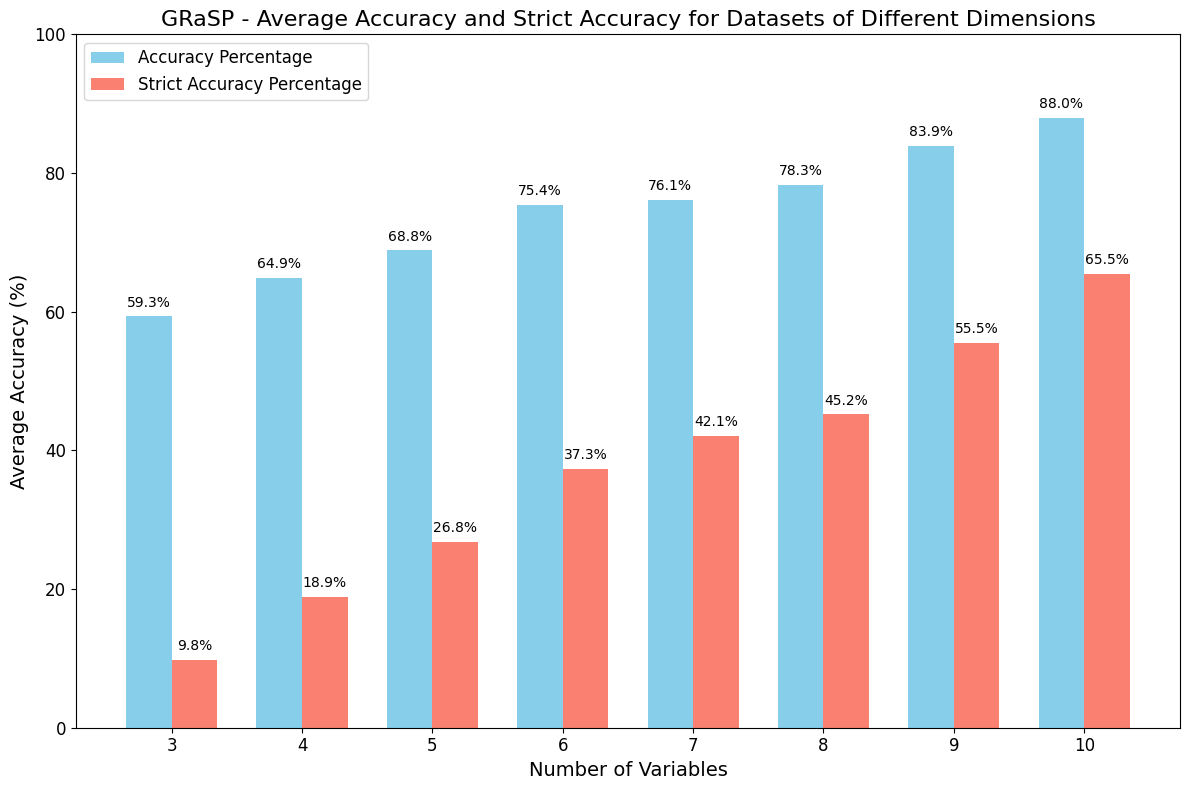

In [21]:
plot_average_accuracy(evaluation_results, 'GRaSP')

## 处理nolinear-ExactSearch

In [14]:
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v9.3_PC+ES-more.csv')
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 86)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [15]:
"""
'ExactSearch(v-sq,X)', 'ExactSearch(X,v-sq)', 'ExactSearch(v-sq,Y)', 'ExactSearch(Y,v-sq)',
'ExactSearch(v-cos,X)', 'ExactSearch(X,v-cos)', 'ExactSearch(v-cos,Y)', 'ExactSearch(Y,v-cos)', 
'ExactSearch(v-sin,X)', 'ExactSearch(X,v-sin)', 'ExactSearch(v-sin,Y)', 'ExactSearch(Y,v-sin)'
----->>>
'ExactSearch(v-nolinear,X)', 'ExactSearch(X,v-nolinear)', 'ExactSearch(v-nolinear,Y)', 'ExactSearch(Y,v-nolinear)'
"""
# 定义旧列名到新列名的映射
column_mapping = {
    'ExactSearch(v-nonlinear,X)': [
        'ExactSearch(v-sq,X)', 
        'ExactSearch(v-cos,X)', 
        'ExactSearch(v-sin,X)'
    ],
    'ExactSearch(X,v-nonlinear)': [
        'ExactSearch(X,v-sq)', 
        'ExactSearch(X,v-cos)', 
        'ExactSearch(X,v-sin)'
    ],
    'ExactSearch(v-nonlinear,Y)': [
        'ExactSearch(v-sq,Y)', 
        'ExactSearch(v-cos,Y)', 
        'ExactSearch(v-sin,Y)'
    ],
    'ExactSearch(Y,v-nonlinear)': [
        'ExactSearch(Y,v-sq)', 
        'ExactSearch(Y,v-cos)', 
        'ExactSearch(Y,v-sin)'
    ],
}
# 使用 .any(axis=1) 检查每行是否有任意一列为1
for new_col, old_cols in column_mapping.items():
    # 检查所有旧列是否存在于DataFrame中
    missing_cols = set(old_cols) - set(X_y_group_train.columns)
    if missing_cols:
        print(f"警告: 以下列不存在于DataFrame中并将被忽略: {missing_cols}")
        # 仅使用存在的列
        old_cols = [col for col in old_cols if col in X_y_group_train.columns]
    
    # 创建新列
    X_y_group_train[new_col] = X_y_group_train[old_cols].any(axis=1).astype(int)

In [16]:
# 收集所有旧列名
all_old_cols = [col for cols in column_mapping.values() for col in cols]

# 删除旧列（只删除存在于DataFrame中的列）
cols_to_drop = [col for col in all_old_cols if col in X_y_group_train.columns]
X_y_group_train = X_y_group_train.drop(columns=cols_to_drop)
X_y_group_train.to_csv('./mid_data/X_y_group_train_updated_v9.3_PC+ES-merge.csv', index=False)

: 

## psm

In [17]:
##################################################################
###################  Utility/Helper Functions  ###################
##################################################################
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

def get_propensity_scores(model, data, verbose = False):
    '''
    基于指定的逻辑回归模型计算倾向评分

    Parameters
    ----------
    model : string
        a model specification in the form Y ~ X1 + X2 + ... + Xn
    data : Pandas DataFrame
        the data used to calculate propensity scores
    verbose : boolean
        verbosity of the model output

    Returns
    -------
    An array of propensity scores.
    '''
    glm_binom = smf.glm(formula = model, data = data, family = sm.families.Binomial())
    result = glm_binom.fit()
    if verbose:
        print(result.summary)
    return result.fittedvalues

def flatten_match_ids(df):
    '''
    Converts a Pandas DataFrame of matched IDs into a list of those IDs.

    Parameters
    ----------
    df : Pandas Dataframe
        a dataframe consisting of 1 column of treated/case IDs and n columns
        of respective control(s) matched

    Returns
    -------
    A list of treated case and matched control IDs.
    '''
    master_list = []
    master_list.append(df[df.columns[0]].tolist())
    for i in range(1, df.shape[1]):
        master_list.append(df[df.columns[i]].tolist())
    master_list = [item for sublist in master_list for item in sublist]
    return master_list

def get_matched_data(match_ids, raw_data):
    '''
    Subsets the raw data to include data only from the treated cases and
    their respective matched control(s).

    Parameters
    ----------
    match_ids : Pandas DataFrame
        a dataframe of treated case IDs and matched control(s)
    raw_data: Pandas DataFrame
        a dataframe of all of the raw data

    Returns
    -------
    A dataframe containing data only from treated cases and matched control(s).
    '''
    match_ids = flatten_match_ids(match_ids)
    matched_data = raw_data[raw_data.index.isin(match_ids)]
    return matched_data

####################################################
###################  Base Class  ###################
####################################################

class PSMatch(object):
    '''
    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset to be used for propensity score matching.
    model : string
        The model specification for calculating propensity scores; in the format T ~ X1 + X2 + ... + Xn
    k : string
        The number of controls to be matched to each treated case.
    '''

    def __init__(self, dataset, Y_col, T_col, k):
        self.dataset = dataset
        self.Y_col = Y_col
        self.T_col = T_col
        self.X_col = [col for col in dataset.columns if col not in [Y_col, T_col]]
        self.model = f"{self.T_col} ~ {' + '.join(self.X_col)}"
        self.k = int(k)

    def prepare_data(self, **kwargs):
        '''
        计算倾向得分

        Returns
        -------
        A Pandas DataFrame containing raw data plus a column of propensity scores.
        '''
        df = self.dataset.copy()
        # 生成ID列
        df['ID'] = range(1, len(df) + 1)
        df = df.set_index('ID')
        # 将T_col从连续变量处理成0/1变量，按照median划分
        df[self.T_col] = df[self.T_col].apply(lambda x: int(1) if x >= df[self.T_col].median() else int(0))
        # 计算倾向得分
        print("\nCalculating propensity scores ...", end = " ")
        propensity_scores = get_propensity_scores(model = self.model, data = df, verbose = False)
        print("Preparing data ...", end = " ")
        df["PROPENSITY"] = propensity_scores
        self.df = df

    def match(self, caliper = None, replace = False, **kwargs):
        '''
        执行倾向得分匹配

        Returns
        -------
        matches : Pandas DataFrame
            the Match object attribute describing which control IDs are matched
            to a particular treatment case.
        matched_data: Pandas DataFrame
            the Match object attribute containing the raw data for only treatment
            cases and their matched controls.
        '''
        # 检查df是否已经初始化
        if not hasattr(self, 'df'):
            raise AttributeError("%s does not have a 'df' attribute." % (self))

        # 获取倾向得分
        groups = self.df[f'{self.T_col}']
        propensity = self.df['PROPENSITY']
        # 处理组
        g_t1 = propensity[groups==1]
        # 控制组
        g_t0 = propensity[groups==0]

        # 随机打乱T=1组的索引ID
        m_order = list(np.random.permutation(groups[groups==1].index))
        matches = {}
        k = int(self.k)

        # 基于倾向得分差异进行匹配
        print("\nMatching [" + str(k) + "] controls to each case ... ", end = " ")
        for m in m_order:
            # 计算得分差异
            difference = abs(g_t1[m]-g_t0)
            difference_array = np.array(difference)
            # 选取k个最小的得分差异
            k_smallest = np.partition(difference_array, k)[:k].tolist()
            if caliper:  # 如果设置了阈值
                caliper = float(caliper)
                keep_diffs = [i for i in k_smallest if i <= caliper]
                keep_ids = np.array(difference[difference.isin(keep_diffs)].index)
            else:
                keep_ids = np.array(difference[difference.isin(k_smallest)].index)

            # 如果匹配数大于k，随机选择k个
            if len(keep_ids) > k:
                matches[m] = list(np.random.choice(keep_ids, k, replace=False))
            elif len(keep_ids) < k:
                matches[m] = keep_ids.tolist()
                while len(matches[m]) < k:
                    matches[m].append("NA")
            else:
                matches[m] = keep_ids.tolist()

            # 不放回抽样
            if not replace:
                g_t0 = g_t0.drop(matches[m])

        # 将匹配结果转换为DataFrame
        matches = pd.DataFrame.from_dict(matches, orient="index")
        matches = matches.reset_index()
        column_names = {}
        column_names["index"] = "ID"
        for i in range(k):
            column_names[i] = str("CONTROL_MATCH_" + str(i+1))
        matches = matches.rename(columns = column_names)

        # 根据匹配结果获取匹配数据
        matched_data = get_matched_data(matches, self.df)
        # self.matches = matches
        self.matched_data = matched_data

    def evaluate(self, **kwargs):
        '''
        Conducts chi-square tests to verify statistically that the cases/controls
        are well-matched on the variables of interest.
        '''
        # 检查是否已进行匹配
        if not hasattr(self, 'matches'):
            raise AttributeError("%s does not have a 'matches' attribute." % (self))
        if not hasattr(self, 'matched_data'):
            raise AttributeError("%s does not have a 'matched_data' attribute." % (self))

        matched_data = self.matched_data
        y_t1 = matched_data[matched_data[f'{self.T_col}'] == 1][f'{self.Y_col}'].values.tolist()
        y_t0 = matched_data[matched_data[f'{self.T_col}'] == 0][f'{self.Y_col}'].values

        KL = stats.entropy(y_t0, y_t1)

        return KL

    def run(self, **kwargs):
        self.prepare_data()
        self.match()
        KL = self.evaluate()
        return KL

In [2]:
import pandas as pd
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')
print(len(X_train), len(y_train))

23500 23500


In [3]:
# Example usage
A = X_train['00000'].copy()
B = y_train['00000'].copy()

In [6]:
variables = A.columns.drop(["X", "Y"]).tolist()
print(variables)

['0', '2', '3', '4', '5', '6', '7', '8']


In [18]:
match = PSMatch(A, 'X', '0', 3)
KL = match.run()
print(KL)


Calculating propensity scores ... 

PatsyError: numbers besides '0' and '1' are only allowed with **
    0 ~ Y + 2 + 3 + 4 + 5 + 6 + 7 + 8
            ^

## PPS

In [2]:
"""PPS"""

import numpy as np

from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, f1_score

import pandas as pd
from pandas.api.types import (
    is_numeric_dtype,
    is_bool_dtype,
    is_object_dtype,
    is_categorical_dtype,
    is_string_dtype,
    is_datetime64_any_dtype,
    is_timedelta64_dtype,
)


NOT_SUPPORTED_ANYMORE = "NOT_SUPPORTED_ANYMORE"
TO_BE_CALCULATED = -1


def _calculate_model_cv_score_(
    df, target, feature, task, cross_validation, random_seed, **kwargs
):
    "Calculates the mean model score based on cross-validation"
    # Sources about the used methods:
    # https://scikit-learn.org/stable/modules/tree.html
    # https://scikit-learn.org/stable/modules/cross_validation.html
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
    metric = task["metric_key"]
    model = task["model"]
    # shuffle the rows - this is important for cross-validation
    # because the cross-validation just takes the first n lines
    # if there is a strong pattern in the rows eg 0,0,0,0,1,1,1,1
    # then this will lead to problems because the first cv sees mostly 0 and the later 1
    # this approach might be wrong for timeseries because it might leak information
    df = df.sample(frac=1, random_state=random_seed, replace=False)

    # preprocess target
    if task["type"] == "classification":
        label_encoder = preprocessing.LabelEncoder()
        df[target] = label_encoder.fit_transform(df[target])
        target_series = df[target]
    else:
        target_series = df[target]

    # preprocess feature
    if _dtype_represents_categories(df[feature]):
        one_hot_encoder = preprocessing.OneHotEncoder()
        array = df[feature].__array__()
        sparse_matrix = one_hot_encoder.fit_transform(array.reshape(-1, 1))
        feature_input = sparse_matrix
    else:
        # reshaping needed because there is only 1 feature
        array = df[feature].values
        if not isinstance(array, np.ndarray):  # e.g Int64 IntegerArray
            array = array.to_numpy()
        feature_input = array.reshape(-1, 1)

    # Cross-validation is stratifiedKFold for classification, KFold for regression
    # CV on one core (n_job=1; default) has shown to be fastest
    scores = cross_val_score(
        model, feature_input, target_series.to_numpy(), cv=cross_validation, scoring=metric
    )

    return scores.mean()


def _normalized_mae_score(model_mae, naive_mae):
    "Normalizes the model MAE score, given the baseline score"
    # # Value range of MAE is [0, infinity), 0 is best
    # 10, 5 ==> 0 because worse than naive
    # 10, 20 ==> 0.5
    # 5, 20 ==> 0.75 = 1 - (mae/base_mae)
    if model_mae > naive_mae:
        return 0
    else:
        return 1 - (model_mae / naive_mae)


def _mae_normalizer(df, y, model_score, **kwargs):
    "In case of MAE, calculates the baseline score for y and derives the PPS."
    df["naive"] = df[y].median()
    baseline_score = mean_absolute_error(df[y].to_numpy(), df["naive"].to_numpy())  # true, pred

    ppscore = _normalized_mae_score(abs(model_score), baseline_score)
    return ppscore, baseline_score


def _normalized_f1_score(model_f1, baseline_f1):
    "Normalizes the model F1 score, given the baseline score"
    # # F1 ranges from 0 to 1
    # # 1 is best
    # 0.5, 0.7 ==> 0 because model is worse than naive baseline
    # 0.75, 0.5 ==> 0.5
    #
    if model_f1 < baseline_f1:
        return 0
    else:
        scale_range = 1.0 - baseline_f1  # eg 0.3
        f1_diff = model_f1 - baseline_f1  # eg 0.1
        return f1_diff / scale_range  # 0.1/0.3 = 0.33


def _f1_normalizer(df, y, model_score, random_seed):
    "In case of F1, calculates the baseline score for y and derives the PPS."
    label_encoder = preprocessing.LabelEncoder()
    df["truth"] = label_encoder.fit_transform(df[y])
    df["most_common_value"] = df["truth"].value_counts().index[0]
    random = df["truth"].sample(frac=1, random_state=random_seed)

    baseline_score = max(
        f1_score(df["truth"], df["most_common_value"], average="weighted"),
        f1_score(df["truth"], random, average="weighted"),
    )

    ppscore = _normalized_f1_score(model_score, baseline_score)
    return ppscore, baseline_score


VALID_CALCULATIONS = {
    "regression": {
        "type": "regression",
        "is_valid_score": True,
        "model_score": TO_BE_CALCULATED,
        "baseline_score": TO_BE_CALCULATED,
        "ppscore": TO_BE_CALCULATED,
        "metric_name": "mean absolute error",
        "metric_key": "neg_mean_absolute_error",
        "model": tree.DecisionTreeRegressor(),
        "score_normalizer": _mae_normalizer,
    },
    "classification": {
        "type": "classification",
        "is_valid_score": True,
        "model_score": TO_BE_CALCULATED,
        "baseline_score": TO_BE_CALCULATED,
        "ppscore": TO_BE_CALCULATED,
        "metric_name": "weighted F1",
        "metric_key": "f1_weighted",
        "model": tree.DecisionTreeClassifier(),
        "score_normalizer": _f1_normalizer,
    },
    "predict_itself": {
        "type": "predict_itself",
        "is_valid_score": True,
        "model_score": 1,
        "baseline_score": 0,
        "ppscore": 1,
        "metric_name": None,
        "metric_key": None,
        "model": None,
        "score_normalizer": None,
    },
    "target_is_constant": {
        "type": "target_is_constant",
        "is_valid_score": True,
        "model_score": 1,
        "baseline_score": 1,
        "ppscore": 0,
        "metric_name": None,
        "metric_key": None,
        "model": None,
        "score_normalizer": None,
    },
    "target_is_id": {
        "type": "target_is_id",
        "is_valid_score": True,
        "model_score": 0,
        "baseline_score": 0,
        "ppscore": 0,
        "metric_name": None,
        "metric_key": None,
        "model": None,
        "score_normalizer": None,
    },
    "feature_is_id": {
        "type": "feature_is_id",
        "is_valid_score": True,
        "model_score": 0,
        "baseline_score": 0,
        "ppscore": 0,
        "metric_name": None,
        "metric_key": None,
        "model": None,
        "score_normalizer": None,
    },
}

INVALID_CALCULATIONS = [
    "target_is_datetime",
    "target_data_type_not_supported",
    "empty_dataframe_after_dropping_na",
    "unknown_error",
]


def _dtype_represents_categories(series) -> bool:
    "Determines if the dtype of the series represents categorical values"
    return (
        is_bool_dtype(series)
        or is_object_dtype(series)
        or is_string_dtype(series)
        or is_categorical_dtype(series)
    )


def _determine_case_and_prepare_df(df, x, y, sample=5_000, random_seed=123):
    "Returns str with the name of the determined case based on the columns x and y"
    if x == y:
        return df, "predict_itself"

    df = df[[x, y]]
    # IDEA: log.warning when values have been dropped
    df = df.dropna()

    if len(df) == 0:
        return df, "empty_dataframe_after_dropping_na"
        # IDEA: show warning
        # raise Exception(
        #     "After dropping missing values, there are no valid rows left"
        # )

    df = _maybe_sample(df, sample, random_seed=random_seed)

    if _feature_is_id(df, x):
        return df, "feature_is_id"

    category_count = df[y].value_counts().count()
    if category_count == 1:
        # it is helpful to separate this case in order to save unnecessary calculation time
        return df, "target_is_constant"
    if _dtype_represents_categories(df[y]) and (category_count == len(df[y])):
        # it is important to separate this case in order to save unnecessary calculation time
        return df, "target_is_id"

    if _dtype_represents_categories(df[y]):
        return df, "classification"
    if is_numeric_dtype(df[y]):
        # this check needs to be after is_bool_dtype (which is part of _dtype_represents_categories) because bool is considered numeric by pandas
        return df, "regression"

    if is_datetime64_any_dtype(df[y]) or is_timedelta64_dtype(df[y]):
        # IDEA: show warning
        # raise TypeError(
        #     f"The target column {y} has the dtype {df[y].dtype} which is not supported. A possible solution might be to convert {y} to a string column"
        # )
        return df, "target_is_datetime"

    # IDEA: show warning
    # raise Exception(
    #     f"Could not infer a valid task based on the target {y}. The dtype {df[y].dtype} is not yet supported"
    # )  # pragma: no cover
    return df, "target_data_type_not_supported"


def _feature_is_id(df, x):
    "Returns Boolean if the feature column x is an ID"
    if not _dtype_represents_categories(df[x]):
        return False

    category_count = df[x].value_counts().count()
    return category_count == len(df[x])


def _maybe_sample(df, sample, random_seed=None):
    """
    Maybe samples the rows of the given df to have at most `sample` rows
    If sample is `None` or falsy, there will be no sampling.
    If the df has fewer rows than the sample, there will be no sampling.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe that might be sampled
    sample : int or `None`
        Number of rows to be sampled
    random_seed : int or `None`
        Random seed that is forwarded to pandas.DataFrame.sample as `random_state`

    Returns
    -------
    pandas.DataFrame
        DataFrame after potential sampling
    """
    if sample and len(df) > sample:
        # this is a problem if x or y have more than sample=5000 categories
        # TODO: dont sample when the problem occurs and show warning
        df = df.sample(sample, random_state=random_seed, replace=False)
    return df


def _is_column_in_df(column, df):
    try:
        return column in df.columns
    except:
        return False


def _score(
    df, x, y, task, sample, cross_validation, random_seed, invalid_score, catch_errors
):
    df, case_type = _determine_case_and_prepare_df(
        df, x, y, sample=sample, random_seed=random_seed
    )
    task = _get_task(case_type, invalid_score)

    if case_type in ["classification", "regression"]:
        model_score = _calculate_model_cv_score_(
            df,
            target=y,
            feature=x,
            task=task,
            cross_validation=cross_validation,
            random_seed=random_seed,
        )
        # IDEA: the baseline_scores do sometimes change significantly, e.g. for F1 and thus change the PPS
        # we might want to calculate the baseline_score 10 times and use the mean in order to have less variance
        ppscore, baseline_score = task["score_normalizer"](
            df, y, model_score, random_seed=random_seed
        )
    else:
        model_score = task["model_score"]
        baseline_score = task["baseline_score"]
        ppscore = task["ppscore"]

    return {
        "x": x,
        "y": y,
        "ppscore": ppscore,
        "case": case_type,
        "is_valid_score": task["is_valid_score"],
        "metric": task["metric_name"],
        "baseline_score": baseline_score,
        "model_score": abs(model_score),  # sklearn returns negative mae
        "model": task["model"],
    }


def pps_score(
    df,
    x,
    y,
    task=NOT_SUPPORTED_ANYMORE,
    sample=5_000,
    cross_validation=4,
    random_seed=123,
    invalid_score=0,
    catch_errors=True,
):
    """
    Calculate the Predictive Power Score (PPS) for "x predicts y"
    The score always ranges from 0 to 1 and is data-type agnostic.

    A score of 0 means that the column x cannot predict the column y better than a naive baseline model.
    A score of 1 means that the column x can perfectly predict the column y given the model.
    A score between 0 and 1 states the ratio of how much potential predictive power the model achieved compared to the baseline model.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe that contains the columns x and y
    x : str
        Name of the column x which acts as the feature
    y : str
        Name of the column y which acts as the target
    sample : int or `None`
        Number of rows for sampling. The sampling decreases the calculation time of the PPS.
        If `None` there will be no sampling.
    cross_validation : int
        Number of iterations during cross-validation. This has the following implications:
        For example, if the number is 4, then it is possible to detect patterns when there are at least 4 times the same observation. If the limit is increased, the required minimum observations also increase. This is important, because this is the limit when sklearn will throw an error and the PPS cannot be calculated
    random_seed : int or `None`
        Random seed for the parts of the calculation that require random numbers, e.g. shuffling or sampling.
        If the value is set, the results will be reproducible. If the value is `None` a new random number is drawn at the start of each calculation.
    invalid_score : any
        The score that is returned when a calculation is invalid, e.g. because the data type was not supported.
    catch_errors : bool
        If `True` all errors will be catched and reported as `unknown_error` which ensures convenience. If `False` errors will be raised. This is helpful for inspecting and debugging errors.

    Returns
    -------
    Dict
        A dict that contains multiple fields about the resulting PPS.
        The dict enables introspection into the calculations that have been performed under the hood
    """

    if not isinstance(df, pd.DataFrame):
        raise TypeError(
            f"The 'df' argument should be a pandas.DataFrame but you passed a {type(df)}\nPlease convert your input to a pandas.DataFrame"
        )
    if not _is_column_in_df(x, df):
        raise ValueError(
            f"The 'x' argument should be the name of a dataframe column but the variable that you passed is not a column in the given dataframe.\nPlease review the column name or your dataframe"
        )
    if len(df[[x]].columns) >= 2:
        raise AssertionError(
            f"The dataframe has {len(df[[x]].columns)} columns with the same column name {x}\nPlease adjust the dataframe and make sure that only 1 column has the name {x}"
        )
    if not _is_column_in_df(y, df):
        raise ValueError(
            f"The 'y' argument should be the name of a dataframe column but the variable that you passed is not a column in the given dataframe.\nPlease review the column name or your dataframe"
        )
    if len(df[[y]].columns) >= 2:
        raise AssertionError(
            f"The dataframe has {len(df[[y]].columns)} columns with the same column name {y}\nPlease adjust the dataframe and make sure that only 1 column has the name {y}"
        )
    if task is not NOT_SUPPORTED_ANYMORE:
        raise AttributeError(
            "The attribute 'task' is no longer supported because it led to confusion and inconsistencies.\nThe task of the model is now determined based on the data types of the columns. If you want to change the task please adjust the data type of the column.\nFor more details, please refer to the README"
        )

    if random_seed is None:
        from random import random

        random_seed = int(random() * 1000)

    try:
        return _score(
            df,
            x,
            y,
            task,
            sample,
            cross_validation,
            random_seed,
            invalid_score,
            catch_errors,
        )
    except Exception as exception:
        if catch_errors:
            case_type = "unknown_error"
            task = _get_task(case_type, invalid_score)
            return {
                "x": x,
                "y": y,
                "ppscore": task["ppscore"],
                "case": case_type,
                "is_valid_score": task["is_valid_score"],
                "metric": task["metric_name"],
                "baseline_score": task["baseline_score"],
                "model_score": task["model_score"],  # sklearn returns negative mae
                "model": task["model"],
            }
        else:
            raise exception


def _get_task(case_type, invalid_score):
    if case_type in VALID_CALCULATIONS.keys():
        return VALID_CALCULATIONS[case_type]
    elif case_type in INVALID_CALCULATIONS:
        return {
            "type": case_type,
            "is_valid_score": False,
            "model_score": invalid_score,
            "baseline_score": invalid_score,
            "ppscore": invalid_score,
            "metric_name": None,
            "metric_key": None,
            "model": None,
            "score_normalizer": None,
        }
    raise Exception(f"case_type {case_type} is not supported")


def _format_list_of_dicts(scores, output, sorted):
    """
    Format list of score dicts `scores`
    - maybe sort by ppscore
    - maybe return pandas.Dataframe
    - output can be one of ["df", "list"]
    """
    if sorted:
        scores.sort(key=lambda item: item["ppscore"], reverse=True)

    if output == "df":
        df_columns = [
            "x",
            "y",
            "ppscore",
            "case",
            "is_valid_score",
            "metric",
            "baseline_score",
            "model_score",
            "model",
        ]
        data = {column: [score[column] for score in scores] for column in df_columns}
        scores = pd.DataFrame.from_dict(data)

    return scores


def pps_predictors(df, y, output="df", sorted=True, **kwargs):
    """
    Calculate the Predictive Power Score (PPS) of all the features in the dataframe
    against a target column

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe that contains the data
    y : str
        Name of the column y which acts as the target
    output: str - potential values: "df", "list"
        Control the type of the output. Either return a pandas.DataFrame (df) or a list with the score dicts
    sorted: bool
        Whether or not to sort the output dataframe/list by the ppscore
    kwargs:
        Other key-word arguments that shall be forwarded to the pps.score method,
        e.g. `sample, `cross_validation, `random_seed, `invalid_score`, `catch_errors`

    Returns
    -------
    pandas.DataFrame or list of Dict
        Either returns a tidy dataframe or a list of all the PPS dicts. This can be influenced
        by the output argument
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError(
            f"The 'df' argument should be a pandas.DataFrame but you passed a {type(df)}\nPlease convert your input to a pandas.DataFrame"
        )
    if not _is_column_in_df(y, df):
        raise ValueError(
            f"The 'y' argument should be the name of a dataframe column but the variable that you passed is not a column in the given dataframe.\nPlease review the column name or your dataframe"
        )
    if len(df[[y]].columns) >= 2:
        raise AssertionError(
            f"The dataframe has {len(df[[y]].columns)} columns with the same column name {y}\nPlease adjust the dataframe and make sure that only 1 column has the name {y}"
        )
    if not output in ["df", "list"]:
        raise ValueError(
            f"""The 'output' argument should be one of ["df", "list"] but you passed: {output}\nPlease adjust your input to one of the valid values"""
        )
    if not sorted in [True, False]:
        raise ValueError(
            f"""The 'sorted' argument should be one of [True, False] but you passed: {sorted}\nPlease adjust your input to one of the valid values"""
        )

    scores = [pps_score(df, column, y, **kwargs) for column in df if column != y]

    return _format_list_of_dicts(scores=scores, output=output, sorted=sorted)


def pps_matrix(df, output="df", sorted=False, **kwargs):
    """
    Calculate the Predictive Power Score (PPS) matrix for all columns in the dataframe

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe that contains the data
    output: str - potential values: "df", "list"
        Control the type of the output. Either return a pandas.DataFrame (df) or a list with the score dicts
    sorted: bool
        Whether or not to sort the output dataframe/list by the ppscore
    kwargs:
        Other key-word arguments that shall be forwarded to the pps.score method,
        e.g. `sample, `cross_validation, `random_seed, `invalid_score`, `catch_errors`

    Returns
    -------
    pandas.DataFrame or list of Dict
        Either returns a tidy dataframe or a list of all the PPS dicts. This can be influenced
        by the output argument
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError(
            f"The 'df' argument should be a pandas.DataFrame but you passed a {type(df)}\nPlease convert your input to a pandas.DataFrame"
        )
    if not output in ["df", "list"]:
        raise ValueError(
            f"""The 'output' argument should be one of ["df", "list"] but you passed: {output}\nPlease adjust your input to one of the valid values"""
        )
    if not sorted in [True, False]:
        raise ValueError(
            f"""The 'sorted' argument should be one of [True, False] but you passed: {sorted}\nPlease adjust your input to one of the valid values"""
        )

    scores = [pps_score(df, x, y, **kwargs) for x in df for y in df]

    return _format_list_of_dicts(scores=scores, output=output, sorted=sorted)

In [1]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [3]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

In [4]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [10]:
score_dict = pps_score(A, "X", "Y", sample=None, cross_validation=4, random_seed=42)
print(score_dict)

{'x': 'X', 'y': 'Y', 'ppscore': 0.20120000000000005, 'case': 'regression', 'is_valid_score': True, 'metric': 'mean absolute error', 'baseline_score': 0.5, 'model_score': 0.3994, 'model': DecisionTreeRegressor()}


In [5]:
# 计算所有特征对目标列 'y' 的 PPS，并返回一个排序后的 DataFrame
result_df = pps_predictors(A, "Y", sorted=True, sample=None, cross_validation=4, random_seed=42)
print(result_df)

   x  y   ppscore        case  is_valid_score               metric  \
0  X  Y  0.201200  regression            True  mean absolute error   
1  7  Y  0.164936  regression            True  mean absolute error   
2  8  Y  0.105212  regression            True  mean absolute error   
3  0  Y  0.000000  regression            True  mean absolute error   
4  2  Y  0.000000  regression            True  mean absolute error   
5  3  Y  0.000000  regression            True  mean absolute error   
6  4  Y  0.000000  regression            True  mean absolute error   
7  5  Y  0.000000  regression            True  mean absolute error   
8  6  Y  0.000000  regression            True  mean absolute error   

   baseline_score  model_score                    model  
0             0.5     0.399400  DecisionTreeRegressor()  
1             0.5     0.417532  DecisionTreeRegressor()  
2             0.5     0.447394  DecisionTreeRegressor()  
3             0.5     0.648268  DecisionTreeRegressor()  
4        

In [9]:
selected_value = result_df.loc[result_df['x'] == '7', 'ppscore']
print(selected_value)

1    0.164936
Name: ppscore, dtype: float64


In [12]:
# 计算所有特征两两之间的 PPS 矩阵
matrix_df = pps_matrix(A)
print(matrix_df)

    x  y  ppscore            case  is_valid_score               metric  \
0   0  0  1.00000  predict_itself            True                 None   
1   0  Y  0.00000      regression            True  mean absolute error   
2   0  2  0.00000      regression            True  mean absolute error   
3   0  3  0.11196      regression            True  mean absolute error   
4   0  4  0.00000      regression            True  mean absolute error   
.. .. ..      ...             ...             ...                  ...   
95  X  5  0.00000      regression            True  mean absolute error   
96  X  6  0.00000      regression            True  mean absolute error   
97  X  7  0.00000      regression            True  mean absolute error   
98  X  8  0.00000      regression            True  mean absolute error   
99  X  X  1.00000  predict_itself            True                 None   

    baseline_score  model_score                    model  
0              0.0     1.000000                     

: 

In [8]:
pivot_df = pd.pivot_table(matrix_df, index='x', columns='y', values='ppscore')
print(pivot_df)

y         0    2         3    4         5    6         7         8        X  \
x                                                                             
0  1.000000  0.0  0.111960  0.0  0.196496  0.0  0.000000  0.000000  0.00000   
2  0.000000  1.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.00000   
3  0.122136  0.0  1.000000  0.0  0.218164  0.0  0.000000  0.000000  0.00000   
4  0.000000  0.0  0.000000  1.0  0.000000  0.0  0.000000  0.000000  0.00000   
5  0.194052  0.0  0.189532  0.0  1.000000  0.0  0.000000  0.000000  0.00000   
6  0.000000  0.0  0.000000  0.0  0.000000  1.0  0.000000  0.000000  0.00000   
7  0.000000  0.0  0.000000  0.0  0.000000  0.0  1.000000  0.278608  0.00000   
8  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.283364  1.000000  0.00000   
X  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000  1.00000   
Y  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.167000  0.133652  0.19474   

y         Y  
x            
0  0.000000  
2  0.0000

## 处理PC ES FCI

In [2]:
import pandas as pd

In [3]:
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v9.4_PC+ES+FCI.csv')
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 79)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [4]:
X_y_group_train_ES = X_y_group_train.drop(columns=['PC(v,X)', 'PC(X,v)', 'PC(v,Y)', 'PC(Y,v)', 'PC(X,Y)', 
                                                   'FCI(v,X)', 'FCI(X,v)', 'FCI(v,Y)', 'FCI(Y,v)', 'FCI(X,Y)'])
print(X_y_group_train_ES.shape)
print(X_y_group_train_ES.columns)

(142910, 69)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [5]:
X_y_group_train_ES.to_csv('./mid_data/X_y_group_train_updated_v9.4.1_ES.csv', index=False)

In [7]:
X_y_group_train_ES_PC = X_y_group_train.drop(columns=['FCI(v,X)', 'FCI(X,v)', 'FCI(v,Y)', 'FCI(Y,v)', 'FCI(X,Y)'])
order = ['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(spearman_corr(v, others))',
       'max(kendall_corr(v, others))', 'min(kendall_corr(v, others))',
       'mean(kendall_corr(v, others))', 'std(kendall_corr(v, others))',
       'partial_corr(v,X|Y)', 'partial_corr(v,Y|X)', 'partial_corr(X,Y|v)',
       'v~Y_coefficient', 'v_squared~Y_coefficient', 'v~X_coefficient',
       'v_squared~X_coefficient', 'v_cos~X_coefficient', 'v_sin~X_coefficient',
       'X~Y_coefficient', 'v~Y_ridge_coefficient', 'v~X_ridge_coefficient',
       'X~Y_ridge_coefficient', 'ExactSearch(v,X)', 'ExactSearch(X,v)', 'ExactSearch(v,Y)',
       'ExactSearch(Y,v)', 'ExactSearch(X,Y)', 'PC(v,X)', 'PC(X,v)', 'PC(v,Y)', 'PC(Y,v)',
       'PC(X,Y)']
X_y_group_train_ES_PC = X_y_group_train_ES_PC[order]
print(X_y_group_train_ES_PC.shape)
print(X_y_group_train_ES_PC.columns)

(142910, 74)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [8]:
X_y_group_train_ES_PC.to_csv('./mid_data/X_y_group_train_updated_v9.4.2_ES+PC.csv', index=False)

In [9]:
X_y_group_train_ES_FCI = X_y_group_train.drop(columns=['PC(v,X)', 'PC(X,v)', 'PC(v,Y)', 'PC(Y,v)', 'PC(X,Y)'])
order = ['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(spearman_corr(v, others))',
       'max(kendall_corr(v, others))', 'min(kendall_corr(v, others))',
       'mean(kendall_corr(v, others))', 'std(kendall_corr(v, others))',
       'partial_corr(v,X|Y)', 'partial_corr(v,Y|X)', 'partial_corr(X,Y|v)',
       'v~Y_coefficient', 'v_squared~Y_coefficient', 'v~X_coefficient',
       'v_squared~X_coefficient', 'v_cos~X_coefficient', 'v_sin~X_coefficient',
       'X~Y_coefficient', 'v~Y_ridge_coefficient', 'v~X_ridge_coefficient',
       'X~Y_ridge_coefficient', 'ExactSearch(v,X)', 'ExactSearch(X,v)', 'ExactSearch(v,Y)',
       'ExactSearch(Y,v)', 'ExactSearch(X,Y)', 'FCI(v,X)', 'FCI(X,v)', 'FCI(v,Y)', 'FCI(Y,v)', 'FCI(X,Y)']
X_y_group_train_ES_FCI = X_y_group_train_ES_FCI[order]
print(X_y_group_train_ES_FCI.shape)
print(X_y_group_train_ES_FCI.columns)

(142910, 74)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [10]:
X_y_group_train_ES_FCI.to_csv('./mid_data/X_y_group_train_updated_v9.4.3_ES+FCI.csv', index=False)

In [4]:
order = ['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(spearman_corr(v, others))',
       'max(kendall_corr(v, others))', 'min(kendall_corr(v, others))',
       'mean(kendall_corr(v, others))', 'std(kendall_corr(v, others))',
       'partial_corr(v,X|Y)', 'partial_corr(v,Y|X)', 'partial_corr(X,Y|v)',
       'v~Y_coefficient', 'v_squared~Y_coefficient', 'v~X_coefficient',
       'v_squared~X_coefficient', 'v_cos~X_coefficient', 'v_sin~X_coefficient',
       'X~Y_coefficient', 'v~Y_ridge_coefficient', 'v~X_ridge_coefficient',
       'X~Y_ridge_coefficient', 'ExactSearch(v,X)', 'ExactSearch(X,v)', 'ExactSearch(v,Y)',
       'ExactSearch(Y,v)', 'ExactSearch(X,Y)', 'PC(v,X)', 'PC(X,v)', 'PC(v,Y)', 'PC(Y,v)', 'PC(X,Y)',
       'FCI(v,X)', 'FCI(X,v)', 'FCI(v,Y)', 'FCI(Y,v)', 'FCI(X,Y)']
X_y_group_train_ES_PC_FCI = X_y_group_train[order]
print(X_y_group_train_ES_PC_FCI.shape)
print(X_y_group_train_ES_PC_FCI.columns)

(142910, 79)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [5]:
X_y_group_train_ES_PC_FCI.to_csv('./mid_data/X_y_group_train_updated_v9.4.4_ES+PC+FCI.csv', index=False)

: 

## 处理PPS

In [1]:
import pandas as pd

In [2]:
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v9.4_ES+PC+FCI.csv')
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 79)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [3]:
X_y_group_train_PPS = pd.read_csv('./mid_data/X_y_group_train_updated_v10.1_PPS.csv')
print(X_y_group_train_PPS.shape)
print(X_y_group_train_PPS.columns)

(142910, 81)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [4]:
X_y_group_train[['PPS(v,X)', 'PPS(X,v)', 'PPS(v,Y)', 'PPS(Y,v)', 'PPS(X,Y)', 'max(PPS(v,others))', 'mean(PPS(v,others))']] = X_y_group_train_PPS[['PPS(v,X)', 'PPS(X,v)', 'PPS(v,Y)', 'PPS(Y,v)', 'PPS(X,Y)', 'max(PPS(v,others))', 'mean(PPS(v,others))']]
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 86)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [5]:
X_y_group_train.to_csv('./mid_data/X_y_group_train_updated_v10.1_PPS.csv', index=False)

## 处理Copula

In [6]:
import pandas as pd

In [7]:
X_y_group_train = pd.read_csv('./mid_data/X_y_group_train_updated_v10.1_PPS.csv')
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 86)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [8]:
X_y_group_train_copula = pd.read_csv('./mid_data/X_y_group_train_updated_v10.2_copula.csv')
print(X_y_group_train_copula.shape)
print(X_y_group_train_copula.columns)

(142910, 77)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [9]:
X_y_group_train[['copula_entropy(v,X)', 'copula_entropy(v,Y)', 'copula_entropy(X,Y)']] = X_y_group_train_copula[['copula_entropy(v,X)', 'copula_entropy(v,Y)', 'copula_entropy(X,Y)']]
print(X_y_group_train.shape)
print(X_y_group_train.columns)

(142910, 89)
Index(['dataset', 'variable', 'dimension', 'corr(v,X)', 'corr(v,Y)',
       'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))',
       'std(corr(v, others))', 'corr(X,Y)', 'ttest(v,X)',
       'pvalue(ttest(v,X))<=0.05', 'ttest(v,Y)', 'pvalue(ttest(v,Y))<=0.05',
       'ttest(X,Y)', 'pvalue(ttest(X,Y))<=0.05', 'MI(v,X)', 'MI(v,Y)',
       'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))',
       'std(MI(v, others))', 'MI(X,Y)', 'label', 'y', 'spearman_corr(v,X)',
       'spearman_corr(v,Y)', 'spearman_corr(X,Y)', 'kendall_corr(v,X)',
       'kendall_corr(v,Y)', 'kendall_corr(X,Y)', 'dcor(v,X)', 'dcor(v,Y)',
       'dcor(X,Y)', 'MI(v,X)^2', 'MI(v,Y)^2', 'MI(X,Y)^2',
       'max(MI(v, others))^2', 'min(MI(v, others))^2', 'conditional_MI(v,X|Y)',
       'conditional_MI(v,Y|X)', 'conditional_MI(X,Y|v)', 'square_dimension',
       'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))',
       'mean(spearman_corr(v, others))', 'std(

In [10]:
X_y_group_train.to_csv('./mid_data/X_y_group_train_updated_v10.2_PPS+copula.csv', index=False)

## MIC

In [1]:
import numpy as np
import logging
import sys

class CyrusMIC(object):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    screen_handler = logging.StreamHandler(sys.stdout)
    screen_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(module)s.%(funcName)s:%(lineno)d - %(levelname)s - %(message)s')
    screen_handler.setFormatter(formatter)
    logger.addHandler(screen_handler)
    def __init__(self,x_num=[None,None],y_num=[None,None]):
        self.x_max_num = x_num[1]
        self.x_min_num = x_num[0]
        self.y_min_num = y_num[0]
        self.y_max_num = y_num[1]

        self.x = None
        self.y = None

    def cal_mut_info(self,p_matrix):
        """
        计算互信息值
        :param p_matrix: 变量X和Y的构成的概率矩阵
        :return: 互信息值
        """
        mut_info = 0
        p_matrix = np.array(p_matrix)
        for i in range(p_matrix.shape[0]):
            for j in range(p_matrix.shape[1]):
                if p_matrix[i,j] != 0:
                    mut_info += p_matrix[i,j]*np.log2(p_matrix[i,j]/(p_matrix[i,:].sum()*p_matrix[:,j].sum()))
        self.logger.info("信息系数为：{}".format(mut_info/np.log2(min(p_matrix.shape[0],p_matrix.shape[1]))))
        return mut_info/np.log2(min(p_matrix.shape[0],p_matrix.shape[1]))

    def divide_bin(self,x_num,y_num):
        """
        指定在两个变量方向上需划分的网格数，返回概率矩阵
        :param x_num:
        :param y_num:
        :return: p_matrix
        """
        p_matrix = np.zeros([x_num,y_num])
        x_bin = np.linspace(self.x.min(),self.x.max()+1,x_num+1)
        y_bin = np.linspace(self.y.min(),self.y.max()+1,y_num+1)
        for i in range(x_num):
            for j in range(y_num):
                p_matrix[i,j] = sum([1 if (self.x[value] < x_bin[i + 1] and self.x[value] >= x_bin[i] and self.y[value] < y_bin[j + 1] and
                      self.y[value] >= y_bin[j]) else 0 for value in range(self.x.shape[0])])/self.x.shape[0]
        return p_matrix

    def cal_MIC(self,x,y):
        self.x = np.array(x).reshape((-1,))
        self.y = np.array(y).reshape((-1,))
        if not self.x_max_num:
            self.x_max_num = int(round(self.x.shape[0]**0.3,0))
            self.y_max_num = self.x_max_num
            self.x_min_num = 2
            self.y_min_num = 2
        mics = []
        for i in range(self.x_min_num,self.x_max_num+1):
            for j in range(self.y_min_num,self.x_max_num+1):
                self.logger.info("划分区间数量为：[{},{}]".format(i,j))
                mics.append(self.cal_mut_info(self.divide_bin(i,j)))
        self.logger.info("最大信息系数为:{}".format(max(mics)))
        return max(mics)

In [2]:
import crunch
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data()

loaded inline runner with module: <module '__main__'>
download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exist

In [3]:
# Example usage
A = X_train['00000'].copy()
print(A)
B = y_train['00000'].copy()
print(B)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

In [5]:
mic_tool = CyrusMIC()
mic_tool.cal_MIC(A['5'], A['0'])

2024-10-05 15:49:08,813 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,2]
2024-10-05 15:49:08,816 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.12255624891826566
2024-10-05 15:49:08,819 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,3]
2024-10-05 15:49:08,822 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.22027949261828803
2024-10-05 15:49:08,823 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,4]
2024-10-05 15:49:08,827 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.27430581714530483
2024-10-05 15:49:08,830 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,5]
2024-10-05 15:49:08,837 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.2917515892483302
2024-10-05 15:49:08,838 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,6]
2024-10-05 15:49:08,845 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.29414132864746895
2024-10-05 15:49:08,848 - 1585741204.cal_MIC:64 - INFO - 划分区间数量为：[2,7]
2024-10-05 15:49:08,856 - 1585741204.cal_mut_info:34 - INFO - 信息系数为：0.31621760445703406
2024-10-05 15:49:08,858 - 1585741204.cal_MIC:64

0.31716408157928133

In [16]:
import numpy as np
import pandas as pd

class MIC_by_GU(object):
    def __init__(self, x_num=[None, None], y_num=[None, None]):
        self.x_max_num = x_num[1]
        self.x_min_num = x_num[0]
        self.y_min_num = y_num[0]
        self.y_max_num = y_num[1]

        self.x = None
        self.y = None

    def cal_mut_info(self, p_matrix):
        """
        计算互信息值
        :param p_matrix: 变量X和Y的构成的概率矩阵
        :return: 互信息值
        """
        mut_info = 0
        p_matrix = np.array(p_matrix)
        for i in range(p_matrix.shape[0]):
            for j in range(p_matrix.shape[1]):
                if p_matrix[i, j] != 0:
                    mut_info += p_matrix[i, j] * np.log2(
                        p_matrix[i, j] / (p_matrix[i, :].sum() * p_matrix[:, j].sum())
                    )
        return mut_info / np.log2(min(p_matrix.shape[0], p_matrix.shape[1]))

    def divide_bin(self, x_num, y_num):
        """
        指定在两个变量方向上需划分的网格数，返回概率矩阵
        :param x_num:
        :param y_num:
        :return: p_matrix
        """
        p_matrix = np.zeros([x_num, y_num])
        x_bin = np.linspace(self.x.min(), self.x.max() + 1, x_num + 1)
        y_bin = np.linspace(self.y.min(), self.y.max() + 1, y_num + 1)
        for i in range(x_num):
            for j in range(y_num):
                p_matrix[i, j] = sum(
                    [
                        1
                        if (
                            self.x[value] < x_bin[i + 1]
                            and self.x[value] >= x_bin[i]
                            and self.y[value] < y_bin[j + 1]
                            and self.y[value] >= y_bin[j]
                        )
                        else 0
                        for value in range(self.x.shape[0])
                    ]
                ) / self.x.shape[0]
        return p_matrix

    def cal_MIC(self, x, y):
        """
        计算两个变量之间的MIC
        :param x: 第一个变量的数据
        :param y: 第二个变量的数据
        :return: MIC值
        """
        self.x = np.array(x).reshape((-1,))
        self.y = np.array(y).reshape((-1,))
        if not self.x_max_num:
            self.x_max_num = int(round(self.x.shape[0] ** 0.3, 0))
            self.y_max_num = self.x_max_num
            self.x_min_num = 2
            self.y_min_num = 2
        max_mic = -np.inf  # 初始化为负无穷大
        best_grid = (None, None)  # 初始化最佳网格参数

        # 遍历所有可能的网格划分组合
        for i in range(self.x_min_num, self.x_max_num + 1):
            for j in range(self.y_min_num, self.y_max_num + 1):
                p_matrix = self.divide_bin(i, j)
                mic = self.cal_mut_info(p_matrix)
                # 更新最大MIC及对应的网格参数
                if mic > max_mic:
                    max_mic = mic
                    best_grid = (i, j)

        # 打印出使MIC达到最大值的网格参数
        print(f"最大MIC值: {max_mic:.4f}, 最佳网格参数: X网格数={best_grid[0]}, Y网格数={best_grid[1]}")
        return max_mic

    def cal_MIC_for_df(self, df):
        """
        计算数据框中每对列之间的MIC，并返回一个对称的方阵数据框
        :param df: 输入的数据框，包含多个列
        :return: 包含MIC值的对称方阵数据框，主对角线为1
        """
        columns = df.columns
        num_cols = len(columns)
        # 初始化MIC矩阵为全零
        mic_matrix = np.zeros((num_cols, num_cols))
        # 设置主对角线为1
        np.fill_diagonal(mic_matrix, 1)

        # 遍历每对列，计算MIC
        for i in range(num_cols):
            for j in range(i + 1, num_cols):
                mic = self.cal_MIC(df.iloc[:, i], df.iloc[:, j])
                mic_matrix[i, j] = mic
                mic_matrix[j, i] = mic  # 对称赋值

        # 创建结果数据框
        mic_df = pd.DataFrame(mic_matrix, index=columns, columns=columns)
        return mic_df

In [22]:
mic_tool = MIC_by_GU(x_num=[2, 12], y_num=[2, 12])
mic_tool.cal_MIC(A['5'], A['0'])

最大MIC值: 0.3252, 最佳网格参数: X网格数=2, Y网格数=12


0.32518058108540215

In [8]:
mic_tool.cal_MIC(A['0'], A['5'])

0.3171640815792813

In [23]:
mic_matrix_df = mic_tool.cal_MIC_for_df(A)
print(mic_matrix_df)

最大MIC值: 0.0392, 最佳网格参数: X网格数=8, Y网格数=12
最大MIC值: 0.0127, 最佳网格参数: X网格数=11, Y网格数=12
最大MIC值: 0.2483, 最佳网格参数: X网格数=11, Y网格数=3
最大MIC值: 0.0169, 最佳网格参数: X网格数=12, Y网格数=5
最大MIC值: 0.3252, 最佳网格参数: X网格数=12, Y网格数=2
最大MIC值: 0.1168, 最佳网格参数: X网格数=12, Y网格数=2
最大MIC值: 0.0144, 最佳网格参数: X网格数=10, Y网格数=12
最大MIC值: 0.0208, 最佳网格参数: X网格数=11, Y网格数=11
最大MIC值: 0.0356, 最佳网格参数: X网格数=12, Y网格数=2
最大MIC值: 0.0185, 最佳网格参数: X网格数=11, Y网格数=10
最大MIC值: 0.0478, 最佳网格参数: X网格数=10, Y网格数=2
最大MIC值: 0.0224, 最佳网格参数: X网格数=11, Y网格数=2
最大MIC值: 0.1284, 最佳网格参数: X网格数=2, Y网格数=12
最大MIC值: 0.0340, 最佳网格参数: X网格数=2, Y网格数=11
最大MIC值: 0.2515, 最佳网格参数: X网格数=2, Y网格数=11
最大MIC值: 0.2410, 最佳网格参数: X网格数=2, Y网格数=12
最大MIC值: 0.3188, 最佳网格参数: X网格数=2, Y网格数=11
最大MIC值: 0.0134, 最佳网格参数: X网格数=11, Y网格数=11
最大MIC值: 0.0141, 最佳网格参数: X网格数=11, Y网格数=12
最大MIC值: 0.0191, 最佳网格参数: X网格数=11, Y网格数=11
最大MIC值: 0.0107, 最佳网格参数: X网格数=11, Y网格数=12
最大MIC值: 0.0249, 最佳网格参数: X网格数=10, Y网格数=5
最大MIC值: 0.0278, 最佳网格参数: X网格数=9, Y网格数=5
最大MIC值: 0.0143, 最佳网格参数: X网格数=11, Y网格数=11
最大MIC值: 0.0114, 最佳网格参数: X网格数=11,

: 

## gcastle

In [1]:
import pandas as pd
import numpy as np

In [2]:
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')

In [3]:
# Example usage
A = X_train['00000']
B = y_train['00000']
print(A)
print(B)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

### ANM

In [3]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import ANMNonlinear

2024-10-05 19:42:26,108 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-10-05 19:42:26,281 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [4]:
weighted_random_dag = DAG.erdos_renyi(n_nodes=6, n_edges=10, weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=1000, method='nonlinear', sem_type='gp-add')
true_dag, X = dataset.B, dataset.X

anm = ANMNonlinear(alpha=0.05)
anm.learn(data=X)

# plot predict_dag and true_dag
GraphDAG(anm.causal_matrix, true_dag)

mm = MetricsDAG(anm.causal_matrix, true_dag)
print(mm.metrics)

2024-10-05 19:31:00,543 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset


[[0 0 1 0 0 0]
 [1 0 1 1 1 1]
 [0 0 0 0 0 0]
 [0 0 1 0 1 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]]
[[-1.932  1.924  3.156  1.184  0.097  0.607]
 [ 1.053  0.991  5.57  -0.503 -0.101 -1.774]
 [ 0.546  0.381  2.866 -0.24  -1.224 -0.406]
 ...
 [ 3.949  0.169 -1.055  1.16   1.735 -1.935]
 [-1.689 -0.6   -0.568  0.795 -0.818  0.631]
 [-0.555  2.023  1.787  0.764  0.06   0.95 ]]


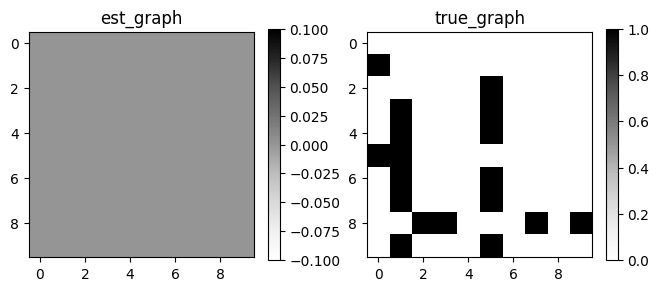

In [6]:
anm = ANMNonlinear(alpha=0.05)
anm.learn(data=A.values)

# plot predict_dag and true_dag
GraphDAG(anm.causal_matrix, B.values)

In [7]:
print(anm.causal_matrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### PNL

In [9]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import PNL

pc = PNL(alpha=0.05)
pc.learn(data=A.values)

# plot predict_dag and true_dag
GraphDAG(pc.causal_matrix, B.values)

# calculate accuracy
met = MetricsDAG(pc.causal_matrix, true_dag)
print(met.metrics)

2024-10-05 19:47:21,121 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\pnl\torch\pnl.py[line:135] - INFO: GPU is unavailable.


KeyboardInterrupt: 

### DAG-GNN

In [4]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import DAG_GNN

gnn = DAG_GNN()
gnn.learn(data=A.values)

2024-10-05 19:51:08,518 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-10-05 19:51:08,686 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.
2024-10-05 19:51:08,687 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:167] - INFO: GPU is unavailable.
2024-10-05 19:51:23,260 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 299, h_new: 0.02953314489328207
2024-10-05 19:51:49,910 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\dag_gnn\torch\dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 299, h_new: 0.001417762793801458
2024-10-05 19:52:16,856 - d:\anaconda3\envs\adia_py311\Lib\site-packages\cas

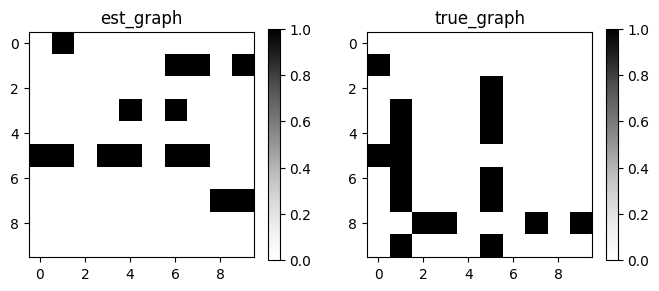

In [5]:
# plot predict_dag and true_dag
GraphDAG(gnn.causal_matrix, B.values)

### RL

In [9]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import DAG, IIDSimulation
from castle.algorithms import RL

rl = RL(nb_epoch=2000)
rl.learn(data=A.values)

2024-10-05 20:15:04,462 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:224] - INFO: GPU is unavailable.
2024-10-05 20:15:04,469 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.11.9
2024-10-05 20:15:04,500 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: 0.0733940238947109, su: 1.203971807325439, strue: -9.92660597610529
2024-10-05 20:15:04,501 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: 0.0733940238947109, su: 1.203971807325439, lambda2: 0.001, true: -44.225174714008126
2024-10-05 20:15:04,515 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:334] - INFO: Finished creating training dataset and reward class
2024-10-05 20:15:04,516 - d:\anaconda3\envs\adia_py311\Li

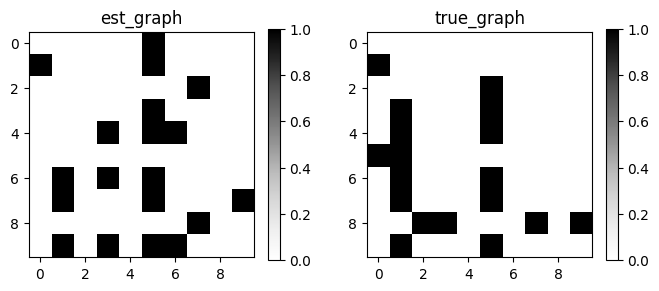

In [11]:
# plot predict_dag and true_dag
GraphDAG(rl.causal_matrix.T, B.values)

2024-10-05 20:24:32,021 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\datasets\simulator.py[line:270] - INFO: Finished synthetic dataset
2024-10-05 20:24:32,023 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:224] - INFO: GPU is unavailable.
2024-10-05 20:24:32,028 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:264] - INFO: Python version is 3.11.9
2024-10-05 20:24:32,069 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:289] - INFO: Original sl: 1.120185539844999, su: 5.838377459109804, strue: -8.879814460155002
2024-10-05 20:24:32,071 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradient\rl\torch\rl.py[line:290] - INFO: Transfomed sl: 1.120185539844999, su: 5.838377459109804, lambda2: 0.001, true: -10.597279817263361
2024-10-05 20:24:32,098 - d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\algorithms\gradi

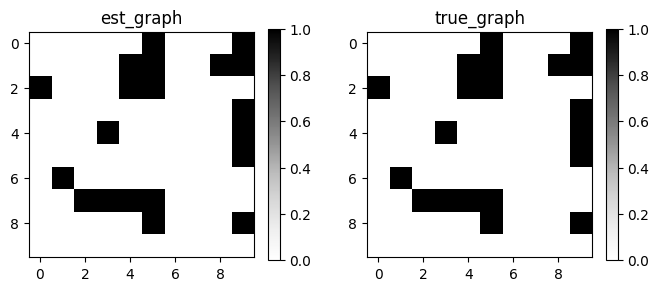

{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 20, 'precision': 1.0, 'recall': 1.0, 'F1': 1.0, 'gscore': 1.0}


d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\metrics\evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\metrics\evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
d:\anaconda3\envs\adia_py311\Lib\site-packages\castle\metrics\evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


: 

In [12]:
# simulate data for rl
weighted_random_dag = DAG.erdos_renyi(n_nodes=10, n_edges=20, weight_range=(0.5, 2.0), seed=1)
dataset = IIDSimulation(W=weighted_random_dag, n=2000, method='linear', sem_type='gauss')
true_dag, X = dataset.B, dataset.X

# rl learn
rl = RL(nb_epoch=2000)
rl.learn(X)

# plot est_dag and true_dag
GraphDAG(rl.causal_matrix, true_dag)

# calculate accuracy
met = MetricsDAG(rl.causal_matrix, true_dag)
print(met.metrics)

## SEM

In [8]:
# SEM 模型
from semopy import Model
from semopy.inspector import inspect
import semopy
import pandas as pd
def sem_features(dataset):
    """
    针对每个变量 v，构建八种 SEM 模型，计算模型拟合指标，生成特征。

    参数：
    - dataset: 包含 X, Y, v1, v2, ... 的 pandas DataFrame

    返回：
    - 包含 SEM 特征的 pandas DataFrame
    """
    variables = dataset.columns.drop(['X', 'Y'])
    df = []

    # 定义八种关系的 SEM 模型描述
    model_templates = {
        "Confounder": """
            X ~ a1*v
            Y ~ b1*X + b2*v
            X ~~ X
            v ~~ v
            Y ~~ Y
        """,
        "Collider": """
            v ~ a1*X + a2*Y
            Y ~ b1*X
            X ~~ X
            v ~~ v
            Y ~~ Y
        """,
        "Mediator": """
            v ~ a1*X
            Y ~ b1*v
            X ~~ X
            v ~~ v
            Y ~~ Y
        """,
        "Cause of X": """
            X ~ a1*v
            Y ~ b1*X
            X ~~ X
            v ~~ v
            Y ~~ Y
        """,
        "Cause of Y": """
            Y ~ a1*X + a2*v
            X ~~ X
            v ~~ v
            Y ~~ Y
        """,
        "Consequence of X": """
            v ~ a1*X
            Y ~ b1*X
            X ~~ X
            v ~~ v
            Y ~~ Y
        """,
        "Consequence of Y": """
            v ~ a1*Y
            Y ~ b1*X
            X ~~ X
            v ~~ v
            Y ~~ Y
        """,
        # "Independent": """
        #     Y ~ a1*X
        #     X ~~ X
        #     v ~~ v
        #     Y ~~ Y
        # """
    }

    # 对于每个变量 v，构建并拟合八种模型
    for variable in variables:
        # 存储每种模型的拟合指标
        fit_indices_list = []
        for label, model_desc_template in model_templates.items():
            # 替换模型描述中的变量名
            model_desc = model_desc_template.replace('v', variable)
            try:
                # 创建并拟合模型
                model = Model(model_desc)
                # 使用全局优化器，以提高模型拟合的稳定性, 关闭所有警告
                model.fit(dataset, solver='SLSQP')
                # 获取模型拟合指标
                # fit_indices = inspect(model)
                stats = semopy.calc_stats(model)
                # 提取常用的拟合指标
                print(stats)
                fit_metrics = {
                    'AIC': stats['AIC'].loc['Value'],
                    'BIC': stats['BIC'].loc['Value'],
                    'CFI': stats['CFI'].loc['Value'],
                    'TLI': stats['TLI'].loc['Value'],
                    'RMSEA': stats['RMSEA'].loc['Value'],
                }
            except Exception as e:
                # 如果模型无法收敛，设置拟合指标为缺失值
                print(e)
                print(model_desc_template)
                fit_metrics = {
                    'AIC': None,
                    'BIC': None,
                    'CFI': None,
                    'TLI': None,
                    'RMSEA': None,
                }
            fit_metrics['Model'] = label
            fit_indices_list.append(fit_metrics)
        # 将拟合指标列表转换为 DataFrame
        fit_df = pd.DataFrame(fit_indices_list)
        fit_df['variable'] = variable
        df.append(fit_df)

    # 合并所有变量的结果
    result_df = pd.concat(df, ignore_index=True)

    # 将模型名称和变量名称组合，展开为列
    pivot_df = result_df.pivot(index='variable', columns='Model')
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
    pivot_df.reset_index(inplace=True)
    pivot_df['dataset'] = dataset.name

    # 返回结果 DataFrame
    return pivot_df

In [10]:
import pandas as pd
import numpy as np
from econml.grf import CausalForest
from sklearn.model_selection import train_test_split


def causal_forest_features_econml(dataset, dataset_name='default_dataset'):
    """
    使用 EconML 的 CausalForest 生成因果森林相关特征，包括 v 对 Y、v 对 X、X 对 v、Y 对 v 的因果效应。
    
    参数：
    - dataset (pd.DataFrame): 包含 'X', 'Y' 以及其他处理变量 (v1, v2, ...) 的数据框。
    - dataset_name (str, optional): 数据集的名称，默认为 'default_dataset'。
    
    返回：
    - cf_features_df (pd.DataFrame): 包含因果森林特征的 DataFrame。
    """
    
    variables = dataset.columns.drop(['X', 'Y'])
    df_list = []

    # 定义要估计的因果效应类型
    causal_directions = [
        ('v', 'Y'),  # v -> Y
        ('v', 'X'),  # v -> X
        ('X', 'v'),  # X -> v
        ('Y', 'v'),  # Y -> v
    ]

    for v in variables:
        tmp_dict = {'variable': v}
        for treatment, outcome in causal_directions:
            # 动态定义处理变量和结果变量
            variable_name = outcome
            if outcome == 'v':
                outcome = v
            if treatment == 'v':
                T = dataset[v].values
                # 控制变量：除 outcome 外的所有变量
                X_covariates = dataset.drop(columns=[outcome, v]).values
            elif treatment == 'X':
                T = dataset['X'].values
                # 控制变量：除 outcome 外的所有变量
                X_covariates = dataset.drop(columns=[outcome, 'X']).values
            elif treatment == 'Y':
                T = dataset['Y'].values
                # 控制变量：除 outcome 外的所有变量
                X_covariates = dataset.drop(columns=[outcome, 'Y']).values
            else:
                raise ValueError(f"未知的处理变量: {treatment}")
            
            Y_val = dataset[outcome].values
            X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
                X_covariates, T, Y_val, test_size=0.2, random_state=42
            )
            # 初始化因果森林模型
            cf = CausalForest(n_estimators=100, random_state=42)

            # 拟合模型（使用关键字参数）
            cf.fit(X=X_train, T=T_train, y=Y_train)

            # 预测个体化因果效应（ITE）
            te_pred = cf.predict(X_test)

            # 计算 ITE 的统计特征
            ite_mean = np.mean(te_pred)
            ite_std = np.std(te_pred)

            # 提取变量重要性
            var_importance = cf.feature_importances_

            # 创建特征字典
            tmp_dict.update({
                f'causal_forest_ite_mean_{treatment}_{variable_name}': ite_mean,
                f'causal_forest_ite_std_{treatment}_{variable_name}': ite_std,
            })

            # # 将变量重要性添加到特征字典
            # control_vars = dataset.drop(columns=[outcome, v] if treatment == 'v' else 
            #                            ([outcome, 'X'] if treatment == 'X' else 
            #                             ([outcome, 'Y'] if treatment == 'Y' else []))).columns
            # for idx, col_name in enumerate(control_vars):
            #     feature_dict[f'causal_forest_varimp_{col_name}'] = var_importance[idx]

        df_list.append(tmp_dict)
    
    print(df_list)

    # 转换为 DataFrame
    cf_features_df = pd.DataFrame(df_list)

    # 添加数据集名称
    cf_features_df['dataset'] = dataset_name

    return cf_features_df


In [2]:
import numpy as np

# 创建示例数据集
np.random.seed(42)
dataset = pd.DataFrame({
    'X': np.random.normal(size=1000),
    'Y': np.random.normal(size=1000),
    '1': np.random.normal(size=1000),
    '2': np.random.normal(size=1000),
    '3': np.random.normal(size=1000),
})
dataset.name = 'example_dataset'

casual_forest_output = causal_forest_features_econml(dataset)

[{'variable': '1', 'causal_forest_ite_mean_v_Y': -0.011156175905981584, 'causal_forest_ite_std_v_Y': 0.06718055099424493, 'causal_forest_ite_mean_v_X': 0.022764189660639214, 'causal_forest_ite_std_v_X': 0.0759306497628696, 'causal_forest_ite_mean_X_v': 0.026443856212864908, 'causal_forest_ite_std_X_v': 0.06702881305868659, 'causal_forest_ite_mean_Y_v': -0.012940947150877218, 'causal_forest_ite_std_Y_v': 0.0689025224412247}, {'variable': '2', 'causal_forest_ite_mean_v_Y': -0.09005983327928377, 'causal_forest_ite_std_v_Y': 0.05691515290468467, 'causal_forest_ite_mean_v_X': 0.003827098837520361, 'causal_forest_ite_std_v_X': 0.07164796451176997, 'causal_forest_ite_mean_X_v': 0.0019618901973611756, 'causal_forest_ite_std_X_v': 0.08072811500738145, 'causal_forest_ite_mean_Y_v': -0.10798522853196672, 'causal_forest_ite_std_Y_v': 0.06567280803832011}, {'variable': '3', 'causal_forest_ite_mean_v_Y': -0.029708257770749497, 'causal_forest_ite_std_v_Y': 0.06015540688283375, 'causal_forest_ite_mean

In [3]:
casual_forest_output

,variable,causal_forest_ite_mean_v_Y,causal_forest_ite_std_v_Y,causal_forest_ite_mean_v_X,causal_forest_ite_std_v_X,causal_forest_ite_mean_X_v,causal_forest_ite_std_X_v,causal_forest_ite_mean_Y_v,causal_forest_ite_std_Y_v,dataset
0,1,-0.011156,0.067181,0.022764,0.075931,0.026444,0.067029,-0.012941,0.068903,default_dataset
1,2,-0.090060,0.056915,0.003827,0.071648,0.001962,0.080728,-0.107985,0.065673,default_dataset
2,3,-0.029708,0.060155,-0.019517,0.066100,-0.019236,0.071014,-0.032554,0.070694,default_dataset


In [34]:
import numpy as np

# 创建示例数据集
np.random.seed(42)
dataset = pd.DataFrame({
    'X': np.random.normal(size=1000),
    'Y': np.random.normal(size=1000),
    '1': np.random.normal(size=1000),
    '2': np.random.normal(size=1000),
    '3': np.random.normal(size=1000),
})
dataset.name = 'example_dataset'

# 生成 SEM 特征
sem_feature_df = sem_features(dataset)


divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide


example_dataset


In [5]:

import pingouin as pg
def bootstrap_mediation_feature(dataset, num_bootstrap=1000):
    import pingouin as pg
    variables = dataset.columns.drop(['X', 'Y'])
    df = []

    for variable in variables:
        # 使用 pingouin 进行中介分析
        mediation_results = pg.mediation_analysis(data=dataset, x='X', m=variable, y='Y', alpha=0.05, n_boot=num_bootstrap)

        # 提取间接效应和直接效应的估计值和置信区间
        indirect_effect = mediation_results.loc[mediation_results['path'] == 'Indirect', 'coef'].values[0]
        indirect_ci_lower = mediation_results.loc[mediation_results['path'] == 'Indirect', 'CI[2.5%]'].values[0]
        indirect_ci_upper = mediation_results.loc[mediation_results['path'] == 'Indirect', 'CI[97.5%]'].values[0]

        direct_effect = mediation_results.loc[mediation_results['path'] == 'Direct', 'coef'].values[0]
        direct_ci_lower = mediation_results.loc[mediation_results['path'] == 'Direct', 'CI[2.5%]'].values[0]
        direct_ci_upper = mediation_results.loc[mediation_results['path'] == 'Direct', 'CI[97.5%]'].values[0]

        total_effect = mediation_results.loc[mediation_results['path'] == 'Total', 'coef'].values[0]

        # 将结果添加到列表中
        df.append({
            "variable": variable,
            "bootstrap_indirect_effect_mean": indirect_effect,
            "bootstrap_indirect_effect_ci_lower": indirect_ci_lower,
            "bootstrap_indirect_effect_ci_upper": indirect_ci_upper,
            "bootstrap_direct_effect_mean": direct_effect,
            "bootstrap_direct_effect_ci_lower": direct_ci_lower,
            "bootstrap_direct_effect_ci_upper": direct_ci_upper,
            "bootstrap_total_effect": total_effect
        })

    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    # 调整列的顺序
    df = df[["dataset", "variable"] + [col for col in df.columns if col not in ["dataset", "variable"]]]

    return df

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def anm_features(dataset):
    """
    Given a dataset, compute features based on an additive noise model for each variable v (excluding X and Y).

    For each variable v:

    - Fit linear regression v ~ X + X^2, compute residuals ε_vX, compute correlation between ε_vX and X
    - Fit linear regression v ~ Y + Y^2, compute residuals ε_vY, compute correlation between ε_vY and Y
    - Fit linear regression v ~ X + Y + X^2 + Y^2 + X*Y, compute residuals ε_vXY, compute correlations between ε_vXY and X and Y
    - Compute R^2 values for the regressions
    - Fit linear regression Y ~ X + X^2, compute R²_YX
    - Fit linear regression Y ~ X + v + X^2 + v^2 + X*v, compute R²_YXv
    - Compute difference ΔR²_YXv = R²_YXv - R²_YX

    Collect these features into a DataFrame.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df_list = []

    for variable in variables:
        # Create a dictionary to store features
        features = {"variable": variable}

        # Create polynomial features for X
        X_poly = pd.DataFrame({
            "const": 1,
            "X": dataset["X"],
            "X^2": dataset["X"] ** 2,
        })
        # Regress v on X and X^2
        model_vX = sm.OLS(dataset[variable], X_poly).fit()
        residuals_vX = model_vX.resid
        features["R2_v~X+X^2"] = model_vX.rsquared
        features["corr(ε_vX, X)"] = np.corrcoef(residuals_vX, dataset["X"])[0,1]

        # Create polynomial features for Y
        Y_poly = pd.DataFrame({
            "const": 1,
            "Y": dataset["Y"],
            "Y^2": dataset["Y"] ** 2,
        })
        # Regress v on Y and Y^2
        model_vY = sm.OLS(dataset[variable], Y_poly).fit()
        residuals_vY = model_vY.resid
        features["R2_v~Y+Y^2"] = model_vY.rsquared
        features["corr(ε_vY, Y)"] = np.corrcoef(residuals_vY, dataset["Y"])[0,1]

        # Create polynomial and interaction terms for X and Y
        XY_poly = pd.DataFrame({
            "const": 1,
            "X": dataset["X"],
            "Y": dataset["Y"],
            "X^2": dataset["X"] ** 2,
            "Y^2": dataset["Y"] ** 2,
            "X*Y": dataset["X"] * dataset["Y"],
        })
        # Regress v on X, Y, X^2, Y^2, X*Y
        model_vXY = sm.OLS(dataset[variable], XY_poly).fit()
        residuals_vXY = model_vXY.resid
        features["R2_v~poly(X,Y)"] = model_vXY.rsquared
        features["corr(ε_vXY, X)"] = np.corrcoef(residuals_vXY, dataset["X"])[0,1]
        features["corr(ε_vXY, Y)"] = np.corrcoef(residuals_vXY, dataset["Y"])[0,1]

        # For regressions of Y

        # Regress Y on X and X^2
        model_YX = sm.OLS(dataset["Y"], X_poly).fit()
        R2_YX = model_YX.rsquared

        # Regress Y on X, v, and quadratic terms
        Xv_poly = pd.DataFrame({
            "const": 1,
            "X": dataset["X"],
            variable: dataset[variable],
            "X^2": dataset["X"] ** 2,
            f"{variable}^2": dataset[variable] ** 2,
            f"X*{variable}": dataset["X"] * dataset[variable],
        })
        model_YXv = sm.OLS(dataset["Y"], Xv_poly).fit()
        R2_YXv = model_YXv.rsquared
        features["ΔR2_Y~X+v"] = R2_YXv - R2_YX

        df_list.append(features)

    df = pd.DataFrame(df_list)
    df["dataset"] = dataset.name

    # Reorder columns to put "dataset" first
    cols = ["dataset"] + [col for col in df.columns if col != "dataset"]

    df = df[cols]

    return df


In [6]:
import numpy as np

# 创建示例数据集
np.random.seed(42)
dataset = pd.DataFrame({
    'X': np.random.normal(size=1000),
    'Y': np.random.normal(size=1000),
    '1': np.random.normal(size=1000),
    '2': np.random.normal(size=1000),
    '3': np.random.normal(size=1000),
})
dataset.name = 'example_dataset'

# 生成 SEM 特征
anm_feature_df = anm_features(dataset)



In [7]:
anm_feature_df

,dataset,variable,R2_v~X+X^2,"corr(ε_vX, X)",R2_v~Y+Y^2,"corr(ε_vY, Y)","R2_v~poly(X,Y)","corr(ε_vXY, X)","corr(ε_vXY, Y)",ΔR2_Y~X+v
0,example_dataset,1,0.000523,-2.077773e-18,0.000128,-3.081727e-17,0.001610,-5.566844e-17,8.163566e-18,0.001353
1,example_dataset,2,0.000523,1.061023e-17,0.003036,-1.738223e-17,0.003760,1.062745e-17,-8.694272e-18,0.003151
2,example_dataset,3,0.001660,3.754246e-17,0.000360,4.491710e-19,0.002074,5.495159e-17,-2.742296e-17,0.000736


In [7]:
import numpy as np

# 创建示例数据集
np.random.seed(42)
dataset = pd.DataFrame({
    'X': np.random.normal(size=1000),
    'Y': np.random.normal(size=1000),
    '1': np.random.normal(size=1000),
    '2': np.random.normal(size=1000),
    '3': np.random.normal(size=1000),
})
dataset.name = 'example_dataset'

# 生成 SEM 特征
sem_feature_df = bootstrap_mediation_feature(dataset)



In [8]:
import numpy as np
import pandas as pd
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator

def compute_mdl_score(data, model):
    # 计算模型的参数数量（模型复杂度）
    num_params = 0
    for node in model.nodes():
        cpd = model.get_cpds(node)
        # 参数数量 = (节点的状态数 - 1) * 父节点的状态数的乘积
        cardinality = cpd.cardinality
        num_states = cardinality[0]
        num_parent_states = np.prod(cardinality[1:]) if len(cardinality) > 1 else 1
        num_params += (num_states - 1) * num_parent_states

    # 模型描述长度 L(M)
    L_M = num_params * np.log(data.shape[0]) / 2

    # 数据的负对数似然度 L(D | M)
    log_likelihood = model.score(data) * data.shape[0]  # pgmpy 的 score 返回的是平均对数似然
    L_D_M = -log_likelihood

    mdl_score = L_M + L_D_M
    return mdl_score

def MDL_feature(data, X='X', Y='Y'):
    variables = data.columns.drop([X, Y]).tolist()
    features = []

    for v in variables:
        mdl_v_X = np.nan
        mdl_X_v = np.nan
        mdl_v_Y = np.nan
        mdl_Y_v = np.nan
        mdl_X_Y = np.nan

        # 模型1：包含边 v -> X 和已知的 X -> Y
        try:
            model_v_X = BayesianNetwork([(v, X), (X, Y)])
            model_v_X.fit(data, estimator=MaximumLikelihoodEstimator)
            mdl_v_X = compute_mdl_score(data, model_v_X)
        except Exception as e:
            pass  # 保持 mdl_v_X 为 NaN

        # 模型2：包含边 X -> v 和已知的 X -> Y
        try:
            model_X_v = BayesianNetwork([(X, v), (X, Y)])
            model_X_v.fit(data, estimator=MaximumLikelihoodEstimator)
            mdl_X_v = compute_mdl_score(data, model_X_v)
        except Exception as e:
            pass

        # 模型3：包含边 v -> Y 和已知的 X -> Y
        try:
            model_v_Y = BayesianNetwork([(v, Y), (X, Y)])
            model_v_Y.fit(data, estimator=MaximumLikelihoodEstimator)
            mdl_v_Y = compute_mdl_score(data, model_v_Y)
        except Exception as e:
            pass

        # 模型4：包含边 Y -> v 和已知的 X -> Y
        try:
            model_Y_v = BayesianNetwork([(Y, v), (X, Y)])
            model_Y_v.fit(data, estimator=MaximumLikelihoodEstimator)
            mdl_Y_v = compute_mdl_score(data, model_Y_v)
        except Exception as e:
            pass

        # 模型5：仅包含已知的边 X -> Y
        try:
            model_X_Y = BayesianNetwork([(X, Y)])
            model_X_Y.fit(data, estimator=MaximumLikelihoodEstimator)
            mdl_X_Y = compute_mdl_score(data, model_X_Y)
        except Exception as e:
            pass

        features.append({
            "variable": v,
            "MDL(v,X)": mdl_v_X,
            "MDL(X,v)": mdl_X_v,
            "MDL(v,Y)": mdl_v_Y,
            "MDL(Y,v)": mdl_Y_v,
            "MDL(X,Y)": mdl_X_Y,
        })

    features_df = pd.DataFrame(features)
    return features_df


e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import numpy as np

# 创建示例数据集
np.random.seed(42)
dataset = pd.DataFrame({
    'X': np.random.normal(size=1000),
    'Y': np.random.normal(size=1000),
    '1': np.random.normal(size=1000),
    '2': np.random.normal(size=1000),
    '3': np.random.normal(size=1000),
})
dataset.name = 'example_dataset'

# 生成 SEM 特征
sem_feature_df = MDL_feature(dataset)



## Granger test

In [45]:
sem_feature_df

,variable,AIC_Cause of X,AIC_Cause of Y,AIC_Collider,AIC_Confounder,AIC_Consequence of X,AIC_Consequence of Y,AIC_Independent,AIC_Mediator,BIC_Cause of X,...,TLI_Mediator,RMSEA_Cause of X,RMSEA_Cause of Y,RMSEA_Collider,RMSEA_Confounder,RMSEA_Consequence of X,RMSEA_Consequence of Y,RMSEA_Independent,RMSEA_Mediator,dataset
0,1,9.999787,10.000000,11.999999,12.0,9.999787,9.999058,NaN,9.996770,34.538564,...,3.394561,0.000000,0.0,inf,inf,0.000000,0.00000,NaN,0.024807,example_dataset
1,2,9.993877,9.999999,12.000000,12.0,9.993878,9.999515,NaN,9.996603,34.532653,...,-0.119144,0.045427,0.0,inf,inf,0.045423,0.00000,NaN,0.026441,example_dataset
2,3,9.999202,10.000000,12.000000,12.0,9.999202,9.997948,NaN,9.996633,34.537978,...,-230.585200,0.000000,0.0,inf,inf,0.000000,0.00512,NaN,0.026160,example_dataset


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

In [1]:
import pandas as pd
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')
print(len(X_train), len(y_train))

23500 23500


In [2]:
# Example usage
A = X_train['00000'].copy()
B = y_train['00000'].copy()
A.to_csv('./data/A.csv')
B.to_csv('./data/B.csv')

In [5]:
print(B)

        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0


In [32]:
print(A.columns)

Index(['0', 'Y', '2', '3', '4', '5', '6', '7', '8', 'X'], dtype='object')


In [13]:
A = A.sort_values(by='Y', ascending=True)

In [30]:
lags = 5
result = grangercausalitytests(A[['7', 'X']], maxlag=lags)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=346.3206, p=0.0000  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=347.3637, p=0.0000  , df=1
likelihood ratio test: chi2=298.1095, p=0.0000  , df=1
parameter F test:         F=346.3206, p=0.0000  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=125.2465, p=0.0000  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=251.7543, p=0.0000  , df=2
likelihood ratio test: chi2=224.4991, p=0.0000  , df=2
parameter F test:         F=125.2465, p=0.0000  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=57.7003 , p=0.0000  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=174.3249, p=0.0000  , df=3
likelihood ratio test: chi2=160.6566, p=0.0000  , df=3
parameter F test:         F=57.7003 , p=0.0000  , df_denom=990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=34.9675 , p=0.0000  

In [ ]:
from causallearn.search.Granger.Granger import Granger
G = Granger()
coeff = G.granger_lasso(A[['0', '2', '3', '4', '5', '6', '7', '8', 'X']])

## SEM-1011

In [2]:
import semopy
from semopy import Model
from semopy.inspector import inspect

In [53]:
# Example usage
import pandas as pd
A = pd.read_csv('./data/A.csv', index_col=0)
B = pd.read_csv('./data/B.csv', index_col=0)
print(A.columns)
print(B)

Index(['0', 'Y', '2', '3', '4', '5', '6', '7', '8', 'X'], dtype='object')
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0


In [59]:
variables = A.columns.drop(['X', 'Y'])
v0 = '0'
# 存储每种模型的拟合指标
fit_indices_list = []
model_desc_template = """
    v0 ~ Y
    X ~ variables
    Y ~ X + variables
    """
#     X ~~ X
#     Y ~~ Y
#     v0 ~~ v0 + variables
# """
# 替换模型描述中的变量名
def replace_v_in_sem(v0, variables, model_desc_template):
    variables = variables.tolist()
    variables.remove(v0)
    print(v0, variables)
    variables_str_right = ' + '.join(variables)
    variables_str_left = ' , '.join(variables)
    model_desc = model_desc_template.replace('v0', v0).replace('variables_l', variables_str_left).replace('variables', variables_str_right)
    return model_desc

model_desc = replace_v_in_sem(v0, variables, model_desc_template)
print(model_desc)

# 创建并拟合模型
model = Model(model_desc)
# 使用全局优化器，以提高模型拟合的稳定性, 关闭所有警告
model.fit(A, solver='SLSQP')

# 获取模型拟合指标
stats = semopy.calc_stats(model)
print(stats)

0 ['2', '3', '4', '5', '6', '7', '8']

    0 ~ Y
    X ~ 2 + 3 + 4 + 5 + 6 + 7 + 8
    Y ~ X + 2 + 3 + 4 + 5 + 6 + 7 + 8
    
       DoF  DoF Baseline         chi2  chi2 p-value  chi2 Baseline       CFI  \
Value   36            52  2578.203493           0.0    8570.733462  0.701575   

            GFI     AGFI       NFI       TLI     RMSEA        AIC         BIC  \
Value  0.699185  0.56549  0.699185  0.568942  0.265871  32.843593  126.090943   

         LogLik  
Value  2.578203  


In [60]:
variables = A.columns.drop(['X', 'Y'])
v0 = '0'
# 存储每种模型的拟合指标
fit_indices_list = []
model_desc_template = """
    X ~ v0 + variables
    Y ~ X + v0 + variables
    """
#     X ~~ X
#     Y ~~ Y
#     v0 ~~ v0 + variables
# """
# 替换模型描述中的变量名
def replace_v_in_sem(v0, variables, model_desc_template):
    variables = variables.tolist()
    variables.remove(v0)
    print(v0, variables)
    variables_str_right = ' + '.join(variables)
    variables_str_left = ' , '.join(variables)
    model_desc = model_desc_template.replace('v0', v0).replace('variables_l', variables_str_left).replace('variables', variables_str_right)
    return model_desc

model_desc = replace_v_in_sem(v0, variables, model_desc_template)
print(model_desc)

# 创建并拟合模型
model = Model(model_desc)
# 使用全局优化器，以提高模型拟合的稳定性, 关闭所有警告
model.fit(A, solver='SLSQP')

# 获取模型拟合指标
stats = semopy.calc_stats(model)
print(stats)

0 ['2', '3', '4', '5', '6', '7', '8']

    X ~ 0 + 2 + 3 + 4 + 5 + 6 + 7 + 8
    Y ~ X + 0 + 2 + 3 + 4 + 5 + 6 + 7 + 8
    
       DoF  DoF Baseline      chi2  chi2 p-value  chi2 Baseline       CFI  \
Value   36            53  0.001292           1.0    8570.733808  1.004226   

       GFI  AGFI  NFI       TLI  RMSEA        AIC         BIC    LogLik  
Value  1.0   1.0  1.0  1.006222      0  37.999997  131.247348  0.000001  


In [54]:
variables = A.columns.drop(['X', 'Y'])
v0 = '0'
# 存储每种模型的拟合指标
fit_indices_list = []
model_desc_template = """
    v0 ~ X + Y
    X ~ variables_r
    Y ~ X + variables_r
    """
#     X ~~ X
#     Y ~~ Y
#     v0 ~~ v0 + variables_r
# """
# 替换模型描述中的变量名
def replace_v_in_sem(v0, variables, model_desc_template):
    variables = variables.tolist()
    variables.remove(v0)
    print(v0, variables)
    variables_str_right = ' + '.join(variables)
    variables_str_left = ' , '.join(variables)
    model_desc = model_desc_template.replace('v0', v0).replace('variables_l', variables_str_left).replace('variables_r', variables_str_right)
    return model_desc

model_desc = replace_v_in_sem(v0, variables, model_desc_template)
print(model_desc)

# 创建并拟合模型
model = Model(model_desc)
# 使用全局优化器，以提高模型拟合的稳定性, 关闭所有警告
model.fit(A, solver='SLSQP')

# 获取模型拟合指标
stats = semopy.calc_stats(model)
print(stats)

0 ['2', '3', '4', '5', '6', '7', '8']

    0 ~ X + Y
    X ~ 2 + 3 + 4 + 5 + 6 + 7 + 8
    Y ~ X + 2 + 3 + 4 + 5 + 6 + 7 + 8
    
       DoF  DoF Baseline         chi2  chi2 p-value  chi2 Baseline       CFI  \
Value   35            52  2561.199444           0.0    8570.733462  0.703454   

            GFI      AGFI       NFI       TLI     RMSEA        AIC  \
Value  0.701169  0.556023  0.701169  0.559417  0.268792  34.877601   

              BIC    LogLik  
Value  133.032707  2.561199  


In [46]:
variables = A.columns.drop(['X', 'Y'])
v0 = '0'
# 存储每种模型的拟合指标
fit_indices_list = []
model_desc_template = """
    v0 ~ X
    X ~ variables_r
    Y ~ v0 + X + variables_r
    X ~~ X
    Y ~~ Y
    v0 ~~ v0 + variables_r
"""
# 替换模型描述中的变量名
def replace_v_in_sem(v0, variables, model_desc_template):
    variables = variables.tolist()
    variables.remove(v0)
    print(v0, variables)
    variables_str_right = ' + '.join(variables)
    variables_str_left = ' , '.join(variables)
    model_desc = model_desc_template.replace('v0', v0).replace('variables_l', variables_str_left).replace('variables_r', variables_str_right)
    return model_desc

model_desc = replace_v_in_sem(v0, variables, model_desc_template)
print(model_desc)

# 创建并拟合模型
model = Model(model_desc)
# 使用全局优化器，以提高模型拟合的稳定性, 关闭所有警告
model.fit(A, solver='SLSQP')

# 获取模型拟合指标
stats = semopy.calc_stats(model)
print(stats)

0 ['2', '3', '4', '5', '6', '7', '8']

    0 ~ X
    X ~ 2 + 3 + 4 + 5 + 6 + 7 + 8
    Y ~ 0 + X + 2 + 3 + 4 + 5 + 6 + 7 + 8
    X ~~ X
    Y ~~ Y
    0 ~~ 0 + 2 + 3 + 4 + 5 + 6 + 7 + 8

       DoF  DoF Baseline      chi2  chi2 p-value  chi2 Baseline       CFI  \
Value   28            52  0.000127           1.0    8570.733462  1.003287   

       GFI  AGFI  NFI       TLI  RMSEA   AIC         BIC        LogLik  
Value  1.0   1.0  1.0  1.006104      0  54.0  186.509392  1.271596e-07  


In [7]:
variables = A.columns.drop(['X', 'Y'])
variable = '0'
# 存储每种模型的拟合指标
fit_indices_list = []
model_desc_template = """
    X ~ v
    Y ~ X + v
    X ~~ X
    v ~~ v
    Y ~~ Y
"""
# 替换模型描述中的变量名
model_desc = model_desc_template.replace('v', variable)
print(model_desc)


        X ~ 0
        Y ~ X + 0
        X ~~ X
        0 ~~ 0
        Y ~~ Y
    


In [51]:

variables = A.columns.drop(['X', 'Y'])
df = []

# 定义八种关系的 SEM 模型描述
model_templates = {
    "Confounder": """
        X ~ a1*v
        Y ~ b1*X + b2*v
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Collider": """
        v ~ a1*X + a2*Y
        Y ~ b1*X
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Mediator": """
        v ~ a1*X
        Y ~ b1*v
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Cause of X": """
        X ~ a1*v
        Y ~ b1*X
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Cause of Y": """
        Y ~ a1*X + a2*v
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Consequence of X": """
        v ~ a1*X
        Y ~ b1*X
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Consequence of Y": """
        v ~ a1*Y
        Y ~ b1*X
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    # "Independent": """
    #     Y ~ a1*X
    #     X ~~ X
    #     v ~~ v
    #     Y ~~ Y
    # """
}

# 对于每个变量 v，构建并拟合八种模型
for variable in variables:
    # 存储每种模型的拟合指标
    fit_indices_list = []
    for label, model_desc_template in model_templates.items():
        print('##################')
        print(variable, label)
        # 替换模型描述中的变量名
        model_desc = model_desc_template.replace('v', variable)
        # 创建并拟合模型
        model = Model(model_desc)
        # 使用全局优化器，以提高模型拟合的稳定性, 关闭所有警告
        model.fit(A, solver='SLSQP')
        # 获取模型拟合指标
        # fit_indices = inspect(model)
        stats = semopy.calc_stats(model)
        print(stats)

##################
0 Confounder
       DoF  DoF Baseline      chi2  chi2 p-value  chi2 Baseline  CFI  GFI  \
Value    0             3  0.000269           NaN     932.703528  1.0  1.0   

       AGFI  NFI  TLI  RMSEA        AIC        BIC        LogLik  
Value   NaN  1.0  NaN    inf  11.999999  41.446531  2.688234e-07  
##################
0 Collider
       DoF  DoF Baseline      chi2  chi2 p-value  chi2 Baseline  CFI  GFI  \
Value    0             3  0.000244           NaN     932.703528  1.0  1.0   

       AGFI  NFI  TLI  RMSEA   AIC        BIC        LogLik  
Value   NaN  1.0  NaN    inf  12.0  41.446531  2.442033e-07  
##################
0 Mediator
       DoF  DoF Baseline       chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    1             3  890.48248           0.0     932.703528  0.043262   

            GFI      AGFI       NFI       TLI     RMSEA       AIC        BIC  \
Value  0.045267 -1.864198  0.045267 -1.870213  0.943596  8.219035  32.757811   

         LogLik  
Valu

d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:38

       DoF  DoF Baseline      chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    1             3  9.776369      0.001768      971.18827  0.990935   

            GFI      AGFI       NFI       TLI     RMSEA       AIC        BIC  \
Value  0.989934  0.969801  0.989934  0.972806  0.093729  9.980447  34.519224   

         LogLik  
Value  0.009776  
##################
4 Confounder
       DoF  DoF Baseline      chi2  chi2 p-value  chi2 Baseline  CFI  GFI  \
Value    0             3  0.000186           NaN     903.096452  1.0  1.0   

       AGFI  NFI  TLI  RMSEA   AIC        BIC        LogLik  
Value   NaN  1.0  NaN    inf  12.0  41.446531  1.862210e-07  
##################
4 Collider
       DoF  DoF Baseline      chi2  chi2 p-value  chi2 Baseline  CFI  GFI  \
Value    0             3  0.000174           NaN     903.096452  1.0  1.0   

       AGFI  NFI  TLI  RMSEA   AIC        BIC        LogLik  
Value   NaN  1.0  NaN    inf  12.0  41.446531  1.737975e-07  
##################
4 Mediato

d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:38

       DoF  DoF Baseline      chi2  chi2 p-value  chi2 Baseline  CFI  GFI  \
Value    0             3  0.000101           NaN    2128.572641  1.0  1.0   

       AGFI  NFI  TLI  RMSEA   AIC        BIC        LogLik  
Value   NaN  1.0  NaN    inf  12.0  41.446531  1.010540e-07  
##################
7 Collider
       DoF  DoF Baseline      chi2  chi2 p-value  chi2 Baseline  CFI  GFI  \
Value    0             3  0.000024           NaN    2128.572641  1.0  1.0   

       AGFI  NFI  TLI  RMSEA   AIC        BIC        LogLik  
Value   NaN  1.0  NaN    inf  12.0  41.446532  2.389242e-08  
##################
7 Mediator
       DoF  DoF Baseline         chi2  chi2 p-value  chi2 Baseline       CFI  \
Value    1             3  1173.371144           0.0    2128.572641  0.448445   

            GFI      AGFI       NFI       TLI     RMSEA       AIC        BIC  \
Value  0.448752 -0.653744  0.448752 -0.654666  1.083303  7.653258  32.192034   

         LogLik  
Value  1.173371  
##################
7 Cau

d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))
d:\anaconda3\envs\adia_py311\Lib\site-packages\semopy\stats.py:383: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((chi2 / dof - 1) / (model.n_samples - 1))


In [ ]:
variables = A.columns.drop(['X', 'Y'])
df = []

# 定义八种关系的 SEM 模型描述
model_templates = {
    "Confounder": """
        X ~ a1*v
        Y ~ b1*X + b2*v
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Collider": """
        v ~ a1*X + a2*Y
        Y ~ b1*X
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Mediator": """
        v ~ a1*X
        Y ~ b1*v
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Cause of X": """
        X ~ a1*v
        Y ~ b1*X
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Cause of Y": """
        Y ~ a1*X + a2*v
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Consequence of X": """
        v ~ a1*X
        Y ~ b1*X
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    "Consequence of Y": """
        v ~ a1*Y
        Y ~ b1*X
        X ~~ X
        v ~~ v
        Y ~~ Y
    """,
    # "Independent": """
    #     Y ~ a1*X
    #     X ~~ X
    #     v ~~ v
    #     Y ~~ Y
    # """
}

# 对于每个变量 v，构建并拟合八种模型
for variable in variables:
    # 存储每种模型的拟合指标
    fit_indices_list = []
    for label, model_desc_template in model_templates.items():
        print('##################')
        print(variable, label)
        # 替换模型描述中的变量名
        model_desc = model_desc_template.replace('v', variable)
        # 创建并拟合模型
        model = Model(model_desc)
        # 使用全局优化器，以提高模型拟合的稳定性, 关闭所有警告
        model.fit(A, solver='SLSQP')
        # 获取模型拟合指标
        # fit_indices = inspect(model)
        stats = semopy.calc_stats(model)
        print(stats)

## describe_feature

In [73]:
import pandas as pd
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')
print(len(X_train), len(y_train))

23500 23500


In [ ]:
A = X_train['22']

KeyError: '22'

In [61]:
# Example usage
import pandas as pd
A = pd.read_csv('./data/A.csv', index_col=0)
B = pd.read_csv('./data/B.csv', index_col=0)
print(A.columns)
print(B)

Index(['0', 'Y', '2', '3', '4', '5', '6', '7', '8', 'X'], dtype='object')
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0


In [72]:
temp = A.sort_values(by=['Y'], ascending=True).reset_index(drop=True)
# temp = A['0'].sort_values().reset_index(drop=True).reset_index(drop=False)
# temp['index'] = temp['index'] / 500
print(temp)

         0      Y      2      3      4      5      6      7      8      X
0    0.249 -0.999 -0.195 -0.417  0.073  0.327  0.897 -0.951 -0.611  0.949
1    0.061 -0.997 -0.147  0.581  0.631  0.569 -0.739 -0.983 -0.949  0.935
2    0.089 -0.995 -0.901 -0.175  0.999  0.681 -0.447 -0.755 -0.997  0.857
3    0.589 -0.993 -0.243 -0.221  0.545 -0.061 -0.483 -0.805 -0.533  0.995
4    0.723 -0.991 -0.667 -0.943  0.131 -0.123  0.679 -0.817 -0.909  0.829
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.077  0.991 -0.829 -0.339  0.971 -0.617  0.465  0.957  0.383 -0.879
996  0.353  0.993  0.459 -0.769  0.587 -0.851  0.699  0.863  0.541 -0.927
997 -0.461  0.995  0.699  0.205  0.137 -0.243  0.541  0.775  0.361 -0.969
998  0.179  0.997  0.221 -0.447  0.435 -0.625  0.815  0.967  0.533 -0.911
999 -0.599  0.999  0.487  0.277  0.839 -0.197  0.575  0.965  0.631 -0.981

[1000 rows x 10 columns]


In [71]:
# 使用线性函数对temp做回归，x为index、y为0
from sklearn.linear_model import Ridge, LinearRegression
linear_model = LinearRegression().fit(temp[['index']], temp[['0']])
linear_model_coefs = linear_model.coef_[0].tolist()
print(linear_model_coefs)

[0.9999999999999994]


In [ ]:
# 噪声刻画
signal = np.mean(dataset[variable])
noise = np.std(dataset[variable])
snr = 10 * np.log10(signal / noise)
snr_square = 10 * np.log10(signal ** 2 / noise ** 2)

## 卷积操作处理噪声

In [15]:
from causallearn.search.ScoreBased.ExactSearch import bic_exact_search

def ExactSearch_estimate(dataset, search_method='astar', use_path_extension=True, 
                        use_k_cycle_heuristic=False, k=3, max_parents=None):
    """
    使用Exact Search算法进行因果发现。
    
    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - search_method (str): Exact Search方法，'astar'或'dp'。默认值为'astar'。
    - use_path_extension (bool): 是否使用路径扩展。默认值为True。
    - use_k_cycle_heuristic (bool): 是否使用k-cycle冲突启发式。仅适用于'astar'方法。默认值为False。
    - k (int): k-cycle启发式的参数。默认值为3。
    - max_parents (int or None): 节点的最大父节点数量。默认值为None。
    
    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为DataFrame。
    """
    
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values

    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)

    # 2. 定义X→Y的超级图
    d = dataset.shape[1]   
    super_graph = np.ones((d, d), dtype=int)  # 初始化为全1，表示所有边默认允许
    columns = dataset.columns.tolist()
    x_idx = columns.index('X')
    y_idx = columns.index('Y')
    super_graph[y_idx][x_idx] = 0     # 禁止'Y'→'X'
    np.fill_diagonal(super_graph, 0)  # 禁止自环：确保对角线为0
    
    # 3. 运行Exact Search算法，使用指定的参数
    dag_est, search_stats = bic_exact_search(X=data, super_graph=super_graph, search_method=search_method,
        use_path_extension=use_path_extension, use_k_cycle_heuristic=use_k_cycle_heuristic,
        k=k, verbose=False, max_parents=max_parents)
    
    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(dag_est, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

def apply_convolution(df, columns, window_size, mode='same'):
    """
    对数据框指定的列进行卷积操作。

    参数:
    df (pd.DataFrame): 输入的数据框。
    columns (list): 需要进行卷积操作的列名列表。
    window_size (int): 滑动窗口的大小。
    mode (str): 卷积模式，默认为 'same'，可选 'valid' 或 'full'。

    返回:
    pd.DataFrame: 应用卷积操作后的数据框。
    """
    result_df = df.copy()  # 复制数据框以避免修改原数据

    # 创建滑动平均的卷积核
    kernel = np.ones(window_size) / window_size

    for col in columns:
        if col in df.columns:
            # 对指定的列进行卷积操作
            result_df[col] = np.convolve(df[col], kernel, mode=mode)
        else:
            print(f"列 '{col}' 不存在于数据框中")

    return result_df

def evaluate_exact_search_on_datasets(X_train, y_train, num=None, conv=True, search_method='astar', 
                                      use_path_extension=True, use_k_cycle_heuristic=False, k=3, max_parents=None):
    """
    遍历多个数据集，评估Exact Search算法的效果。
    
    参数:
    - X_train (dict): 输入的训练数据集，键为数据集名称，值为pd.DataFrame。
    - y_train (dict): 真实因果关系的邻接矩阵，键为数据集名称，值为pd.DataFrame。
    - num (int, optional): 要评估的数据集数量，默认遍历全部。
    - super_graph (numpy.ndarray or None): 超结构，用于限制搜索空间。默认值为None。
    - search_method (str): Exact Search方法，'astar'或'dp'。默认值为'astar'。
    - use_path_extension (bool): 是否使用路径扩展。默认值为True。
    - use_k_cycle_heuristic (bool): 是否使用k-cycle冲突启发式。仅适用于'astar'方法。默认值为False。
    - k (int): k-cycle启发式的参数。默认值为3。
    - verbose (bool): 是否打印详细输出。默认值为False。
    - include_graph (bool): 是否在搜索统计中包含图信息。默认值为True。
    - max_parents (int or None): 节点的最大父节点数量。默认值为None。
    - score_func (str): 评分函数。默认为'local_score_BIC'。
    - alpha (float): 显著性水平，用于多重共线性处理。默认值为0.05。
    
    返回:
    - evaluation_results (dict): 包含每个数据集评估结果的字典。
    """
    evaluation_results = {}
    
    # 获取所有数据集的键
    dataset_keys = list(X_train.keys())
    
    # 如果num未指定，遍历所有
    if num is None:
        num = len(dataset_keys)
    else:
        num = min(num, len(dataset_keys))
    
    # 使用tqdm添加进度条
    for key in tqdm(dataset_keys[:num], desc="Evaluating Exact Search Algorithm", unit="dataset"):
        dataset = X_train[key]
        if conv == True:
            dataset = dataset.sort_values(by='Y', ascending=True).reset_index(drop=True)
            cols = dataset.columns.drop(["Y"]).tolist()
            dataset = apply_convolution(dataset, cols, window_size=7, mode='same')
        true_adj_df_dag = y_train[key]
        estimate_adj_df = ExactSearch_estimate(
            dataset, 
            search_method=search_method, 
            use_path_extension=use_path_extension,
            use_k_cycle_heuristic=use_k_cycle_heuristic, 
            k=k, 
            max_parents=max_parents
        )
        estimate_adj_df_dag = estimate_adj_df.astype(int)  # Directly using the estimated DAG
        evaluation_result = evaluate_causal_discovery(estimate_adj_df_dag, true_adj_df_dag, focus_vars=['X', 'Y'])
        evaluation_results[key] = evaluation_result
    
    return evaluation_results

Evaluating Exact Search Algorithm: 100%|██████████| 2000/2000 [57:23<00:00,  1.72s/dataset] 
C:\Users\25105\AppData\Local\Temp\ipykernel_16780\1228216576.py:265: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\25105\AppData\Local\Temp\ipykernel_16780\1228216576.py:265: UserWarning: Glyph 21367 (\N{CJK UNIFIED IDEOGRAPH-5377}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\25105\AppData\Local\Temp\ipykernel_16780\1228216576.py:265: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\25105\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\25105\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21367 (\N{CJK UNIFIE

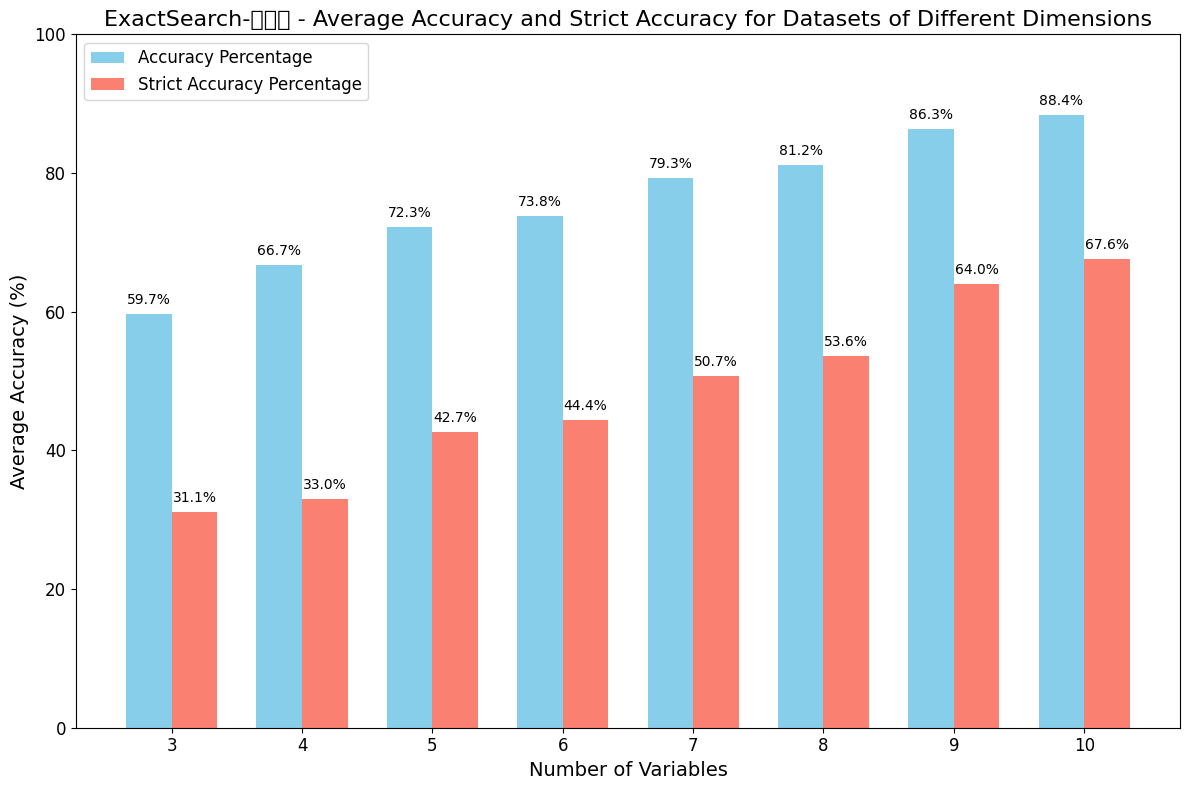

In [17]:
evaluation_results = evaluate_exact_search_on_datasets(X_train, y_train, num=2000, conv=False)
plot_average_accuracy(evaluation_results, 'ExactSearch-不卷积')

Evaluating Exact Search Algorithm: 100%|██████████| 2000/2000 [45:25<00:00,  1.36s/dataset] 
C:\Users\25105\AppData\Local\Temp\ipykernel_16780\1228216576.py:265: UserWarning: Glyph 21367 (\N{CJK UNIFIED IDEOGRAPH-5377}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\25105\AppData\Local\Temp\ipykernel_16780\1228216576.py:265: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\25105\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21367 (\N{CJK UNIFIED IDEOGRAPH-5377}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\25105\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


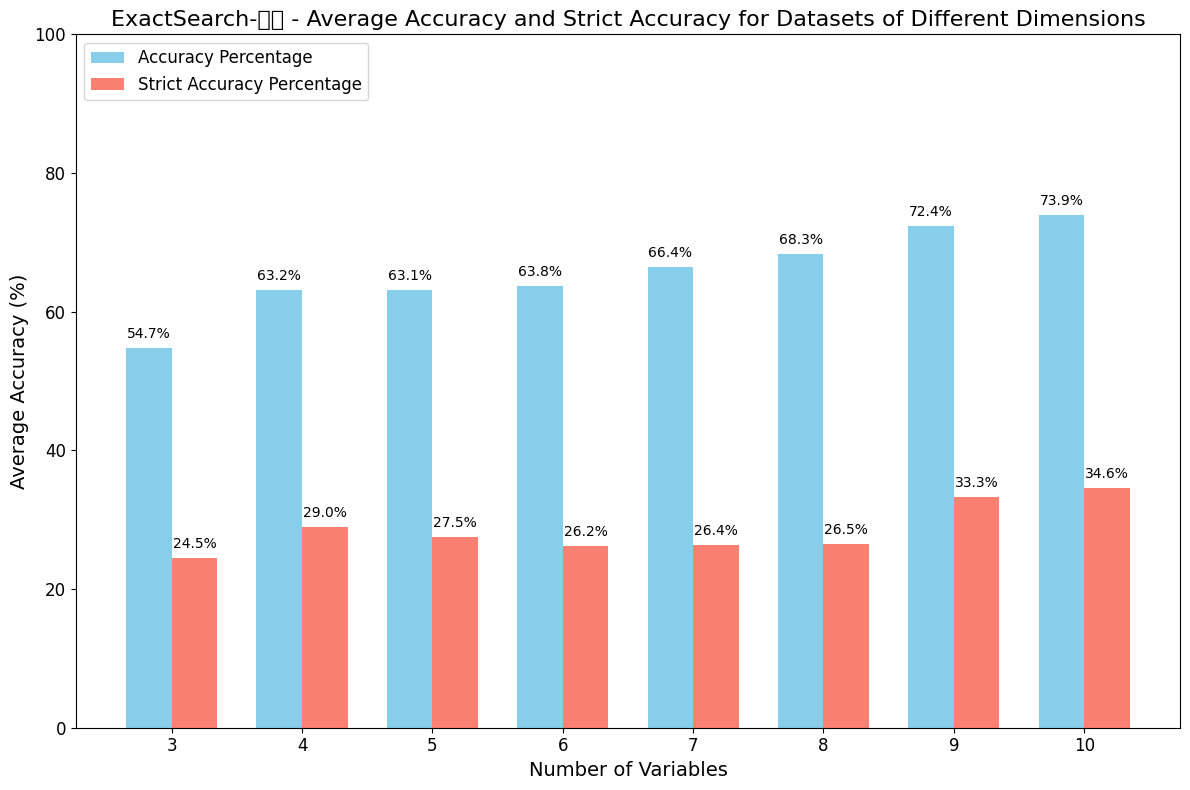

In [19]:
evaluation_results = evaluate_exact_search_on_datasets(X_train, y_train, num=2000, conv=True)
plot_average_accuracy(evaluation_results, 'ExactSearch-卷积')

In [5]:
import pandas as pd
import numpy as np

def apply_convolution(df, columns, window_size, mode='same'):
    """
    对数据框指定的列进行卷积操作。

    参数:
    df (pd.DataFrame): 输入的数据框。
    columns (list): 需要进行卷积操作的列名列表。
    window_size (int): 滑动窗口的大小。
    mode (str): 卷积模式，默认为 'same'，可选 'valid' 或 'full'。

    返回:
    pd.DataFrame: 应用卷积操作后的数据框。
    """
    result_df = df.copy()  # 复制数据框以避免修改原数据

    # 创建滑动平均的卷积核
    kernel = np.ones(window_size) / window_size

    for col in columns:
        if col in df.columns:
            # 对指定的列进行卷积操作
            result_df[col] = np.convolve(df[col], kernel, mode=mode)
        else:
            print(f"列 '{col}' 不存在于数据框中")

    return result_df


# 创建一个示例数据框
data = {
    'A': [1, 2, 3, 4, 5, 6, 7],
    'B': [5, 4, 3, 2, 1, 0, -1],
    'C': [1, 3, 5, 7, 9, 11, 13]
}

df = pd.DataFrame(data)

# 对列 'A' 和 'B' 应用滑动窗口为3的滑动平均
result = apply_convolution(df, ['A', 'B'], window_size=3)
print(result)


          A         B   C
0  1.000000  3.000000   1
1  2.000000  4.000000   3
2  3.000000  3.000000   5
3  4.000000  2.000000   7
4  5.000000  1.000000   9
5  6.000000  0.000000  11
6  4.333333 -0.333333  13


## 检查线上数据

In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm  # 导入 tqdm

X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')
print(len(X_train), len(y_train))

# 获取所有数据集的键
local_datasets_describe = {}
dataset_keys = list(X_train.keys())

for key in tqdm(dataset_keys, desc="检查", unit="dataset"):
    dataset = X_train[key]
    columns = dataset.columns.tolist()
    true_DAG = y_train[key].values.tolist()
    local_datasets_describe[key] = {'columns': columns, 'true_DAG': true_DAG}

# 将字典保存为 JSON 格式以确保兼容性
import json
with open('./data/local_datasets_describe.json', 'w', encoding='utf-8') as f:
    json.dump(local_datasets_describe, f, ensure_ascii=False, indent=4)

23500 23500


检查: 100%|██████████| 23500/23500 [00:01<00:00, 20289.62dataset/s]


## Neural Network

In [10]:
import typing
import os
from tqdm.auto import tqdm

# Common data science tools
import pandas as pd
import numpy as np

# PyTorch for building and training neural networks
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# We use PyTorch Lightning for training
import pytorch_lightning as pl

# NetworkX for working with graphs
import networkx as nx

# Scikit-learn for data splitting
from sklearn.model_selection import KFold, train_test_split

In [2]:
class CausalDataset(Dataset):
    """
    A PyTorch Dataset class for handling causal discovery data.

    Attributes:
        X (np.ndarray): A 3D numpy array of shape (num_samples, 1000, 10) containing the input features.
        y (np.ndarray): A 3D numpy array of shape (num_samples, 10, 10) containing the target values.
        target_mask (np.ndarray): A 3D boolean numpy array of shape (num_samples, 10, 10) indicating the presence of target values.
    """

    def __init__(
        self,
        X: typing.List[pd.DataFrame],
        y: typing.List[pd.DataFrame]
    ) -> None:
        """
        Initializes the dataset with input features and target values.
        """

        # The shape of X is (num_samples, 1000, 10), where 1000 is number of rows and 10 is maximum number of variables
        self.X = np.zeros([len(X), 1000, 10], dtype=np.float32)

        # The shape of y is (num_samples, 10, 10), where 10 is the maximum number of variables
        self.y = np.zeros([len(X), 10, 10], dtype=np.float32)

        # The target mask is a boolean array indicating the presence of target values, it is need for model training because not all datasets have 10 variables
        self.target_mask = np.zeros([len(X), 10, 10], dtype=bool)

        for i in range(len(X)):
            self.X[i, :X[i].shape[0], :X[i].shape[1]] = X[i].values
            self.y[i, :y[i].shape[0], :y[i].shape[1]] = y[i].values
            self.target_mask[i, :y[i].shape[0], :y[i].shape[1]] = True

    def __len__(self) -> int:
        """
        Returns:
            The number of samples in the dataset.
        """

        return len(self.X)

    def __getitem__(self, idx: int) -> dict:
        """
        Retrieves the sample at the specified index.

        Args:
            idx: The index of the sample to retrieve.

        Returns:
            A dictionary containing 'X', 'y', and 'target_mask' for the specified index.
        """

        X = self.X[idx]
        y = self.y[idx]
        target_mask = self.target_mask[idx]

        return {
            'X': X,
            'y': y,
            'target_mask': target_mask
        }

def preprocessing(X: pd.DataFrame):
    """
    Preprocesses the input data for neural network.

    Args:
        X: The input data as a pandas DataFrame.

    Returns:
        tuple: A tuple containing:
            - torch.Tensor: The input data converted to a PyTorch tensor and unsqueezed.
            - torch.Tensor: A mask tensor of ones with the same shape as the input tensor.
    """

    x = torch.Tensor(X.values).unsqueeze(0)
    return x

In [3]:
class CausalModel(nn.Module):
    """
    A neural network model for causal discovery.

    Attributes:
        input_layer (nn.Sequential): The input layer consisting of a linear layer, ReLU activation, and another linear layer.
        final (nn.Sequential): The final layer consisting of a linear layer, ReLU activation, and another linear layer.
    """

    def __init__(self, d_model=64):
        """
        Args:
            d_model: The dimension of the model. Default is 64.
        """
        
        super().__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(1, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 2 * d_model)
        )

        self.final = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the network.

        Args:
            x: The input tensor.

        Returns:
            The output tensor after applying the model.
        """

        # Compute the query and key tensors
        q, k = self.input_layer(x.unsqueeze(-1)).chunk(2, dim=-1)

        # Perform the scaled dot-product attention
        x = torch.einsum('b s i d, b s j d -> b i j d', q, k) * (x.shape[1] ** -0.5)

        y = self.final(x).squeeze(-1)
        return y

class ModelWrapper(pl.LightningModule):
    """
    A PyTorch Lightning Module wrapper for a causal model.

    Attributes:
        model (CausalModel): The causal model being wrapped.
        train_criterion (nn.BCEWithLogitsLoss): The loss function used for training, which is Binary Cross-Entropy with a class weight of 5.0 for the positive class.
    """

    def __init__(self, d_model=64):
        """
        Args:
            d_model: The dimension of the model. Default is 64.
        """

        super().__init__()

        self.model = CausalModel(d_model)

        # The loss function is Binary Cross-Entropy with a class weight of 5.0 for the positive class, to account for class imbalance.
        self.train_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5.0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the model.
        """

        return self.model(x)

    def configure_optimizers(self):
        """
        Configures the optimizer and learning rate scheduler for training.
        """

        # We use the Adam optimizer with a learning rate of 1e-3.
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

        # The learning rate is reduced by a factor of 0.1 after the 7th epoch.
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 7, gamma=0.1, last_epoch=-1)

        return [optimizer], [scheduler]

    def training_step(self, train_batch: dict, batch_idx: int):
        """
        Defines a single training step, including the computation of the loss and logging.
        """

        x = train_batch['X']
        y = train_batch['y']
        target_mask = train_batch['target_mask']

        preds = self(x)

        loss = self.train_criterion(preds[target_mask], y[target_mask])

        self.log(
            "train_loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True
        )

        return loss

In [4]:
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')
print(len(X_train), len(y_train))

23500 23500


In [24]:
result = {}
keys = list(X_train.keys())
print(len(keys))
kf = KFold(n_splits=4, shuffle=True, random_state=42)
for i, (train_indices, test_indices) in enumerate(kf.split(keys)):
    print(f"Fold {i}:")
    train_keys = [keys[idx] for idx in train_indices]
    test_keys = [keys[idx] for idx in test_indices]
    print(f"  Train: key={train_keys}")
    print(f"  Test:  key={test_keys}")

    X_train_split = [X_train[key] for key in train_keys]
    y_train_split = [y_train[key] for key in train_keys]
    X_test_split = [X_train[key] for key in test_keys]
    y_test_split = [y_train[key] for key in test_keys]

    train_dataset = CausalDataset(X_train_split, y_train_split)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0)

    test_dataset = CausalDataset(X_test_split, y_test_split)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers=0)

    print("Number of training samples:", len(train_dataset))
    print("Number of test samples:", len(test_dataset))

    # Model Training
    model = ModelWrapper(d_model=64)
    trainer = pl.Trainer(accelerator="cpu", max_epochs=12, logger=True, enable_checkpointing=False, enable_progress_bar=True)
    trainer.fit(model, train_loader)

    model = model.eval()

    y_pred = []
    y_true = []
    for name in tqdm(test_keys):
        X = X_train[name]
        y = y_train[name]
        x = preprocessing(X)

        with torch.no_grad():
            pred = model(x)[0]
            pred = torch.sigmoid(pred)
            pred = pred.cpu().numpy()

        nodes = list(X.columns)
        # pred = transform_proba_to_DAG(nodes, pred).astype(int)
        A = pd.DataFrame(pred, columns=nodes, index=nodes)
        # print(A)
        
        result[name] = A

23500
Fold 0:
  Train: key=['00000', '00002', '00007', '00011', '00016', '00018', '00024', '00028', '00030', '00038', '00039', '00041', '00043', '00044', '00045', '00048', '00050', '00053', '00054', '00056', '00059', '00060', '00061', '00065', '00067', '00069', '00070', '00076', '00080', '00083', '00084', '00086', '00088', '00091', '00098', '00101', '00105', '00106', '00108', '00109', '00111', '00114', '00119', '00123', '00128', '00135', '00136', '00138', '00140', '00141', '00142', '00143', '00144', '00145', '00147', '00148', '00149', '00152', '00153', '00157', '00158', '00159', '00161', '00162', '00166', '00167', '00168', '00169', '00171', '00176', '00177', '00190', '00195', '00196', '00199', '00204', '00207', '00208', '00210', '00212', '00215', '00217', '00223', '00228', '00229', '00230', '00232', '00233', '00237', '00238', '00239', '00241', '00243', '00244', '00253', '00256', '00260', '00262', '00264', '00267', '00269', '00270', '00273', '00277', '00279', '00280', '00281', '00285', 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | model           | CausalModel       | 12.7 K | train
1 | train_criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Number of training samples: 17625
Number of test samples: 5875


d:\anaconda3\envs\adia_py311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


  0%|          | 0/5875 [00:00<?, ?it/s]

Fold 1:
  Train: key=['00002', '00007', '00009', '00017', '00018', '00028', '00030', '00038', '00039', '00041', '00045', '00047', '00048', '00054', '00056', '00059', '00060', '00061', '00069', '00073', '00074', '00076', '00081', '00082', '00083', '00084', '00088', '00091', '00093', '00096', '00100', '00101', '00103', '00106', '00111', '00112', '00114', '00115', '00119', '00123', '00125', '00128', '00129', '00135', '00141', '00142', '00143', '00144', '00145', '00149', '00151', '00152', '00153', '00157', '00158', '00159', '00161', '00166', '00167', '00168', '00177', '00187', '00188', '00190', '00191', '00195', '00196', '00199', '00208', '00210', '00222', '00226', '00228', '00229', '00232', '00233', '00237', '00241', '00244', '00249', '00251', '00253', '00256', '00259', '00260', '00264', '00270', '00273', '00274', '00276', '00281', '00283', '00284', '00288', '00294', '00296', '00297', '00300', '00302', '00305', '00306', '00311', '00316', '00322', '00323', '00325', '00328', '00329', '00333

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | model           | CausalModel       | 12.7 K | train
1 | train_criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Number of training samples: 17625
Number of test samples: 5875


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


  0%|          | 0/5875 [00:00<?, ?it/s]

Fold 2:
  Train: key=['00000', '00009', '00011', '00016', '00017', '00024', '00028', '00038', '00041', '00043', '00044', '00045', '00047', '00050', '00053', '00060', '00061', '00065', '00067', '00070', '00073', '00074', '00080', '00081', '00082', '00086', '00091', '00093', '00096', '00098', '00100', '00103', '00105', '00108', '00109', '00112', '00114', '00115', '00119', '00125', '00129', '00135', '00136', '00138', '00140', '00143', '00144', '00147', '00148', '00151', '00159', '00162', '00168', '00169', '00171', '00176', '00177', '00187', '00188', '00190', '00191', '00204', '00207', '00210', '00212', '00215', '00217', '00222', '00223', '00226', '00229', '00230', '00238', '00239', '00241', '00243', '00249', '00251', '00253', '00259', '00262', '00267', '00269', '00270', '00273', '00274', '00276', '00277', '00279', '00280', '00283', '00284', '00285', '00288', '00294', '00296', '00297', '00300', '00302', '00304', '00311', '00312', '00314', '00316', '00317', '00318', '00323', '00325', '00329

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | model           | CausalModel       | 12.7 K | train
1 | train_criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Number of training samples: 17625
Number of test samples: 5875


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


  0%|          | 0/5875 [00:00<?, ?it/s]

Fold 3:
  Train: key=['00000', '00002', '00007', '00009', '00011', '00016', '00017', '00018', '00024', '00030', '00039', '00043', '00044', '00047', '00048', '00050', '00053', '00054', '00056', '00059', '00065', '00067', '00069', '00070', '00073', '00074', '00076', '00080', '00081', '00082', '00083', '00084', '00086', '00088', '00093', '00096', '00098', '00100', '00101', '00103', '00105', '00106', '00108', '00109', '00111', '00112', '00115', '00123', '00125', '00128', '00129', '00136', '00138', '00140', '00141', '00142', '00145', '00147', '00148', '00149', '00151', '00152', '00153', '00157', '00158', '00161', '00162', '00166', '00167', '00169', '00171', '00176', '00187', '00188', '00191', '00195', '00196', '00199', '00204', '00207', '00208', '00212', '00215', '00217', '00222', '00223', '00226', '00228', '00230', '00232', '00233', '00237', '00238', '00239', '00243', '00244', '00249', '00251', '00256', '00259', '00260', '00262', '00264', '00267', '00269', '00274', '00276', '00277', '00279

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type              | Params | Mode 
--------------------------------------------------------------
0 | model           | CausalModel       | 12.7 K | train
1 | train_criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------------
12.7 K    Trainable params
0         Non-trainable params
12.7 K    Total params
0.051     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Number of training samples: 17625
Number of test samples: 5875


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


  0%|          | 0/5875 [00:00<?, ?it/s]

In [25]:
import pickle

# 保存到本地文件
with open('./mid_data/nn_pred_12epoch_64depth.pkl', 'wb') as f:
    pickle.dump(result, f)

# # 从本地文件加载
# with open('./mid_data/nn_pred_1epoch_64depth.pkl', 'rb') as f:
#     loaded_result = pickle.load(f)

## CDT

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')
print(len(X_train), len(y_train))

23500 23500


### Pairwise

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from cdt.data import load_dataset

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [4]:
# 模板
# from cdt.causality.pairwise import xxx

def xxx_estimate(dataset, args):
    """
    使用xxx算法进行因果发现。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含'X'、'Y'和其他协变量。
    - args: 根据算法的具体要求传入不同的参数

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为pivot_table。
    """

    # 1. 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(dataset.values)  # 这个函数我已经完成定义
    # 2. 恢复数据框的列名
    columns = dataset.columns
    data = pd.DataFrame(data, columns=columns)

    # 3. 实例化xxx算法
    model = xxx(**args)

    # 4. 初始化一个全为0的邻接矩阵
    adj_matrix = np.zeros((len(dataset.columns), len(dataset.columns)))
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)

    # 5. 根据xxx算法的结果填充邻接矩阵，我们只关心(v,X,Y)的关联关系
    variables = dataset.columns.drop(["X", "Y"]).tolist()
    prob_X_Y = model.predict_proba(data['X'].values, data['Y'].values)
    if prob_X_Y >= 0:
        adj_df.loc['X', 'Y'] = prob_X_Y
    else:
        adj_df.loc['Y', 'X'] = -prob_X_Y
    for variable in variables:
        prob_v_X = model.predict_proba(data[variable].values, data['X'].values)
        if prob_v_X >= 0:
            adj_df.loc[variable, 'X'] = prob_v_X
        else:
            adj_df.loc['X', variable] = -prob_v_X
        prob_v_Y = model.predict_proba(data[variable].values, data['Y'].values)
        if prob_v_Y >= 0:
            adj_df.loc[variable, 'Y'] = prob_v_Y
        else:
            adj_df.loc['Y', variable] = -prob_v_Y

    return adj_df

def handle_multicollinearity(data, epsilon=1e-7, corr_threshold=0.99):
    """
    检查数据中的多重共线性，并在需要时向存在多重共线性的列添加随机扰动。
    
    参数:
    - data (np.ndarray): 输入的数据矩阵，形状为 (样本数, 特征数)。
    - epsilon (float): 添加的随机扰动的尺度，默认值为1e-10。
    - corr_threshold (float): 判断高相关性的阈值，默认值为0.95。
    
    返回:
    - data (np.ndarray): 处理后的数据矩阵。
    """
    # 计算相关系数矩阵
    corr_matrix = np.corrcoef(data, rowvar=False)
    n_cols = corr_matrix.shape[0]

    # 使用集合存储所有涉及多重共线性的列索引，避免重复
    high_corr_indices = set()
    
    # 遍历相关系数矩阵的上三角部分，寻找高相关的列对
    for i in range(n_cols):
        for j in range(i+1, n_cols):
            if np.abs(corr_matrix[i, j]) > corr_threshold:
                high_corr_indices.add(i)
                high_corr_indices.add(j)
    
    if high_corr_indices:
        sorted_indices = sorted(high_corr_indices)
        # print(f"检测到多重共线性，涉及的列索引: {sorted_indices}。正在添加随机扰动...")
        
        # 生成与高相关性列对应的随机扰动
        noise = np.random.normal(0, epsilon, (data.shape[0], len(sorted_indices)))
        
        # 将扰动添加到相应的列
        data[:, sorted_indices] += noise
    
    return data

#### ANM

In [8]:
from cdt.causality.pairwise import ANM

def ANM_estimate(dataset, args={}):
    """
    使用 ANM 算法进行因果发现。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含 'X'、'Y' 和其他协变量。
    - args (dict): 传递给 ANM 模型的参数。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为 pivot_table。
    """
    # 1. 检查相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(dataset.values) 
    
    # 2. 恢复数据框的列名
    columns = dataset.columns
    data = pd.DataFrame(data, columns=columns)
    
    # 3. 实例化 ANM 算法
    model = ANM(**args)
    
    # 4. 初始化一个全为0的邻接矩阵
    adj_matrix = np.zeros((len(columns), len(columns)))
    adj_df = pd.DataFrame(adj_matrix, index=columns, columns=columns)
    
    # 5. 根据 ANM 算法的结果填充邻接矩阵，我们只关心 (X, Y) 和其他变量与 X、Y 的关联关系
    variables = columns.drop(["X", "Y"]).tolist()
    
    # 5.1 处理 X 和 Y 之间的因果关系
    prob_X_Y = model.predict_proba((data['X'].values, data['Y'].values))
    if prob_X_Y >= 0:
        adj_df.loc['X', 'Y'] = prob_X_Y
    else:
        adj_df.loc['Y', 'X'] = -prob_X_Y
    
    # 5.2 处理其他变量与 X 和 Y 的因果关系
    for variable in variables:
        # 变量 -> X
        prob_v_X = model.predict_proba((data[variable].values, data['X'].values))
        if prob_v_X >= 0:
            adj_df.loc[variable, 'X'] = prob_v_X
        else:
            adj_df.loc['X', variable] = -prob_v_X
        
        # 变量 -> Y
        prob_v_Y = model.predict_proba((data[variable].values, data['Y'].values))
        if prob_v_Y >= 0:
            adj_df.loc[variable, 'Y'] = prob_v_Y
        else:
            adj_df.loc['Y', variable] = -prob_v_Y
    
    return adj_df

In [9]:
# Example usage
A = X_train['00000'].copy()
B = y_train['00000'].copy()
print(B)
C = ANM_estimate(A)
print(C)

        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0
     0             Y    2             3             4    5             6  \
0  0.0  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.0  0.000000e+00   
Y  0.0  0.000000e+00  0.0  2.220446e-16  0.000000e+00  0.0  4.440892e-16   
2  0.0  3.330669e-16  0.0  0.000000e+00  0.000000e+00  0.0  0.000000e+00   
3  0.0  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.0  0.000000e+00   
4  0.0  1.110223e-16  0.0  0.000000e+00  0.000000e+00  0.0  0.000000e+00   
5  0.0  4.440892e-16  0.0  0.000000e+00  0.000000e+00  0.0  0.000000e+00   
6  0.0  0.000000e+00  0.

#### BivariateFit

In [10]:
from cdt.causality.pairwise import BivariateFit

def BivariateFit_estimate(dataset, args={}):
    """
    使用 Bivariate Fit 算法进行因果发现。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含 'X'、'Y' 和其他协变量。
    - args (dict): 传递给 BivariateFit 模型的参数。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为 pivot_table。
    """
    # 1. 检查相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(dataset.values) 
    
    # 2. 恢复数据框的列名
    columns = dataset.columns
    data = pd.DataFrame(data, columns=columns)
    
    # 3. 实例化 BivariateFit 算法
    model = BivariateFit(**args)
    
    # 4. 初始化一个全为0的邻接矩阵
    adj_matrix = np.zeros((len(columns), len(columns)))
    adj_df = pd.DataFrame(adj_matrix, index=columns, columns=columns)
    
    # 5. 根据 Bivariate Fit 算法的结果填充邻接矩阵，我们只关心 (X, Y) 和其他变量与 X、Y 的关联关系
    variables = columns.drop(["X", "Y"]).tolist()
    
    # 5.1 处理 X 和 Y 之间的因果关系
    prob_X_Y = model.predict_proba((data['X'].values, data['Y'].values))
    if prob_X_Y >= 0:
        adj_df.loc['X', 'Y'] = prob_X_Y
    else:
        adj_df.loc['Y', 'X'] = -prob_X_Y
    
    # 5.2 处理其他变量与 X 和 Y 的因果关系
    for variable in variables:
        # 变量 -> X
        prob_v_X = model.predict_proba((data[variable].values, data['X'].values))
        if prob_v_X >= 0:
            adj_df.loc[variable, 'X'] = prob_v_X
        else:
            adj_df.loc['X', variable] = -prob_v_X
        
        # 变量 -> Y
        prob_v_Y = model.predict_proba((data[variable].values, data['Y'].values))
        if prob_v_Y >= 0:
            adj_df.loc[variable, 'Y'] = prob_v_Y
        else:
            adj_df.loc['Y', variable] = -prob_v_Y
    
    return adj_df

In [11]:
# Example usage
A = X_train['00000'].copy()
B = y_train['00000'].copy()
print(B)
C = BivariateFit_estimate(A)
print(C)

        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0
     0         Y         2         3         4         5         6         7  \
0  0.0  0.024273  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Y  0.0  0.000000  0.014641  0.023878  0.062588  0.005077  0.040644  0.000000   
2  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

#### CDS

In [12]:
from cdt.causality.pairwise import CDS

def CDS_estimate(dataset, args={}):
    """
    使用 CDS 算法进行因果发现。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含 'X'、'Y' 和其他协变量。
    - args (dict): 传递给 CDS 模型的参数。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为 pivot_table。
    """
    # 1. 检查相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(dataset.values) 
    
    # 2. 恢复数据框的列名
    columns = dataset.columns
    data = pd.DataFrame(data, columns=columns)
    
    # 3. 实例化 CDS 算法
    model = CDS(**args)
    
    # 4. 初始化一个全为0的邻接矩阵
    adj_matrix = np.zeros((len(columns), len(columns)))
    adj_df = pd.DataFrame(adj_matrix, index=columns, columns=columns)
    
    # 5. 根据 CDS 算法的结果填充邻接矩阵，我们只关心 (X, Y) 和其他变量与 X、Y 的关联关系
    variables = columns.drop(["X", "Y"]).tolist()
    
    # 5.1 处理 X 和 Y 之间的因果关系
    prob_X_Y = model.predict_proba((data['X'].values, data['Y'].values))
    if prob_X_Y >= 0:
        adj_df.loc['X', 'Y'] = prob_X_Y
    else:
        adj_df.loc['Y', 'X'] = -prob_X_Y
    
    # 5.2 处理其他变量与 X 和 Y 的因果关系
    for variable in variables:
        # 变量 -> X
        prob_v_X = model.predict_proba((data[variable].values, data['X'].values))
        if prob_v_X >= 0:
            adj_df.loc[variable, 'X'] = prob_v_X
        else:
            adj_df.loc['X', variable] = -prob_v_X
        
        # 变量 -> Y
        prob_v_Y = model.predict_proba((data[variable].values, data['Y'].values))
        if prob_v_Y >= 0:
            adj_df.loc[variable, 'Y'] = prob_v_Y
        else:
            adj_df.loc['Y', variable] = -prob_v_Y
    
    return adj_df

In [13]:
# Example usage
A = X_train['00000'].copy()
B = y_train['00000'].copy()
print(B)
C = CDS_estimate(A)
print(C)

        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0
          0         Y    2         3         4         5    6         7  \
0  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
Y  0.001200  0.000000  0.0  0.005381  0.002800  0.003183  0.0  0.000189   
2  0.000000  0.002436  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
3  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
4  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
5  0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
6  0.000000  0.001197  0.0  0.0

#### GNN

In [14]:
from cdt.causality.pairwise import GNN

def GNN_estimate(dataset, args={}):
    """
    使用 GNN 算法进行因果发现。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含 'X'、'Y' 和其他协变量。
    - args (dict): 传递给 GNN 模型的参数。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为 pivot_table。
    """
    # 1. 检查相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(dataset.values)  # 用户已定义
    
    # 2. 恢复数据框的列名
    columns = dataset.columns
    data = pd.DataFrame(data, columns=columns)
    
    # 3. 实例化 GNN 算法
    model = GNN(**args)
    
    # 4. 初始化一个全为0的邻接矩阵
    adj_matrix = np.zeros((len(columns), len(columns)))
    adj_df = pd.DataFrame(adj_matrix, index=columns, columns=columns)
    
    # 5. 根据 GNN 算法的结果填充邻接矩阵，我们只关心 (X, Y) 和其他变量与 X、Y 的关联关系
    variables = columns.drop(["X", "Y"]).tolist()
    
    # 5.1 处理 X 和 Y 之间的因果关系
    prob_X_Y = model.predict_proba((data['X'].values, data['Y'].values))
    if prob_X_Y >= 0:
        adj_df.loc['X', 'Y'] = prob_X_Y
    else:
        adj_df.loc['Y', 'X'] = -prob_X_Y
    
    # 5.2 处理其他变量与 X 和 Y 的因果关系
    for variable in variables:
        # 变量 -> X
        prob_v_X = model.predict_proba((data[variable].values, data['X'].values))
        if prob_v_X >= 0:
            adj_df.loc[variable, 'X'] = prob_v_X
        else:
            adj_df.loc['X', variable] = -prob_v_X
        
        # 变量 -> Y
        prob_v_Y = model.predict_proba((data[variable].values, data['Y'].values))
        if prob_v_Y >= 0:
            adj_df.loc[variable, 'Y'] = prob_v_Y
        else:
            adj_df.loc['Y', variable] = -prob_v_Y
    
    return adj_df

In [ ]:
# Example usage
A = X_train['00000'].copy()
B = y_train['00000'].copy()
print(B)
C = GNN_estimate(A)
print(C)

#### IGCI

In [18]:
from cdt.causality.pairwise import IGCI

def IGCI_estimate(dataset, args={}):
    """
    使用 IGCI 算法进行因果发现。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含 'X'、'Y' 和其他协变量。
    - args (dict): 传递给 IGCI 模型的参数。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为 pivot_table。
    """
    # 1. 检查相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(dataset.values)  # 用户已定义
    
    # 2. 恢复数据框的列名
    columns = dataset.columns
    data = pd.DataFrame(data, columns=columns)
    
    # 3. 实例化 IGCI 算法
    model = IGCI(**args)
    
    # 4. 初始化一个全为0的邻接矩阵
    adj_matrix = np.zeros((len(columns), len(columns)))
    adj_df = pd.DataFrame(adj_matrix, index=columns, columns=columns)
    
    # 5. 根据 IGCI 算法的结果填充邻接矩阵，我们只关心 (X, Y) 和其他变量与 X、Y 的关联关系
    variables = columns.drop(["X", "Y"]).tolist()
    
    # 5.1 处理 X 和 Y 之间的因果关系
    prob_X_Y = model.predict_proba((data['X'].values, data['Y'].values))
    if prob_X_Y >= 0:
        adj_df.loc['X', 'Y'] = prob_X_Y
    else:
        adj_df.loc['Y', 'X'] = -prob_X_Y
    
    # 5.2 处理其他变量与 X 和 Y 的因果关系
    for variable in variables:
        # 变量 -> X
        prob_v_X = model.predict_proba((data[variable].values, data['X'].values))
        if prob_v_X >= 0:
            adj_df.loc[variable, 'X'] = prob_v_X
        else:
            adj_df.loc['X', variable] = -prob_v_X
        
        # 变量 -> Y
        prob_v_Y = model.predict_proba((data[variable].values, data['Y'].values))
        if prob_v_Y >= 0:
            adj_df.loc[variable, 'Y'] = prob_v_Y
        else:
            adj_df.loc['Y', variable] = -prob_v_Y
    
    return adj_df

In [19]:
# Example usage
A = X_train['00000'].copy()
B = y_train['00000'].copy()
print(B)
C = IGCI_estimate(A)
print(C)

        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0
     0    Y    2    3    4    5    6    7    8    X
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Y  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
X  0.0  0.0  0.0  0.0  0.0  0.0  0.0

#### RECI

In [20]:
from cdt.causality.pairwise import RECI

def RECI_estimate(dataset, args={}):
    """
    使用 RECI（Regression Error based Causal Inference）算法进行因果发现。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含 'X'、'Y' 和其他协变量。
    - args (dict): 传递给 RECI 模型的参数（默认参数可使用）。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为 pivot_table。
    """
    # 1. 检查相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(dataset.values)  # 用户已定义
    
    # 2. 恢复数据框的列名
    columns = dataset.columns
    data = pd.DataFrame(data, columns=columns)
    
    # 3. 实例化 RECI 算法
    model = RECI(**args)
    
    # 4. 训练 RECI 模型
    # RECI 依赖于回归误差，通常可以在每对因果关系上进行独立计算
    # 因此无需提前训练，可以直接进行预测
    
    # 5. 初始化一个全为0的邻接矩阵
    adj_matrix = np.zeros((len(columns), len(columns)))
    adj_df = pd.DataFrame(adj_matrix, index=columns, columns=columns)
    
    # 6. 根据 RECI 算法的结果填充邻接矩阵，我们只关心 (X, Y) 和其他变量与 X、Y 的关联关系
    variables = columns.drop(["X", "Y"]).tolist()
    
    # 6.1 处理 X 和 Y 之间的因果关系
    prob_X_Y = model.predict_proba((data['X'].values, data['Y'].values))
    if prob_X_Y >= 0:
        adj_df.loc['X', 'Y'] = prob_X_Y
    else:
        adj_df.loc['Y', 'X'] = -prob_X_Y
    
    # 6.2 处理其他变量与 X 和 Y 的因果关系
    for variable in variables:
        # 变量 -> X
        prob_v_X = model.predict_proba((data[variable].values, data['X'].values))
        if prob_v_X >= 0:
            adj_df.loc[variable, 'X'] = prob_v_X
        else:
            adj_df.loc['X', variable] = -prob_v_X
        
        # 变量 -> Y
        prob_v_Y = model.predict_proba((data[variable].values, data['Y'].values))
        if prob_v_Y >= 0:
            adj_df.loc[variable, 'Y'] = prob_v_Y
        else:
            adj_df.loc['Y', variable] = -prob_v_Y
    
    return adj_df

In [21]:
# Example usage
A = X_train['00000'].copy()
B = y_train['00000'].copy()
print(B)
C = RECI_estimate(A)
print(C)

        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0
          0         Y         2         3         4        5         6  \
0  0.000000  0.000663  0.000000  0.000000  0.000000  0.00000  0.000000   
Y  0.000000  0.000000  0.000000  0.002501  0.000786  0.00544  0.002522   
2  0.000000  0.000337  0.000000  0.000000  0.000000  0.00000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
6  0.000000  0.000000  0.000000  0.000

In [4]:
A = X_train['00000'].copy()
B = y_train['00000'].copy()

In [5]:
def DAG_to_biDAG(dag):
    """
    将单向DAG转换为双向DAG。
    
    参数:
        dag (pd.DataFrame): 输入的单向DAG，行和列均为节点标识，[i,j]=1表示i->j，0表示无关系。
    
    返回:
        pd.DataFrame: 转换后的双向DAG，[i,j]=1表示i->j，[j,i]=-1表示j->i，0表示无关系。
    """
    # 创建DAG的副本，避免修改原始数据
    bidag = dag.copy()
    
    # 找到所有存在因果关系的边
    edges = dag.stack()[dag.stack() == 1].index.tolist()
    
    # 为每条边设置双向关系
    for i, j in edges:
        bidag.at[i, j] = 1   # 保持原有的因果关系
        bidag.at[j, i] = -1  # 设置反向关系为-1
    
    return bidag

print(B)
print(DAG_to_biDAG(B))

        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0  0  0  0  0  0  0  0  0
Y       1  0  0  0  0  0  0  0  0  0
2       0  0  0  0  0  1  0  0  0  0
3       0  1  0  0  0  1  0  0  0  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1  0  0  0  0  0  0  0  0
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0  0  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0  0  0
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0 -1  0  0  0 -1  0  0  0  0
Y       1  0  0 -1 -1 -1 -1 -1  0 -1
2       0  0  0  0  0  1  0  0 -1  0
3       0  1  0  0  0  1  0  0 -1  0
4       0  1  0  0  0  1  0  0  0  0
5       1  1 -1 -1 -1  0 -1 -1  0 -1
6       0  1  0  0  0  1  0  0  0  0
7       0  1  0  0  0  1  0  0 -1  0
8       0  0  1  1  0  0  0  1  0  1
X       0  1  0  0  0  1  0  0 -1  0


In [6]:
B.index.to_list()

['0', 'Y', '2', '3', '4', '5', '6', '7', '8', 'X']

In [7]:
B.columns.to_list()

['0', 'Y', '2', '3', '4', '5', '6', '7', '8', 'X']

#### Jarfo

In [11]:
from cdt.causality.pairwise import Jarfo
import networkx as nx
import matplotlib.pyplot as plt
from cdt.data import load_dataset
from sklearn.model_selection import train_test_split
data, labels = load_dataset('tuebingen')
X_tr, X_te, y_tr, y_te = train_test_split(data, labels, train_size=.5)

obj = Jarfo()
obj.fit(X_tr, y_tr)
# This example uses the predict() method
output = obj.predict(X_te)

# This example uses the orient_graph() method. The dataset used
# can be loaded using the cdt.data module
# data, graph = load_dataset("sachs")
# output = obj.orient_graph(data, nx.Graph(graph))

#To view the directed graph run the following command
nx.draw_networkx(output, font_size=8)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'append'

In [8]:
from cdt.causality.pairwise import Jarfo

def Jarfo_estimate(dataset, model, args={}):
    """
    使用 Jarfo 算法进行因果发现。

    参数:
    - dataset (pd.DataFrame): 输入的数据框，包含 'X'、'Y' 和其他协变量。
    - args (dict): 传递给 Jarfo 模型的参数（默认参数可使用）。

    返回:
    - adj_df (pd.DataFrame): 因果图的邻接矩阵，格式为 pivot_table。
    """
    # 1. 检查相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(dataset.values)  # 用户已定义
    
    # 2. 恢复数据框的列名
    columns = dataset.columns
    data = pd.DataFrame(data, columns=columns)
    
    # 3. 实例化 Jarfo 算法
    model = Jarfo(**args)
    
    # 4. 初始化一个全为0的邻接矩阵
    adj_matrix = np.zeros((len(columns), len(columns)))
    adj_df = pd.DataFrame(adj_matrix, index=columns, columns=columns)
    
    # 5. 根据 Jarfo 算法的结果填充邻接矩阵，我们只关心 (X, Y) 和其他变量与 X、Y 的关联关系
    variables = columns.drop(["X", "Y"]).tolist()
    
    # 5.1 处理 X 和 Y 之间的因果关系
    prob_X_Y = model.predict_proba((data['X'].values, data['Y'].values))
    if prob_X_Y >= 0:
        adj_df.loc['X', 'Y'] = prob_X_Y
    else:
        adj_df.loc['Y', 'X'] = -prob_X_Y
    
    # 5.2 处理其他变量与 X 和 Y 的因果关系
    for variable in variables:
        # 变量 -> X
        prob_v_X = model.predict_proba((data[variable].values, data['X'].values))
        if prob_v_X >= 0:
            adj_df.loc[variable, 'X'] = prob_v_X
        else:
            adj_df.loc['X', variable] = -prob_v_X
        
        # 变量 -> Y
        prob_v_Y = model.predict_proba((data[variable].values, data['Y'].values))
        if prob_v_Y >= 0:
            adj_df.loc[variable, 'Y'] = prob_v_Y
        else:
            adj_df.loc['Y', variable] = -prob_v_Y
    
    return adj_df

def get_CEPCDataset(X_dict, y_dict=None):
    """
    将X_dict和y_dict转换为CEPC格式的数据框。

    参数:
    - X_dict (dict): 键为数据集名称，值为包含'X'、'Y'和其他变量的DataFrame。
    - y_dict (dict or None): 键为数据集名称，值为表示因果关系的DAG DataFrame。如果为None，则仅生成变量对，不包含因果方向。

    返回:
    - 如果y_dict不为None:
        - df (pd.DataFrame): 包含'A', 'B', 'key', 'variable'的DataFrame。
        - targets (pd.Series): 'Target'列。
    - 如果y_dict为None:
        - df (pd.DataFrame): 包含'A', 'B', 'key', 'variable'的DataFrame。
    """
    df = []
    if y_dict != None:
        for key in X_dict.keys():
            X = X_dict[key]
            y = y_dict[key]

            variables = X.columns.drop(["X", "Y"]).tolist()
            for variable in variables:
                if y.loc[variable, 'X'] == 1:
                    df.append([X[variable].values, X["X"].values, 1, key, variable, 'X'])
                if y.loc[variable, 'Y'] == 1:
                    df.append([X[variable].values, X["Y"].values, 1, key, variable, 'Y'])
                if y.loc['X', variable] == 1:
                    df.append([X[variable].values, X["X"].values, -1, key, variable, 'X'])
                if y.loc['Y', variable] == 1:
                    df.append([X[variable].values, X["Y"].values, -1, key, variable, 'Y'])
                if y.loc[variable, 'X'] == 0 and y.loc['X', variable] == 0:
                    df.append([X[variable].values, X["X"].values, 0, key, variable, 'X'])
                if y.loc[variable, 'Y'] == 0 and y.loc['Y', variable] == 0:
                    df.append([X[variable].values, X["Y"].values, 0, key, variable, 'Y'])
                    
        df = pd.DataFrame(df, columns=['A', 'B', 'Target', 'key', 'variable', 'XorY'])
        df.index = ['pair' + str(i) for i in range(len(df))]
        return df[['A', 'B', 'key', 'variable', 'XorY']], df['Target']
    
    else:
        df = []
        for key in X_dict.keys():
            X = X_dict[key]

            variables = X.columns.drop(["X", "Y"]).tolist()
            for variable in variables:
                df.append([X[variable].values, X["X"].values, key, variable, 'X'])
                df.append([X[variable].values, X["Y"].values, key, variable, 'Y'])

        df = pd.DataFrame(df, columns=['A', 'B', 'key', 'variable', 'XorY'])
        df.index = ['pair' + str(i) for i in range(len(df))]
        return df[['A', 'B', 'key', 'variable', 'XorY']]

In [10]:
from sklearn.model_selection import KFold, train_test_split
result = []
keys = list(X_train.keys())
print(len(keys))
kf = KFold(n_splits=4, shuffle=True, random_state=42)
for i, (train_indices, test_indices) in enumerate(kf.split(keys)):
    print(f"Fold {i}:")
    train_keys = [keys[idx] for idx in train_indices]
    test_keys = [keys[idx] for idx in test_indices]
    print(f"  Train: key={train_keys}")
    print(f"  Test:  key={test_keys}")

    X_train_split = {key: X_train[key] for key in train_keys}
    y_train_split = {key: y_train[key] for key in train_keys}
    X_test_split = {key: X_train[key] for key in test_keys}

    X_train_dataset, y_train_dataset = get_CEPCDataset(X_train_split, y_train_split)
    X_test_dataset = get_CEPCDataset(X_test_split)

    print("Number of training samples:", len(X_train_dataset))
    print("Number of test samples:", len(X_test_dataset))

    # Model Training
    model = Jarfo()
    print("Training model...")
    model.fit(X_train_dataset[['A', 'B']], y_train_dataset)
    print("Model trained.")
    output = model.predict(X_test_dataset[['A', 'B']])
    output = pd.concat([output, X_test_dataset[['key', 'variable', 'XorY']]], axis=1)
    print("Model prediction done.")

    result.append(output)
    print("Result appended.")

23500
Fold 0:
  Train: key=['00000', '00002', '00007', '00011', '00016', '00018', '00024', '00028', '00030', '00038', '00039', '00041', '00043', '00044', '00045', '00048', '00050', '00053', '00054', '00056', '00059', '00060', '00061', '00065', '00067', '00069', '00070', '00076', '00080', '00083', '00084', '00086', '00088', '00091', '00098', '00101', '00105', '00106', '00108', '00109', '00111', '00114', '00119', '00123', '00128', '00135', '00136', '00138', '00140', '00141', '00142', '00143', '00144', '00145', '00147', '00148', '00149', '00152', '00153', '00157', '00158', '00159', '00161', '00162', '00166', '00167', '00168', '00169', '00171', '00176', '00177', '00190', '00195', '00196', '00199', '00204', '00207', '00208', '00210', '00212', '00215', '00217', '00223', '00228', '00229', '00230', '00232', '00233', '00237', '00238', '00239', '00241', '00243', '00244', '00253', '00256', '00260', '00262', '00264', '00267', '00269', '00270', '00273', '00277', '00279', '00280', '00281', '00285', 

AttributeError: 'DataFrame' object has no attribute 'append'

## 网格特征

In [6]:
def grid_describe_v1(df, var_col, dir_col, grid=5, xlim=[-1.0, 1.0], ylim=[-1.0, 1.0]):
    """
    将指定的空间根据 xlim 和 ylim 划分为 grid x grid 的小窗格，并统计每个窗格内的数据点数量。

    参数:
    - df: pandas.DataFrame 包含 var_col 和 dir_col 两列
    - var_col: 用于 X 轴的列名（例如 'X'）
    - dir_col: 用于 Y 轴的列名（例如 'Y'）
    - grid: 网格的数量，默认为 5
    - xlim: X 轴的范围，默认为 [-1.0, 1.0]
    - ylim: Y 轴的范围，默认为 [-1.0, 1.0]

    返回:
    - 一个字典，键为 (x_bin, y_bin) 的元组，值为对应窗格内的数据点数量
    """
    # 定义网格边界
    x_bins = np.linspace(xlim[0], xlim[1], grid + 1)
    y_bins = np.linspace(ylim[0], ylim[1], grid + 1)

    # 将数据点分配到相应的网格
    x_bin = np.digitize(df[var_col], x_bins) - 1  # digitize 返回1-based索引
    y_bin = np.digitize(df[dir_col], y_bins) - 1

    # 过滤掉超出范围的点
    valid = (x_bin >= 0) & (x_bin < grid) & (y_bin >= 0) & (y_bin < grid)
    df_valid = df[valid].copy()
    x_bin = x_bin[valid]
    y_bin = y_bin[valid]

    # 统计每个窗格内的数据点数量
    grid_counts = {}
    for xb, yb in zip(x_bin, y_bin):
        key = (xb, yb)
        if key in grid_counts:
            grid_counts[key] += 1
        else:
            grid_counts[key] = 1

    return grid_counts

def grid_describe(df, var_col, dir_col, grid=5, xlim=[-1.0, 1.0], ylim=[-1.0, 1.0]):
    """
    将指定的空间根据 xlim 和 ylim 划分为 grid x grid 的小窗格，并统计每个窗格内的数据点数量。
    确保所有划分出的区域都被记录，即使某些区域内没有数据点，计数为0。

    参数:
    - df: pandas.DataFrame 包含 var_col 和 dir_col 两列
    - var_col: 用于 X 轴的列名（例如 'X'）
    - dir_col: 用于 Y 轴的列名（例如 'Y'）
    - grid: 网格的数量，默认为 5
    - xlim: X 轴的范围，默认为 [-1.0, 1.0]
    - ylim: Y 轴的范围，默认为 [-1.0, 1.0]

    返回:
    - 一个字典，键为 (x_bin, y_bin) 的元组，值为对应窗格内的数据点数量
    """
    # 定义网格边界
    x_bins = np.linspace(xlim[0], xlim[1], grid + 1)
    y_bins = np.linspace(ylim[0], ylim[1], grid + 1)

    # 使用 numpy.histogram2d 计算2D直方图
    counts, _, _ = np.histogram2d(df[var_col], df[dir_col], bins=[x_bins, y_bins])

    # 将计数结果转换为字典，键为 (x_bin, y_bin)，值为计数
    grid_counts = {}
    for x in range(grid):
        for y in range(grid):
            grid_counts[(x, y)] = int(counts[x, y])  # 转换为整数

    return grid_counts

import pandas as pd
import numpy as np

A = pd.read_csv('./data/A.csv')
grid_counts = grid_describe(A, 'X', 'Y', 5, [-1.0, 1.0], [-1.0, 1.0])
print(grid_counts)

{(0, 0): 0, (0, 1): 4, (0, 2): 22, (0, 3): 59, (0, 4): 115, (1, 0): 2, (1, 1): 26, (1, 2): 40, (1, 3): 64, (1, 4): 68, (2, 0): 21, (2, 1): 55, (2, 2): 57, (2, 3): 51, (2, 4): 16, (3, 0): 50, (3, 1): 70, (3, 2): 56, (3, 3): 23, (3, 4): 1, (4, 0): 127, (4, 1): 45, (4, 2): 25, (4, 3): 3, (4, 4): 0}


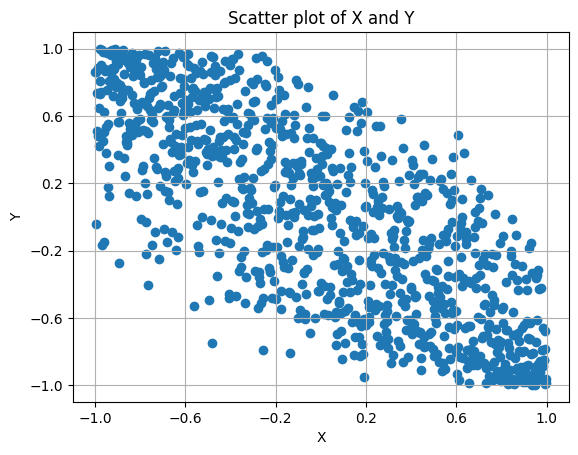

In [9]:
# 绘制散点图，横坐标是X、纵坐标是Y
import matplotlib.pyplot as plt

plt.scatter(A['X'], A['Y'])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of X and Y')
# 设置坐标轴刻度间隔0.4
plt.xticks(np.arange(-1.0, 1.01, 0.4))
plt.yticks(np.arange(-1.0, 1.01, 0.4))
# 添加网格线
plt.grid(True)
plt.show()

In [5]:
df=A.copy()
var_col='X'
dir_col='Y'
grid=5
xlim=[-1.0, 1.0]
ylim=[-1.0, 1.0]

# 定义网格边界
x_bins = np.linspace(xlim[0], xlim[1], grid + 1)
print(x_bins)
y_bins = np.linspace(ylim[0], ylim[1], grid + 1)
print(y_bins)

# 将数据点分配到相应的网格
x_bin = np.digitize(df[var_col], x_bins) - 1  # digitize 返回1-based索引
print(x_bin)
y_bin = np.digitize(df[dir_col], y_bins) - 1
print(y_bin)

# 过滤掉超出范围的点
valid = (x_bin >= 0) & (x_bin < grid) & (y_bin >= 0) & (y_bin < grid)
df_valid = df[valid].copy()
x_bin = x_bin[valid]
print(x_bin)
y_bin = y_bin[valid]
print(y_bin)

# 统计每个窗格内的数据点数量
grid_counts = {}
for xb, yb in zip(x_bin, y_bin):
    key = (xb, yb)
    print(key)
    if key in grid_counts:
        grid_counts[key] += 1
    else:
        grid_counts[key] = 1


[-1.  -0.6 -0.2  0.2  0.6  1. ]
[-1.  -0.6 -0.2  0.2  0.6  1. ]
[4 1 2 2 2 0 2 2 3 3 0 4 2 1 1 3 4 0 1 0 0 4 0 1 3 4 4 3 0 3 3 4 4 4 4 0 1
 1 2 0 2 4 2 1 3 2 1 1 0 3 4 4 4 3 3 4 4 0 4 4 2 3 4 4 0 1 0 3 0 0 1 3 3 0
 1 3 0 2 2 2 4 2 4 0 1 2 1 1 4 0 4 1 2 0 0 3 2 0 1 2 2 0 3 2 3 0 3 0 2 4 0
 4 3 0 4 0 1 2 4 4 3 3 2 1 2 4 4 0 4 3 4 2 3 4 4 1 4 1 2 1 0 3 4 1 0 1 0 1
 3 3 1 3 3 3 3 4 2 1 0 0 4 0 4 0 4 1 3 4 3 4 1 2 1 4 4 1 2 3 2 1 4 3 3 0 4
 4 0 1 1 1 3 1 1 4 2 1 1 2 4 1 1 4 4 1 3 0 4 1 2 2 0 4 2 3 3 1 0 3 3 1 4 1
 0 1 3 4 2 2 2 4 2 3 3 0 0 3 2 0 0 3 2 3 4 4 2 4 1 2 2 4 1 2 2 0 4 3 3 3 3
 3 4 4 2 4 4 3 1 2 1 4 2 4 2 4 0 4 0 2 1 2 0 0 2 2 4 3 4 0 3 4 2 0 3 2 1 0
 3 3 0 3 0 3 2 1 0 4 1 2 2 2 0 4 2 0 4 1 3 1 1 4 2 4 4 2 2 2 3 2 1 0 4 0 3
 3 3 2 2 3 1 0 3 4 2 0 1 4 0 4 2 4 2 0 0 2 1 4 4 2 4 2 4 3 1 2 0 3 0 2 0 4
 4 2 2 4 0 1 1 2 4 0 3 2 1 1 0 1 2 4 0 2 4 4 0 3 0 1 4 0 3 1 2 1 0 4 0 4 1
 4 2 4 1 4 0 1 3 0 2 2 2 3 2 4 4 0 4 0 1 3 0 3 3 1 2 1 2 0 2 4 1 2 4 4 0 3
 2 2 0 2 0 0 4 1 4 3 3 1 0 4 4 0 1 3

## 数据增强

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
X_train = pd.read_pickle('./data/X_train.pickle')
y_train = pd.read_pickle('./data/y_train.pickle')
print(len(X_train), len(y_train))

23500 23500


In [5]:
X = X_train['00000']
y = y_train['00000']
print(X)
print(y)
variables = list(X.columns)
print(variables)
dim = len(variables)
print(dim)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

In [4]:
# 提取因果关系对
edges = []
for u in y.index:
    for v in y.columns:
        if y.loc[u, v] == 1:
            edges.append((u, v))
print(edges)

[('Y', '0'), ('2', '5'), ('3', 'Y'), ('3', '5'), ('4', 'Y'), ('4', '5'), ('5', '0'), ('5', 'Y'), ('6', 'Y'), ('6', '5'), ('7', 'Y'), ('7', '5'), ('8', '2'), ('8', '3'), ('8', '7'), ('8', 'X'), ('X', 'Y'), ('X', '5')]


In [6]:
# 根据维度决定使用哪些边
if dim >= 4:
    edges_no_XY = [(u, v) for (u, v) in edges if u not in ['X', 'Y'] and v not in ['X', 'Y']]
    edges_to_use_base = edges_no_XY
    print(edges_to_use_base)
else:
    edges_to_use_base = edges

[('2', '5'), ('3', '5'), ('4', '5'), ('5', '0'), ('6', '5'), ('7', '5'), ('8', '2'), ('8', '3'), ('8', '7')]


In [7]:
# 计算每个样本需要生成的增强样本数量
augment_factor=2.5
integer_part = math.floor(augment_factor)
print(integer_part)
fractional_part = augment_factor - integer_part

2


In [ ]:
for augment_num in range(integer_part):
    # 生成整数部分的增强样本
    if dim >= 4:
        edges_to_use = edges_no_XY.copy()
    else:
        edges_to_use = edges.copy()
    
    if not edges_to_use:
        # 没有边可用，直接复制原始数据
        new_sample_id = f'{augment_num}{sample_id}'
        new_X_train[new_sample_id] = X.copy()
        new_y_train[new_sample_id] = y.copy()
        continue
    
    attempts = 0
    success = False
    while attempts < 3 and not success:
        if not edges_to_use:
            break  # 没有合适的边，跳出循环
        u, v = random.choice(edges_to_use)
        mapping = {'X': u, 'Y': v, u: 'X', v: 'Y'}
        # 应用映射到特征矩阵和标签矩阵
        X_new = apply_mapping(X, mapping)
        y_new = apply_mapping(y, mapping)
        # 检查特征矩阵是否有重复列
        if check_duplicate_columns(X_new):
            attempts += 1
            edges_to_use.remove((u, v))  # 移除当前选择，避免重复尝试
            continue  # 重试
        else:
            # 没有重复列，存储新的数据
            new_sample_id = f'{augment_num}{sample_id}'
            new_X_train[new_sample_id] = X_new
            new_y_train[new_sample_id] = y_new
            success = True
    if not success:
        # 没有找到合适的映射，复制原始数据
        new_sample_id = f'{augment_num}{sample_id}'
        new_X_train[new_sample_id] = X.copy()
        new_y_train[new_sample_id] = y.copy()

# 处理小数部分
if fractional_part > 0:
    if random.random() < fractional_part:
        augment_num = integer_part  # 例如，2.5 -> 2
        if dim >= 4:
            edges_to_use = edges_no_XY.copy()
        else:
            edges_to_use = edges.copy()
        
        if not edges_to_use:
            # 没有边可用，直接复制原始数据
            new_sample_id = f'{augment_num}{sample_id}'
            new_X_train[new_sample_id] = X.copy()
            new_y_train[new_sample_id] = y.copy()
        else:
            attempts = 0
            success = False
            while attempts < 3 and not success:
                if not edges_to_use:
                    break  # 没有合适的边，跳出循环
                u, v = random.choice(edges_to_use)
                mapping = {'X': u, 'Y': v, u: 'X', v: 'Y'}
                # 应用映射到特征矩阵和标签矩阵
                X_new = apply_mapping(X, mapping)
                y_new = apply_mapping(y, mapping)
                # 检查特征矩阵是否有重复列
                if check_duplicate_columns(X_new):
                    attempts += 1
                    edges_to_use.remove((u, v))  # 移除当前选择，避免重复尝试
                    continue  # 重试
                else:
                    # 没有重复列，存储新的数据
                    new_sample_id = f'{augment_num}{sample_id}'
                    new_X_train[new_sample_id] = X_new
                    new_y_train[new_sample_id] = y_new
                    success = True
            if not success:
                # 没有找到合适的映射，复制原始数据
                new_sample_id = f'{augment_num}{sample_id}'
                new_X_train[new_sample_id] = X.copy()
                new_y_train[new_sample_id] = y.copy()

## 处理local_datasets_describe.json

In [1]:
# 读取本地数据描述字典
import os
import json
import pandas as pd
model_directory_path = './resources'
local_datasets_describe_path = os.path.join(model_directory_path, "local_datasets_describe.json")
local_datasets_describe = json.load(open(local_datasets_describe_path, 'r', encoding='utf-8'))
print(len(local_datasets_describe))

23500


In [2]:
# 从local_datasets_describe中随机删除500个键值对
import random
keys_to_remove = random.sample(list(local_datasets_describe.keys()), 200)
print(keys_to_remove)

['10252', '35019', '29624', '12683', '28930', '16381', '39014', '08757', '43066', '13962', '24832', '07218', '18452', '08416', '35565', '38513', '39447', '00048', '27589', '31313', '30485', '20033', '05427', '45582', '01294', '15964', '13827', '04588', '12974', '38826', '38792', '42124', '21356', '10617', '37491', '12569', '14975', '16217', '07672', '12006', '18825', '10451', '00086', '35242', '09461', '33528', '29570', '36081', '32820', '22883', '33392', '12378', '41258', '02219', '09823', '46181', '43129', '42358', '46663', '14559', '22913', '33884', '35968', '37873', '31555', '02488', '46978', '40106', '06654', '24970', '39622', '02803', '18916', '16959', '09951', '34249', '21306', '06902', '32143', '43379', '36014', '07292', '37931', '39875', '25262', '41709', '16916', '40026', '44292', '00402', '40546', '23750', '14077', '18343', '11359', '46284', '09991', '05260', '23019', '19696', '22795', '35558', '22382', '17871', '43816', '19238', '20175', '39120', '26536', '46792', '22366', 

In [3]:
# 统计keys_to_remove中键的columns列表的长度，并统计每个长度有多少个样本
length_counts = {}
for key in keys_to_remove:
    columns_length = len(local_datasets_describe[key]['columns'])
    if columns_length in length_counts:
        length_counts[columns_length] += 1
    else:
        length_counts[columns_length] = 1

for length, count in length_counts.items():
    print(f"长度 {length} 的样本数量: {count}")


长度 10 的样本数量: 86
长度 7 的样本数量: 12
长度 4 的样本数量: 12
长度 9 的样本数量: 39
长度 8 的样本数量: 16
长度 6 的样本数量: 19
长度 3 的样本数量: 7
长度 5 的样本数量: 9


In [4]:
for key in keys_to_remove:
    del local_datasets_describe[key]
print(len(local_datasets_describe))
# 保存为local_datasets_describe_drop200.json
with open('local_datasets_describe_drop200.json', 'w', encoding='utf-8') as f:
    json.dump(local_datasets_describe, f, ensure_ascii=False, indent=4)

23300


## 统计类特征

In [1]:
import numpy as np
from scipy.special import psi
from scipy.stats.stats import pearsonr
from scipy.stats import skew, kurtosis
from collections import Counter, defaultdict
from sklearn.metrics import adjusted_mutual_info_score
import pandas as pd
import operator
import math

C:\Users\25105\AppData\Local\Temp\ipykernel_30900\1432028121.py:3: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [4]:
import numpy as np
from collections import Counter, defaultdict
from sklearn.metrics import adjusted_mutual_info_score


def discretize_sequence(x, ffactor=10):
    """
    将连续序列离散化。

    参数:
    x (array-like): 输入的连续变量，范围在 [-1, 1] 之间。
    ffactor (int): 离散化因子，用于缩放和离散化。

    返回:
    np.ndarray: 离散化后的序列（整数类型）。
    """
    # 确保输入在 [-1, 1] 范围内
    x = np.clip(x, -1, 1)
    # 缩放并四舍五入
    x = np.round(x * ffactor).astype(int)
    return x


def compute_discrete_probability(x):
    """
    计算离散概率分布。

    参数:
    x (iterable): 输入的离散化后的序列，可以是单变量或联合变量。

    返回:
    Counter: 元素及其计数。
    """
    return Counter(x)


def discrete_entropy(x, bias_factor=0.7):
    """
    计算离散熵。

    参数:
    x (iterable): 输入的离散化后的序列，可以是单变量或联合变量。
    bias_factor (float): 偏差因子，用于修正有限样本的熵估计。

    返回:
    float: 计算得到的熵值。
    """
    c = compute_discrete_probability(x)
    pk = np.array(list(c.values()), dtype=float)
    pk_sum = pk.sum()
    if pk_sum == 0:
        return 0.0
    pk /= pk_sum
    # 避免 log(0) 问题，添加一个很小的常数
    vec = pk * np.log(pk + 1e-12)
    S = -np.sum(vec)
    # 添加偏差项
    bias = bias_factor * (len(pk) - 1) / (2.0 * len(x))
    return S + bias


def discrete_joint_entropy(x, y):
    """
    计算两个离散序列的联合熵 H(X, Y)。

    参数:
    x, y (array-like): 输入的离散化后的序列。

    返回:
    float: 联合熵 H(X, Y)。
    """
    joint = list(zip(x, y))  # 将 x 和 y 配对
    return discrete_entropy(joint)


def normalized_error_probability(x, y):
    """
    计算归一化的错误概率。

    该函数通过构建联合概率矩阵，计算分类错误的概率，并将其归一化。

    参数:
    x, y (array-like): 输入的离散化后的序列。

    返回:
    float: 归一化的错误概率。
    """
    cx = Counter(x)
    cy = Counter(y)

    sorted_cx = sorted(cx.keys())
    sorted_cy = sorted(cy.keys())

    # 统计联合频数
    pxy = defaultdict(int)
    for a, b in zip(x, y):
        pxy[(a, b)] += 1

    total = sum(pxy.values())
    if total == 0:
        return 0.0  # 或者根据需求返回其他值

    # 构建联合概率矩阵
    pxy_matrix = np.array([
        [pxy.get((a, b), 0) for b in sorted_cy]
        for a in sorted_cx
    ], dtype=float)

    # 归一化为概率
    pxy_matrix /= total

    # 计算每行的最大概率
    max_per_row = pxy_matrix.max(axis=1)
    perr = 1 - np.sum(max_per_row)

    # 计算每列的概率和的最大值
    sum_per_column = pxy_matrix.sum(axis=0)
    max_perr = 1 - np.max(sum_per_column)

    # 归一化错误概率
    pnorm = perr / max_perr if max_perr > 0 else perr
    return pnorm


def discrete_divergence(cx, cy):
    """
    计算两个离散分布之间的KL散度（Kullback-Leibler Divergence）。

    KL散度衡量了分布 cx 相对于分布 cy 的差异，是信息论中的一个重要概念。

    参数:
    cx (Counter): 第一个离散分布的元素计数。
    cy (Counter): 第二个离散分布的元素计数。

    返回:
    float: KL散度 D_KL(cx || cy)。
    """
    # 创建 cy 的副本，避免修改原始对象
    cy = cy.copy()

    # 为了避免 cy 中某些元素的概率为零，将它们的计数设为 1
    for a in cx:
        if cy[a] == 0:
            cy[a] = 1

    # 计算概率
    nx = float(sum(cx.values()))
    ny = float(sum(cy.values()))

    kl_div = 0.0
    for a, v in cx.items():
        px = v / nx
        py = cy[a] / ny
        kl_div += px * np.log(px / py)
    return kl_div


def discrete_conditional_entropy(x, y):
    """
    计算两个离散序列的条件熵 H(X|Y)。

    条件熵衡量了在已知 Y 的情况下，X 的不确定性。

    参数:
    x, y (array-like): 输入的离散化后的序列。

    返回:
    float: 条件熵 H(X|Y)。
    """
    joint_entropy = discrete_joint_entropy(x, y)
    entropy_y = discrete_entropy(y)
    return joint_entropy - entropy_y


def adjusted_mutual_information_score(x, y):
    """
    计算两个离散序列的调整互信息（Adjusted Mutual Information, AMI）。

    AMI 是互信息的一种调整版本，考虑了随机期望的互信息，通常用于聚类评估。

    参数:
    x, y (array-like): 输入的离散化后的序列。

    返回:
    float: 调整后的互信息。
    """
    return adjusted_mutual_info_score(x, y)


def discrete_mutual_information(x, y):
    """
    计算两个离散序列的互信息 I(X; Y)。

    互信息衡量了两个变量之间共享的信息量，是信息论中的一个基本概念。

    参数:
    x, y (array-like): 输入的离散化后的序列。

    返回:
    float: 互信息 I(X; Y)。
    """
    entropy_x = discrete_entropy(x)
    entropy_y = discrete_entropy(y)
    joint_entropy = discrete_joint_entropy(x, y)
    mutual_info = entropy_x + entropy_y - joint_entropy
    # 避免由于数值误差导致的负值
    mutual_info = max(mutual_info, 0)
    return mutual_info

In [9]:
# 示例数据
A = pd.read_csv('./data/A.csv', index_col=0)
print(A)
B = pd.read_csv('./data/B.csv', index_col=0)
print(B)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

In [10]:
x = A['0'].values
y = A['X'].values

# 一次性离散化 x 和 y
ffactor = 10
x_discrete = discretize_sequence(x, ffactor=ffactor)
y_discrete = discretize_sequence(y, ffactor=ffactor)

# 计算联合熵
H_xy = discrete_joint_entropy(x_discrete, y_discrete)
print(f"联合熵 H(X, Y): {H_xy}")

# 计算条件熵 H(X|Y)
H_X_given_Y = discrete_conditional_entropy(x_discrete, y_discrete)
print(f"条件熵 H(X|Y): {H_X_given_Y}")

# 计算互信息 I(X; Y)
I_XY = discrete_mutual_information(x_discrete, y_discrete)
print(f"互信息 I(X; Y): {I_XY}")

# 计算调整互信息 AMI
AMI_XY = adjusted_mutual_information_score(x_discrete, y_discrete)
print(f"调整互信息 AMI(X; Y): {AMI_XY}")

# 计算归一化的错误概率
error_prob = normalized_error_probability(x_discrete, y_discrete)
print(f"归一化的错误概率: {error_prob}")

# 计算KL散度
cx = Counter(x_discrete)
cy = Counter(y_discrete)
kl_div = discrete_divergence(cx, cy)
print(f"KL散度 D_KL(cx || cy): {kl_div}")

联合熵 H(X, Y): 5.963856315406975
条件熵 H(X|Y): 2.9264666828459873
互信息 I(X; Y): 0.11092294971500039
调整互信息 AMI(X; Y): 0.0023848154900889865
归一化的错误概率: 0.9231578947368422
KL散度 D_KL(cx || cy): 0.0


In [12]:
x = A['0'].values
y = A['Y'].values

# 一次性离散化 x 和 y
ffactor = 10
x_discrete = discretize_sequence(x, ffactor=ffactor)
y_discrete = discretize_sequence(y, ffactor=ffactor)

# 计算联合熵
H_xy = discrete_joint_entropy(x_discrete, y_discrete)
print(f"联合熵 H(X, Y): {H_xy}")

# 计算条件熵 H(X|Y)
H_X_given_Y = discrete_conditional_entropy(x_discrete, y_discrete)
print(f"条件熵 H(X|Y): {H_X_given_Y}")

# 计算互信息 I(X; Y)
I_XY = discrete_mutual_information(x_discrete, y_discrete)
print(f"互信息 I(X; Y): {I_XY}")

# 计算调整互信息 AMI
AMI_XY = adjusted_mutual_information_score(x_discrete, y_discrete)
print(f"调整互信息 AMI(X; Y): {AMI_XY}")

# 计算归一化的错误概率
error_prob = normalized_error_probability(x_discrete, y_discrete)
print(f"归一化的错误概率: {error_prob}")

# 计算KL散度
cx = Counter(x_discrete)
cy = Counter(y_discrete)
kl_div = discrete_divergence(cx, cy)
print(f"KL散度 D_KL(cx || cy): {kl_div}")

联合熵 H(X, Y): 5.905751570388476
条件熵 H(X|Y): 2.8683619378274883
互信息 I(X; Y): 0.16902769473349988
调整互信息 AMI(X; Y): 0.020115600225146437
归一化的错误概率: 0.9294736842105263
KL散度 D_KL(cx || cy): 0.0


In [13]:
x = A['X'].values
y = A['Y'].values

# 一次性离散化 x 和 y
ffactor = 10
x_discrete = discretize_sequence(x, ffactor=ffactor)
y_discrete = discretize_sequence(y, ffactor=ffactor)

# 计算联合熵
H_xy = discrete_joint_entropy(x_discrete, y_discrete)
print(f"联合熵 H(X, Y): {H_xy}")

# 计算条件熵 H(X|Y)
H_X_given_Y = discrete_conditional_entropy(x_discrete, y_discrete)
print(f"条件熵 H(X|Y): {H_X_given_Y}")

# 计算互信息 I(X; Y)
I_XY = discrete_mutual_information(x_discrete, y_discrete)
print(f"互信息 I(X; Y): {I_XY}")

# 计算调整互信息 AMI
AMI_XY = adjusted_mutual_information_score(x_discrete, y_discrete)
print(f"调整互信息 AMI(X; Y): {AMI_XY}")

# 计算归一化的错误概率
error_prob = normalized_error_probability(x_discrete, y_discrete)
print(f"归一化的错误概率: {error_prob}")

# 计算KL散度
cx = Counter(x_discrete)
cy = Counter(y_discrete)
kl_div = discrete_divergence(cx, cy)
print(f"KL散度 D_KL(cx || cy): {kl_div}")

联合熵 H(X, Y): 5.546710138120271
条件熵 H(X|Y): 2.5093205055592827
互信息 I(X; Y): 0.5280691270017046
调整互信息 AMI(X; Y): 0.13733145050046267
归一化的错误概率: 0.8694736842105263
KL散度 D_KL(cx || cy): 0.0


In [20]:
import numpy as np
from collections import Counter, defaultdict
from scipy.special import psi
from scipy.stats import skew, kurtosis, pearsonr
from sklearn.metrics import adjusted_mutual_info_score
# 如果需要使用 HSIC，请确保安装相应的包并取消注释以下行
# from hsic import FastHsicTestGamma  


# -------------------
# Helper Functions
# -------------------

def normalize_discrete(x):
    """
    对离散化后的序列进行标准化处理。

    参数:
    x (array-like): 离散化后的x序列。

    返回:
    np.ndarray: 标准化后的x序列。
    """
    if len(set(x)) < 2:
        return np.zeros_like(x, dtype=float)
    x_mean = np.mean(x)
    x_std = np.std(x)
    if x_std > 0:
        return (x - x_mean) / x_std
    else:
        return x - x_mean


def to_numerical(x_discrete, y_continuous):
    """
    将类别型的离散x转换为数值型，通过将每个唯一的x值替换为对应y的平均值。

    参数:
    x_discrete (array-like): 离散化后的x数组。
    y_continuous (array-like): 与x对应的连续y数组。

    返回:
    np.ndarray: 数值型的x数组，每个x值被替换为对应的y平均值。
    """
    dx = defaultdict(lambda: [0.0, 0])
    for a, b in zip(x_discrete, y_continuous):
        dx[a][0] += b
        dx[a][1] += 1
    for a in dx:
        dx[a][0] /= dx[a][1] if dx[a][1] > 0 else 1e-12
    x_numerical = np.array([dx[a][0] for a in x_discrete], dtype=float)
    x_numerical = (x_numerical - np.mean(x_numerical)) / np.std(x_numerical) if np.std(x_numerical) > 0 else x_numerical
    return x_numerical


def count_unique(x):
    """
    计算数组中唯一元素的数量。

    参数:
    x (array-like): 输入数组。

    返回:
    int: 唯一元素的数量。
    """
    return len(set(x))


# -------------------
# Feature Engineering Functions
# -------------------

def normalized_entropy_baseline(x):
    """
    计算给定归一化x的标准化熵基线。

    参数:
    x (array-like): 离散且归一化的x序列。

    返回:
    float: 标准化熵基线值。
    """
    if len(set(x)) < 2:
        return 0.0
    xs = np.sort(x)
    delta = xs[1:] - xs[:-1]
    delta = delta[delta != 0]
    if len(delta) == 0:
        return 0.0
    hx = np.mean(np.log(delta))
    hx += psi(len(delta))
    hx -= psi(1)
    return hx


def normalized_entropy(x, m=2):
    """
    计算标准化熵。

    参数:
    x (array-like): 离散且归一化的x序列。
    m (int): delta计算的参数。

    返回:
    float: 标准化熵值。
    """
    cx = Counter(x)
    if len(cx) < 2:
        return 0.0
    xk = np.array(list(cx.keys()), dtype=float)
    xk.sort()
    if len(xk) < 2:
        return 0.0
    delta = (xk[1:] - xk[:-1]) / m
    counter = np.array([cx[i] for i in xk], dtype=float)
    hx = np.sum(counter[1:] * np.log(delta / counter[1:])) / len(x)
    hx += (psi(len(delta)) - np.log(len(delta)))
    hx += np.log(len(x))
    hx -= (psi(m) - np.log(m))
    return hx


def igci(x, y):
    """
    计算IGCI（信息几何因果推断）度量。

    参数:
    x (array-like): 离散且归一化的x序列。
    y (array-like): 离散且归一化的y序列。

    返回:
    float: IGCI度量值。
    """
    # 检查是否有足够的唯一值
    if len(set(x)) < 2:
        return 0.0
    
    # 判断是否有重复的x值
    if len(x) != len(set(x)):
        dx = defaultdict(lambda: [0.0, 0])
        for a, b in zip(x, y):
            dx[a][0] += b
            dx[a][1] += 1
        for a in dx:
            dx[a][0] /= dx[a][1] if dx[a][1] > 0 else 1e-12
        # 构建联合序列
        xy = np.array([[a, dx[a][0]] for a in dx.keys()], dtype=float)
        # 获取每个x的计数
        counter = np.array([dx[a][1] for a in xy[:, 0]], dtype=float)
    else:
        # 如果x没有重复，直接排序
        xy = np.array(sorted(zip(x, y)), dtype=float)
        counter = np.ones(len(x))
    
    # 计算相邻差值
    delta = xy[1:] - xy[:-1]
    # 选择y差值不为0的样本
    selec = delta[:, 1] != 0
    delta = delta[selec]
    counter = np.minimum(counter[1:], counter[:-1])[selec]
    
    if len(delta) == 0:
        return 0.0
    
    # 添加一个极小值epsilon，避免log(0)
    epsilon = 1e-12
    ratio = (delta[:, 0] + epsilon) / np.abs(delta[:, 1])
    ratio = np.where(ratio > 0, ratio, epsilon)
    
    # 计算 hxy，避免返回 NaN
    with np.errstate(divide='ignore', invalid='ignore'):
        hxy = np.sum(counter * np.log(ratio)) / len(x)
    
    # 检查 hxy 是否为有效数值
    if np.isnan(hxy):
        return 0.0
    
    return hxy


def uniform_divergence(x, m=2):
    """
    计算统一散度。

    参数:
    x (array-like): 离散且归一化的x序列。
    m (int): delta计算的参数。

    返回:
    float: 统一散度值。
    """
    cx = Counter(x)
    xk = np.array(list(cx.keys()), dtype=float)
    xk.sort()
    delta = np.zeros(len(xk))
    if len(xk) > 1:
        delta[0] = xk[1] - xk[0]
        if len(xk) > m:
            delta[1:-1] = (xk[m:] - xk[:-m]) / m
        else:
            delta[1:-1] = (xk[-1] - xk[0]) / (len(xk) - 1)
        delta[-1] = xk[-1] - xk[-2]
    else:
        delta = np.array([np.sqrt(12)], dtype=float)  # 假设均匀分布在[-1,1]

    counter = np.array([cx[i] for i in xk], dtype=float)
    delta_sum = np.sum(delta)
    if delta_sum > 0:
        delta = delta / delta_sum
    else:
        delta = delta
    if len(xk) > 1:
        hx = np.sum(counter * np.log(counter / delta)) / len(x)
    else:
        hx = 0.0
    hx -= np.log(len(x))
    hx += (psi(m) - np.log(m))
    return hx


def normalized_skewness(x):
    """
    计算x的标准化偏度。

    参数:
    x (array-like): 离散且归一化的x序列。

    返回:
    float: 标准化偏度值。
    """
    return skew(x)


def normalized_kurtosis(x):
    """
    计算x的标准化峰度。

    参数:
    x (array-like): 离散且归一化的x序列。

    返回:
    float: 标准化峰度值。
    """
    return kurtosis(x)


def normalized_moment(x, y, n, m):
    """
    计算x和y的标准化联合矩。

    参数:
    x (array-like): 离散且归一化的x序列。
    y (array-like): 离散且归一化的y序列。
    n (int): x的幂次。
    m (int): y的幂次。

    返回:
    float: 标准化的联合矩值。
    """
    return np.mean((x ** n) * (y ** m))


def moment21(x, y):
    """
    计算标准化联合矩 I(X^2 * Y)。

    参数:
    x (array-like): 离散且归一化的x序列。
    y (array-like): 离散且归一化的y序列。

    返回:
    float: 联合矩 I(X^2 * Y)。
    """
    return normalized_moment(x, y, 2, 1)


def moment22(x, y):
    """
    计算标准化联合矩 I(X^2 * Y^2)。

    参数:
    x (array-like): 离散且归一化的x序列。
    y (array-like): 离散且归一化的y序列。

    返回:
    float: 联合矩 I(X^2 * Y^2)。
    """
    return normalized_moment(x, y, 2, 2)


def moment31(x, y):
    """
    计算标准化联合矩 I(X^3 * Y)。

    参数:
    x (array-like): 离散且归一化的x序列。
    y (array-like): 离散且归一化的y序列。

    返回:
    float: 联合矩 I(X^3 * Y)。
    """
    return normalized_moment(x, y, 3, 1)


def fit(x, y):
    """
    拟合多项式到x和y，并基于系数计算一个复杂的度量值。

    参数:
    x (array-like): 离散且归一化的x序列（数值型）。
    y (array-like): 离散且归一化的y序列（数值型）。

    返回:
    float: 拟合度量值。
    """
    if count_unique(x) <= 2 or count_unique(y) <= 2:
        return 0.0
    x_std = x if np.std(x) == 1 else (x - np.mean(x)) / np.std(x) if np.std(x) > 0 else x
    y_std = y if np.std(y) == 1 else (y - np.mean(y)) / np.std(y) if np.std(y) > 0 else y
    try:
        xy1 = np.polyfit(x_std, y_std, 1)
        xy2 = np.polyfit(x_std, y_std, 2)
        return abs(2 * xy2[0]) + abs(xy2[1] - xy1[0])
    except np.RankWarning:
        return 0.0
    except Exception:
        return 0.0


def fit_error(x, y, m=2):
    """
    计算x和y之间的拟合误差。

    参数:
    x (array-like): 离散且归一化的x序列。
    y (array-like): 离散且归一化的y序列。
    m (int): 拟合时使用的多项式的阶数。

    返回:
    float: 拟合误差。
    """
    if count_unique(x) <= m or count_unique(y) <= m:
        poly_degree = min(count_unique(x), count_unique(y)) - 1
    else:
        poly_degree = m

    if poly_degree < 1:
        return 0.0

    try:
        poly = np.polyfit(x, y, poly_degree)
        y_pred = np.polyval(poly, x)
        return np.std(y - y_pred)
    except np.RankWarning:
        return 0.0
    except Exception:
        return 0.0


def fit_noise_entropy(x, y, minc=10):
    """
    计算拟合噪声熵。

    参数:
    x (array-like): 离散且归一化的x序列。
    y (array-like): 离散且归一化的y序列。
    minc (int): 计算熵的最小计数阈值。

    返回:
    float: 拟合噪声熵。
    """
    cx = Counter(x)
    entyx = []
    for a in cx:
        if cx[a] > minc:
            y_subset = y[x == a]
            entyx.append(discrete_entropy(y_subset))
    if len(entyx) == 0:
        return 0.0
    n = count_unique(y)
    return np.std(entyx) / np.log(n) if n > 0 else 0.0


def fit_noise_skewness(x, y, minc=8):
    """
    计算拟合噪声偏度的标准差。

    参数:
    x (array-like): 离散且归一化的x序列。
    y (array-like): 离散且归一化的y序列。
    minc (int): 计算偏度的最小计数阈值。

    返回:
    float: 拟合噪声偏度的标准差。
    """
    cx = Counter(x)
    skewyx = []
    for a in cx:
        if cx[a] >= minc:
            y_subset = y[x == a]
            skewyx.append(normalized_skewness(y_subset))
    if len(skewyx) == 0:
        return 0.0
    return np.std(skewyx)


def fit_noise_kurtosis(x, y, minc=8):
    """
    计算拟合噪声峰度的标准差。

    参数:
    x (array-like): 离散且归一化的x序列。
    y (array-like): 离散且归一化的y序列。
    minc (int): 计算峰度的最小计数阈值。

    返回:
    float: 拟合噪声峰度的标准差。
    """
    cx = Counter(x)
    kurtyx = []
    for a in cx:
        if cx[a] >= minc:
            y_subset = y[x == a]
            kurtyx.append(normalized_kurtosis(y_subset))
    if len(kurtyx) == 0:
        return 0.0
    return np.std(kurtyx)


def conditional_distribution_similarity(x, y, minc=12):
    """
    计算条件分布相似性。

    参数:
    x (array-like): 离散且归一化的x序列。
    y (array-like): 离散且归一化的y序列。
    minc (int): 计算条件分布的最小计数阈值。

    返回:
    float: 条件分布相似性度量。
    """
    cx = Counter(x)
    cy = Counter(y)
    yrange = sorted(cy.keys())
    ny = len(yrange)

    py = np.array([cy[i] for i in yrange], dtype=float)
    py = py / py.sum() if py.sum() > 0 else py

    pyx = []
    for a in cx:
        if cx[a] > minc:
            yx = y[x == a]
            cyx = Counter(yx)
            pyxa = np.array([cyx.get(i, 0.0) for i in yrange], dtype=float)
            if pyxa.sum() == 0:
                continue
            pyxa = pyxa / pyxa.sum()
            pyx.append(py * pyxa)  # 修正这里，将 pyx * pyxa 改为 py * pyxa

    if len(pyx) == 0:
        return 0.0

    pyx = np.array(pyx)
    pyx = pyx - pyx.mean(axis=0)
    return np.std(pyx)

In [24]:
# 示例数据0-X
x_continuous = A['0'].values
y_continuous = A['X'].values

# 离散化因子
ffactor = 10

# 一次性离散化 x 和 y
x_discrete = discretize_sequence(x_continuous, ffactor=ffactor)
y_discrete = discretize_sequence(y_continuous, ffactor=ffactor)

# 归一化 x 和 y
x_normalized = normalize_discrete(x_discrete)
y_normalized = normalize_discrete(y_discrete)

# 计算各种特征
H_baseline = normalized_entropy_baseline(x_normalized)
print(f"标准化熵基线 H_baseline: {H_baseline}")

H_entropy = normalized_entropy(x_normalized)
print(f"标准化熵 H_entropy: {H_entropy}")

igci_value = igci(x_normalized, y_normalized)
print(f"IGCI 值: {igci_value}")

uniform_div = uniform_divergence(x_normalized)
print(f"统一散度 uniform_div: {uniform_div}")

moment_21 = moment21(x_normalized, y_normalized)
print(f"I(X^2 * Y) moment21: {moment_21}")

moment_22 = moment22(x_normalized, y_normalized)
print(f"I(X^2 * Y^2) moment22: {moment_22}")

moment_31 = moment31(x_normalized, y_normalized)
print(f"I(X^3 * Y) moment31: {moment_31}")

fit_val = fit(x_normalized, y_normalized)
print(f"拟合度量值 fit: {fit_val}")

fit_err = fit_error(x_normalized, y_normalized, m=2)
print(f"拟合误差 fit_error: {fit_err}")

fit_noise_ent = fit_noise_entropy(x_normalized, y_normalized, minc=8)
print(f"拟合噪声熵 fit_noise_entropy: {fit_noise_ent}")

fit_noise_skew = fit_noise_skewness(x_normalized, y_normalized, minc=8)
print(f"拟合噪声偏度标准差 fit_noise_skewness: {fit_noise_skew}")

fit_noise_kurt = fit_noise_kurtosis(x_normalized, y_normalized, minc=8)
print(f"拟合噪声峰度标准差 fit_noise_kurtosis: {fit_noise_kurt}")

cond_dist_sim = conditional_distribution_similarity(x_normalized, y_normalized, minc=8)
print(f"条件分布相似性 conditional_distribution_similarity: {cond_dist_sim}")

标准化熵基线 H_baseline: 1.7919669377281715
标准化熵 H_entropy: 0.968319189877259
IGCI 值: -9.705320511739641
统一散度 uniform_div: -0.2562300403200428
I(X^2 * Y) moment21: 0.038525953069210514
I(X^2 * Y^2) moment22: 0.9599304967698821
I(X^3 * Y) moment31: 0.45571307640899983
拟合度量值 fit: 0.09491411191904187
拟合误差 fit_error: 0.9842934553251242
拟合噪声熵 fit_noise_entropy: 0.05911594630700422
拟合噪声偏度标准差 fit_noise_skewness: 0.35599682572877883
拟合噪声峰度标准差 fit_noise_kurtosis: 0.3657922269460373
条件分布相似性 conditional_distribution_similarity: 0.0016511424714316263


In [25]:
# 示例数据X-0
x_continuous = A['X'].values
y_continuous = A['0'].values

# 离散化因子
ffactor = 10

# 一次性离散化 x 和 y
x_discrete = discretize_sequence(x_continuous, ffactor=ffactor)
y_discrete = discretize_sequence(y_continuous, ffactor=ffactor)

# 归一化 x 和 y
x_normalized = normalize_discrete(x_discrete)
y_normalized = normalize_discrete(y_discrete)

# 计算各种特征
H_baseline = normalized_entropy_baseline(x_normalized)
print(f"标准化熵基线 H_baseline: {H_baseline}")

H_entropy = normalized_entropy(x_normalized)
print(f"标准化熵 H_entropy: {H_entropy}")

igci_value = igci(x_normalized, y_normalized)
print(f"IGCI 值: {igci_value}")

uniform_div = uniform_divergence(x_normalized)
print(f"统一散度 uniform_div: {uniform_div}")

moment_21 = moment21(x_normalized, y_normalized)
print(f"I(X^2 * Y) moment21: {moment_21}")

moment_22 = moment22(x_normalized, y_normalized)
print(f"I(X^2 * Y^2) moment22: {moment_22}")

moment_31 = moment31(x_normalized, y_normalized)
print(f"I(X^3 * Y) moment31: {moment_31}")

fit_val = fit(x_normalized, y_normalized)
print(f"拟合度量值 fit: {fit_val}")

fit_err = fit_error(x_normalized, y_normalized, m=2)
print(f"拟合误差 fit_error: {fit_err}")

fit_noise_ent = fit_noise_entropy(x_normalized, y_normalized, minc=8)
print(f"拟合噪声熵 fit_noise_entropy: {fit_noise_ent}")

fit_noise_skew = fit_noise_skewness(x_normalized, y_normalized, minc=8)
print(f"拟合噪声偏度标准差 fit_noise_skewness: {fit_noise_skew}")

fit_noise_kurt = fit_noise_kurtosis(x_normalized, y_normalized, minc=8)
print(f"拟合噪声峰度标准差 fit_noise_kurtosis: {fit_noise_kurt}")

cond_dist_sim = conditional_distribution_similarity(x_normalized, y_normalized, minc=8)
print(f"条件分布相似性 conditional_distribution_similarity: {cond_dist_sim}")

标准化熵基线 H_baseline: 1.7919669377281715
标准化熵 H_entropy: 0.968319189877259
IGCI 值: -11.640409340031193
统一散度 uniform_div: -0.2562300403200428
I(X^2 * Y) moment21: 0.0785062995474595
I(X^2 * Y^2) moment22: 0.9599304967698821
I(X^3 * Y) moment31: 0.3413214524392961
拟合度量值 fit: 0.1934113268583205
拟合误差 fit_error: 0.9813612641252284
拟合噪声熵 fit_noise_entropy: 0.027423082428460845
拟合噪声偏度标准差 fit_noise_skewness: 0.1958557151869066
拟合噪声峰度标准差 fit_noise_kurtosis: 0.13895830723939173
条件分布相似性 conditional_distribution_similarity: 0.0015072620522947806


In [26]:
# 示例数据0-Y
x_continuous = A['0'].values
y_continuous = A['Y'].values

# 离散化因子
ffactor = 10

# 一次性离散化 x 和 y
x_discrete = discretize_sequence(x_continuous, ffactor=ffactor)
y_discrete = discretize_sequence(y_continuous, ffactor=ffactor)

# 归一化 x 和 y
x_normalized = normalize_discrete(x_discrete)
y_normalized = normalize_discrete(y_discrete)

# 计算各种特征
H_baseline = normalized_entropy_baseline(x_normalized)
print(f"标准化熵基线 H_baseline: {H_baseline}")

H_entropy = normalized_entropy(x_normalized)
print(f"标准化熵 H_entropy: {H_entropy}")

igci_value = igci(x_normalized, y_normalized)
print(f"IGCI 值: {igci_value}")

uniform_div = uniform_divergence(x_normalized)
print(f"统一散度 uniform_div: {uniform_div}")

moment_21 = moment21(x_normalized, y_normalized)
print(f"I(X^2 * Y) moment21: {moment_21}")

moment_22 = moment22(x_normalized, y_normalized)
print(f"I(X^2 * Y^2) moment22: {moment_22}")

moment_31 = moment31(x_normalized, y_normalized)
print(f"I(X^3 * Y) moment31: {moment_31}")

fit_val = fit(x_normalized, y_normalized)
print(f"拟合度量值 fit: {fit_val}")

fit_err = fit_error(x_normalized, y_normalized, m=2)
print(f"拟合误差 fit_error: {fit_err}")

fit_noise_ent = fit_noise_entropy(x_normalized, y_normalized, minc=8)
print(f"拟合噪声熵 fit_noise_entropy: {fit_noise_ent}")

fit_noise_skew = fit_noise_skewness(x_normalized, y_normalized, minc=8)
print(f"拟合噪声偏度标准差 fit_noise_skewness: {fit_noise_skew}")

fit_noise_kurt = fit_noise_kurtosis(x_normalized, y_normalized, minc=8)
print(f"拟合噪声峰度标准差 fit_noise_kurtosis: {fit_noise_kurt}")

cond_dist_sim = conditional_distribution_similarity(x_normalized, y_normalized, minc=8)
print(f"条件分布相似性 conditional_distribution_similarity: {cond_dist_sim}")

标准化熵基线 H_baseline: 1.7919669377281715
标准化熵 H_entropy: 0.968319189877259
IGCI 值: -9.486098320158993
统一散度 uniform_div: -0.2562300403200428
I(X^2 * Y) moment21: 0.0023827296275736637
I(X^2 * Y^2) moment22: 0.8656074849632437
I(X^3 * Y) moment31: -0.37675918912898204
拟合度量值 fit: 0.005870190054430787
拟合误差 fit_error: 0.9933082977972205
拟合噪声熵 fit_noise_entropy: 0.05517096650461803
拟合噪声偏度标准差 fit_noise_skewness: 0.27739228027076557
拟合噪声峰度标准差 fit_noise_kurtosis: 0.29962870897894484
条件分布相似性 conditional_distribution_similarity: 0.001679172388844173


: 

## Grasp

In [4]:
import pandas as pd
import numpy as np
A = pd.read_csv('./data/A.csv', index_col=0)
print(A)
B = pd.read_csv('./data/B.csv', index_col=0)
print(B)

         0      Y      2      3      4      5      6      7      8      X
0    0.311 -0.365  0.327  0.383 -0.519 -0.015 -0.713  0.183  0.515  0.951
1    0.125  0.657 -0.097 -0.341 -0.807 -0.527 -0.027  0.711  0.591 -0.515
2    0.499 -0.307 -0.395  0.067  0.761 -0.147 -0.501  0.015  0.267  0.109
3   -0.337 -0.105  0.455  0.267 -0.091  0.427  0.037 -0.221 -0.455  0.157
4   -0.139 -0.691 -0.287 -0.383 -0.899  0.415  0.899 -0.771 -0.593 -0.049
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
995 -0.965  0.853 -0.187  0.319 -0.841  0.281  0.795  0.599  0.245 -0.931
996  0.323  0.851  0.775 -0.187  0.361 -0.681 -0.307  0.351  0.433 -0.829
997  0.795  0.409 -0.629 -0.879  0.035 -0.761  0.301  0.355  0.941  0.363
998  0.855 -0.721  0.193 -0.025  0.485 -0.351 -0.799 -0.007 -0.329  0.715
999 -0.851 -0.395 -0.925  0.831 -0.275  0.981  0.607 -0.773 -0.691  0.001

[1000 rows x 10 columns]
        0  Y  2  3  4  5  6  7  8  X
parent                              
0       0  0

In [5]:
from causallearn.search.PermutationBased.GRaSP import grasp
import warnings

def handle_multicollinearity(data, epsilon=1e-7, corr_threshold=0.99):
    """
    检查数据中的多重共线性，并在需要时向存在多重共线性的列添加随机扰动。
    
    参数:
    - data (np.ndarray): 输入的数据矩阵，形状为 (样本数, 特征数)。
    - epsilon (float): 添加的随机扰动的尺度，默认值为1e-10。
    - corr_threshold (float): 判断高相关性的阈值，默认值为0.95。
    
    返回:
    - data (np.ndarray): 处理后的数据矩阵。
    """
    # 计算相关系数矩阵
    corr_matrix = np.corrcoef(data, rowvar=False)
    n_cols = corr_matrix.shape[0]

    # 使用集合存储所有涉及多重共线性的列索引，避免重复
    high_corr_indices = set()
    
    # 遍历相关系数矩阵的上三角部分，寻找高相关的列对
    for i in range(n_cols):
        for j in range(i+1, n_cols):
            if np.abs(corr_matrix[i, j]) > corr_threshold:
                high_corr_indices.add(i)
                high_corr_indices.add(j)
    
    if high_corr_indices:
        sorted_indices = sorted(high_corr_indices)
        # print(f"检测到多重共线性，涉及的列索引: {sorted_indices}。正在添加随机扰动...")
        
        # 生成与高相关性列对应的随机扰动
        noise = np.random.normal(0, epsilon, (data.shape[0], len(sorted_indices)))
        
        # 将扰动添加到相应的列
        data[:, sorted_indices] += noise
    
    return data

def GRaSP_estimate(dataset, score_func='local_score_BIC', maxP=None):    
    warnings.filterwarnings("ignore")
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    parameters = {
        'kfold': 2,         # 2 折交叉验证
        'lambda': 0.01      # 正则化参数
    }

    # 2. 运行grasp算法
    G = grasp(
        data, 
        score_func=score_func, 
        maxP=maxP,
        # verbose=False,  # 现版本没有这个参数
        parameters=parameters,
    )

    # 3. 获取邻接矩阵
    adj_matrix = G.graph
    
    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

C = GRaSP_estimate(A)
print(C)

GRaSP edge count: 17    
GRaSP completed in: 0.23s 
   0  Y  2  3  4  5  6  7  8  X
0  0  1  0  0  0  1  0  0  0  0
Y -1  0  0 -1  0 -1  1  1 -1 -1
2  0  0  0  0  0  0  0  0  1  0
3  0  1  0  0  0 -1  0  0  0  0
4  0  0  0  0  0 -1  0  0  0  0
5 -1  1  0  1  1  0  1  1  0 -1
6  0 -1  0  0  0 -1  0  0  0 -1
7  0 -1  0  0  0 -1  0  0 -1 -1
8  0  1 -1  0  0  0  0  1  0  0
X  0  1  0  0  0  1  1  1  0  0


In [7]:
"""Grasp的工具函数"""
import random
import sys
import time
import warnings
from typing import Any, Dict, List, Optional

import numpy as np
from causallearn.graph.GeneralGraph import GeneralGraph
from causallearn.graph.GraphNode import GraphNode
from causallearn.score.LocalScoreFunction import (
    local_score_BDeu,
    local_score_BIC,
    local_score_BIC_from_cov,
    local_score_cv_general,
    local_score_cv_multi,
    local_score_marginal_general,
    local_score_marginal_multi,
)
from causallearn.score.LocalScoreFunctionClass import LocalScoreClass
from causallearn.utils.DAG2CPDAG import dag2cpdag

class GSTNode:

    def __init__(self, tree, add=None, score=None):
        if score is None: score = -tree.score.score_nocache(tree.vertex, [])
        # if score is None: score = -tree.score.score(tree.vertex, [])
        self.tree = tree
        self.add = add
        self.grow_score = score
        self.shrink_score = score
        self.branches = None
        self.remove = None

    def __lt__(self, other):
        return self.grow_score < other.grow_score

    def grow(self, available, parents):
        self.branches = []
        for add in available:
            parents.append(add)
            score = -self.tree.score.score_nocache(self.tree.vertex, parents)
            # score = -self.tree.score.score(self.tree.vertex, parents)
            parents.remove(add)
            branch = GSTNode(self.tree, add, score)
            if score > self.grow_score: self.branches.append(branch)
        self.branches.sort()

    def shrink(self, parents):
        self.remove = []
        while True:
            best = None
            for remove in [parent for parent in parents]:
                parents.remove(remove)
                score = -self.tree.score.score_nocache(self.tree.vertex, parents)
                # score = -self.tree.score.score(self.tree.vertex, parents)
                parents.append(remove)
                if score > self.shrink_score:
                    self.shrink_score = score
                    best = remove
            if best is None: break
            self.remove.append(best)
            parents.remove(best)

    def trace(self, prefix, available, parents):
        if self.branches is None: self.grow(available, parents)
        for branch in self.branches:
            available.remove(branch.add)
            if branch.add in prefix:
                parents.append(branch.add)
                return branch.trace(prefix, available, parents)
        if self.remove is None:
            self.shrink(parents)
            return self.shrink_score
        for remove in self.remove: parents.remove(remove)
        return self.shrink_score

class GST:

    def __init__(self, vertex, score):
        self.vertex = vertex
        self.score = score
        self.root = GSTNode(self)
        self.forbidden = [vertex]
        self.required = []

    def trace(self, prefix, parents=None):
        if parents is None: parents = []
        available = [i for i in range(self.score.data.shape[1]) if i not in self.forbidden]
        return self.root.trace(prefix, available, parents)

    def set_knowledge(self, forbidden, required):
        self.forbidden = forbidden  # not implemented
        self.required = required  # not implemented
        self.reset()

    def reset(self):
        self.root = GSTNode(self)

class Order:
    def __init__(self, p, score):

        self.order = list(range(p))
        self.parents = {}
        self.local_scores = {}
        self.edges = 0

        random.shuffle(self.order)

        for i in range(p):
            y = self.order[i]
            self.parents[y] = []
            self.local_scores[y] = -score.score(y, [])
            # self.local_scores[y] = -score.score_nocache(y, [])

    def get(self, i):
        return self.order[i]

    def set(self, i, y):
        self.order[i] = y

    def index(self, y):
        return self.order.index(y)

    def insert(self, i, y):
        self.order.insert(i, y)

    def pop(self, i=-1):
        return self.order.pop(i)

    def get_parents(self, y):
        return self.parents[y]

    def set_parents(self, y, y_parents):
        self.parents[y] = y_parents

    def get_local_score(self, y):
        return self.local_scores[y]

    def set_local_score(self, y, local_score):
        self.local_scores[y] = local_score

    def get_edges(self):
        return self.edges

    def set_edges(self, edges):
        self.edges = edges

    def bump_edges(self, bump):
        self.edges += bump

    def len(self):
        return len(self.order)

def grasp(
    X: np.ndarray,
    score_func: str = "local_score_BIC_from_cov",
    depth: Optional[int] = 3,
    parameters: Optional[Dict[str, Any]] = None,
    verbose: Optional[bool] = True,
    node_names: Optional[List[str]] = None,
) -> GeneralGraph:
    """
    Perform a greedy relaxation of the sparsest permutation (GRaSP) algorithm

    Parameters
    ----------
    X : data set (numpy ndarray), shape (n_samples, n_features). The input data, where n_samples is the number of samples and n_features is the number of features.
    score_func : the string name of score function. (str(one of 'local_score_CV_general', 'local_score_marginal_general',
                    'local_score_CV_multi', 'local_score_marginal_multi', 'local_score_BIC', 'local_score_BIC_from_cov', 'local_score_BDeu')).
    depth : allowed maximum depth for DFS
    parameters : when using CV likelihood,
                  parameters['kfold']: k-fold cross validation
                  parameters['lambda']: regularization parameter
                  parameters['dlabel']: for variables with multi-dimensions,
                               indicate which dimensions belong to the i-th variable.
    verbose : whether to print the time cost and verbose output of the algorithm.

    Returns
    -------
    G : learned causal graph, where G.graph[j,i] = 1 and G.graph[i,j] = -1 indicates i --> j, G.graph[i,j] = G.graph[j,i] = -1 indicates i --- j.
    """

    X = X.copy()
    n, p = X.shape
    if n < p:
        warnings.warn("The number of features is much larger than the sample size!")

    if score_func == "local_score_CV_general":  
        # k-fold negative cross validated likelihood based on regression in RKHS
        if parameters is None:
            parameters = {
                "kfold": 10,  # 10 fold cross validation
                "lambda": 0.01,
            }  # regularization parameter
        localScoreClass = LocalScoreClass(
            data=X, local_score_fun=local_score_cv_general, parameters=parameters
        )
    elif score_func == "local_score_marginal_general":
        # negative marginal likelihood based on regression in RKHS
        parameters = {}
        localScoreClass = LocalScoreClass(
            data=X, local_score_fun=local_score_marginal_general, parameters=parameters
        )
    elif score_func == "local_score_CV_multi": 
        # k-fold negative cross validated likelihood based on regression in RKHS
        # for data with multi-variate dimensions
        if parameters is None:
            parameters = {
                "kfold": 10,
                "lambda": 0.01,
                "dlabel": {},
            }  # regularization parameter
            for i in range(X.shape[1]):
                parameters["dlabel"]["{}".format(i)] = i
        localScoreClass = LocalScoreClass(
            data=X, local_score_fun=local_score_cv_multi, parameters=parameters
        )
    elif score_func == "local_score_marginal_multi":  
        # negative marginal likelihood based on regression in RKHS
        # for data with multi-variate dimensions
        if parameters is None:
            parameters = {"dlabel": {}}
            for i in range(X.shape[1]):
                parameters["dlabel"]["{}".format(i)] = i
        localScoreClass = LocalScoreClass(
            data=X, local_score_fun=local_score_marginal_multi, parameters=parameters
        )
    elif score_func == "local_score_BIC":  
        # SEM BIC score
        warnings.warn("Please use 'local_score_BIC_from_cov' instead")
        if parameters is None:
            parameters = {"lambda_value": 2}
        localScoreClass = LocalScoreClass(
            data=X, local_score_fun=local_score_BIC, parameters=parameters
        )
    elif score_func == "local_score_BIC_from_cov":  
        # SEM BIC score
        if parameters is None:
            parameters = {"lambda_value": 2}
        localScoreClass = LocalScoreClass(
            data=X, local_score_fun=local_score_BIC_from_cov, parameters=parameters
        )
    elif score_func == "local_score_BDeu":  
        # BDeu score
        localScoreClass = LocalScoreClass(
            data=X, local_score_fun=local_score_BDeu, parameters=None
        )
    else:
        raise Exception("Unknown function!")

    score = localScoreClass
    gsts = [GST(i, score) for i in range(p)]

    node_names = [("X%d" % (i + 1)) for i in range(p)] if node_names is None else node_names
    nodes = []

    for name in node_names:
        node = GraphNode(name)
        nodes.append(node)

    G = GeneralGraph(nodes)

    runtime = time.perf_counter()
    order = Order(p, score)

    for i in range(p):
        y = order.get(i)
        y_parents = order.get_parents(y)

        candidates = [order.get(j) for j in range(0, i)]
        local_score = gsts[y].trace(candidates, y_parents)
        order.set_local_score(y, local_score)
        order.bump_edges(len(y_parents))

    while dfs(depth - 1, set(), [], order, gsts):
        if verbose:
            sys.stdout.write("\rGRaSP edge count: %i    " % order.get_edges())
            sys.stdout.flush()

    runtime = time.perf_counter() - runtime
    
    if verbose:
        sys.stdout.write("\nGRaSP completed in: %.2fs \n" % runtime)
        sys.stdout.flush()

    for y in range(p):
        for x in order.get_parents(y):
            G.add_directed_edge(nodes[x], nodes[y])

    G = dag2cpdag(G)

    return G

# performs a dfs over covered tucks
def dfs(depth: int, flipped: set, history: List[set], order, gsts):

    cache = [{}, {}, {}, 0]

    indices = list(range(order.len()))
    random.shuffle(indices)

    for i in indices:
        y = order.get(i)
        y_parents = order.get_parents(y)
        random.shuffle(y_parents)

        for x in y_parents:
            covered = set([x] + order.get_parents(x)) == set(y_parents)

            if len(history) > 0 and not covered:
                continue

            j = order.index(x)

            for k in range(j, i + 1):
                z = order.get(k)
                cache[0][k] = z
                cache[1][k] = order.get_parents(z)[:]
                cache[2][k] = order.get_local_score(z)
            cache[3] = order.get_edges()

            tuck(i, j, order)
            edge_bump, score_bump = update(i, j, order, gsts)

            # because things that should be zero sometimes are not
            if score_bump > 1e-6:
                order.bump_edges(edge_bump)
                return True

            # ibid
            if score_bump > -1e-6:
                flipped = flipped ^ set(
                    [
                        tuple(sorted([x, z]))
                        for z in order.get_parents(x)
                        if order.index(z) < i
                    ]
                )

                if len(flipped) > 0 and flipped not in history:
                    history.append(flipped)
                    if depth > 0 and dfs(depth - 1, flipped, history, order, gsts):
                        return True
                    del history[-1]

            for k in range(j, i + 1):
                z = cache[0][k]
                order.set(k, z)
                order.set_parents(z, cache[1][k])
                order.set_local_score(z, cache[2][k])
            order.set_edges(cache[3])

    return False

# updates the parents and scores after a tuck
def update(i: int, j: int, order, gsts):

    edge_bump = 0
    old_score = 0
    new_score = 0

    for k in range(j, i + 1):
        z = order.get(k)
        z_parents = order.get_parents(z)

        edge_bump -= len(z_parents)
        old_score += order.get_local_score(z)

        z_parents.clear()
        candidates = [order.get(l) for l in range(0, k)]
        local_score = gsts[z].trace(candidates, z_parents)
        order.set_local_score(z, local_score)

        edge_bump += len(z_parents)
        new_score += local_score

    return edge_bump, new_score - old_score

# tucks the node at position i into position j
def tuck(i: int, j: int, order):

    ancestors = []
    get_ancestors(order.get(i), ancestors, order)

    shift = 0

    for k in range(j + 1, i + 1):
        if order.get(k) in ancestors:
            order.insert(j + shift, order.pop(k))
            shift += 1

# returns ancestors of y
def get_ancestors(y: int, ancestors: List[int], order):

    ancestors.append(y)

    for x in order.get_parents(y):
        if x not in ancestors:
            get_ancestors(x, ancestors, order)

In [10]:
def GRaSP_estimate(dataset, score_func='local_score_BIC'):    
    warnings.filterwarnings("ignore")
    # 1. 将数据框转换为numpy.ndarray
    data = dataset.values
    # 检验相关系数是否奇异，如果存在多重共线性，对存在多重共线性的变量添加随机扰动
    data = handle_multicollinearity(data)
    
    parameters = {
        'kfold': 2,         # 2 折交叉验证
        'lambda': 0.01      # 正则化参数
    }

    # 2. 运行grasp算法
    G = grasp(
        data, 
        score_func=score_func, 
        verbose=False, 
        parameters=parameters,
    )

    # 3. 获取邻接矩阵
    adj_matrix = G.graph
    
    # 4. 将邻接矩阵转换为pandas DataFrame，并设置行列索引为原数据框的列名
    adj_df = pd.DataFrame(adj_matrix, index=dataset.columns, columns=dataset.columns)
    
    return adj_df

C = GRaSP_estimate(A)
print(C)

AttributeError: 'LocalScoreClass' object has no attribute 'score_nocache'

In [7]:
import pandas as pd
import os

version = 'traindata_earlystop_newaugment'
X_y_group_train_pathname = os.path.join('./存档', f"X_group_test_{version}.pkl")

In [8]:
X_y_group_train = pd.read_pickle(X_y_group_train_pathname)
shape = X_y_group_train.shape
columns = X_y_group_train.columns.tolist()
print(f'     ->X_y_group_train形状: {shape} \n X_y_group_train列名: {columns}')

     ->X_y_group_train形状: (11486, 312) 
 X_y_group_train列名: ['variable', 'dimension', 'square_dimension', 'dataset', 'corr(v,X)', 'corr(v,Y)', 'max(corr(v, others))', 'min(corr(v, others))', 'mean(corr(v, others))', 'std(corr(v, others))', '25%(corr(v, others))', '75%(corr(v, others))', 'corr(X,Y)', 'max(abs_rolling_corr(v, X))', 'min(abs_rolling_corr(v, X))', 'mean(abs_rolling_corr(v, X))', 'max(abs_rolling_corr(v, Y))', 'min(abs_rolling_corr(v, Y))', 'mean(abs_rolling_corr(v, Y))', 'spearman_corr(v,X)', 'spearman_corr(v,Y)', 'max(spearman_corr(v, others))', 'min(spearman_corr(v, others))', 'mean(spearman_corr(v, others))', 'std(spearman_corr(v, others))', 'spearman_corr(X,Y)', 'kendall_corr(v,X)', 'kendall_corr(v,Y)', 'max(kendall_corr(v, others))', 'min(kendall_corr(v, others))', 'mean(kendall_corr(v, others))', 'std(kendall_corr(v, others))', 'kendall_corr(X,Y)', 'MI(v,X)', 'MI(v,Y)', 'max(MI(v, others))', 'min(MI(v, others))', 'mean(MI(v, others))', 'std(MI(v, others))', 'MI(X,Y)'

## Cloud

In [ ]:
from __future__ import division
import os
import sys
import numpy as np
from math import ceil, log, sqrt
from collections import Counter, defaultdict
import itertools
from sklearn.preprocessing import LabelEncoder


def log2(n):
    return log(n or 1, 2)

def C_MN(n: int, K: int):
    """Computes the normalizing term of NML distribution recursively. O(n+K)

    For more detail, please refer to eq (19) (Theorem1) in
    "NML Computation Algorithms for Tree-Structured Multinomial Bayesian Networks"
    https://pubmed.ncbi.nlm.nih.gov/18382603/

    and algorithm 2 in
    "Computing the Multinomial Stochastic Complexity in Sub-Linear Time"
    http://pgm08.cs.aau.dk/Papers/31_Paper.pdf


    Args
    ----------
        n (int): sample size of a dataset
        K (int): K-value multinomal distribution

    Returns
    ----------
        float: (Approximated) Multinomal Normalizing Sum

    """

    total = 1
    b = 1
    d = 10 # 10 digit precision

    #bound = int(ceil(2 + sqrt( -2 * n * np.log(2 * 10**(-d) - 100 ** (-d)))))
    bound = int(ceil(2 + sqrt(2 * n * d * log(10))))  # using equation (38)

    for k in range(1, bound + 1):
        b = (n - k + 1) / n * b
        total += b

    log_old_sum = log2(1.0)
    log_total = log2(total)
    log_n = log2(n)
    for j in range(3, K + 1):
        log_x = log_n + log_old_sum - log_total - log2(j - 2)
        x = 2 ** log_x
        log_one_plus_x = log2(1 + x)
        log_new_sum = log_total + log_one_plus_x
        log_old_sum = log_total
        log_total = log_new_sum

    if K == 1:
        log_total = log2(1.0)

    return log_total

def parametric_complexity(X, Y, model_type: str, X_ndistinct_vals=None, Y_ndistinct_vals=None):
    """Computes the Parametric Complexity of Multinomals.

    Args
    ----------
        model_type (str): ["to", "gets", "indep", "confounder"]
        X (sequence): sequence of discrete outcomes
        Y (sequence): sequence of discrete outcomes
        X_ndistinct_vals (int): number of distinct values of the multinomial r.v X.
        Y_ndistinct_vals (int): number of distinct values of the multinomial r.v Y.

    Returns
    ----------
        float: Parametric Complexity of Multinomals

    """

    assert len(X)==len(Y)
    n = len(X)
    X_ndistinct_vals = X_ndistinct_vals or len(set(X))
    Y_ndistinct_vals = Y_ndistinct_vals or len(set(Y))


    if model_type == "confounder":
        return  C_MN(n=n, K=X_ndistinct_vals * Y_ndistinct_vals)

    else:
        return  C_MN(n=n, K=X_ndistinct_vals) + C_MN(n=n, K=Y_ndistinct_vals)

# ref: https://github.molgen.mpg.de/EDA/cisc/blob/master/formatter.py
def stratify(X, Y):
    """Stratifies Y based on unique values of X.
    Args:
        X (sequence): sequence of discrete outcomes
        Y (sequence): sequence of discrete outcomes
    Returns:
        (dict): list of Y-values for a X-value
    """
    Y_grps = defaultdict(list)
    for i, x in enumerate(X):
        Y_grps[x].append(Y[i])
    return Y_grps

def map_to_majority(X, Y):
    """Creates a function that maps x to most frequent y.
    Args:
        X (sequence): sequence of discrete outcomes
        Y (sequence): sequence of discrete outcomes
    Returns:
        (dict): map from Y-values to frequently co-occuring X-values
    """
    f = dict()
    Y_grps = stratify(X, Y)
    for x, Ys in Y_grps.items():
        frequent_y, _ = Counter(Ys).most_common(1)[0]
        f[x] = frequent_y
    return f

def update_regression(C, E, f, max_niterations=1000):
    """Update discrete regression with C as a cause variable and Y as a effect variable
    so that it maximize likelihood
    Args
    -------
        C (sequence): sequence of discrete outcomes
        E (sequence): sequence of discrete outcomes
        f (dict): map from C to Y

    """
    supp_C = list(set(C))
    supp_E = list(set(E))
    mod_E = len(supp_E)
    n = len(C)

    # N_E's log likelihood
    # optimize f to minimize N_E's log likelihood
    cur_likelihood = 0
    res = [(e - f[c]) % mod_E for c, e in zip(C, E)]
    for freq in Counter(res).values():
        cur_likelihood += freq * (log2(n) - log2(freq))

    j = 0
    minimized = True
    while j < max_niterations and minimized:
        minimized = False

        for c_to_map in supp_C:
            best_likelihood = sys.float_info.max
            best_e = None

            for cand_e in supp_E:
                if cand_e == f[c_to_map]:
                    continue

                f_ = f.copy()
                f_[c_to_map] = cand_e

                """
                if len(set(f_.values())) == 1:
                    continue
                """

                neglikelihood = 0
                res = [(e - f_[c]) % mod_E for c, e in zip(C, E)]
                for freq in Counter(res).values():
                    neglikelihood += freq * (log2(n) - log2(freq))

                if neglikelihood < best_likelihood:
                    best_likelihood = neglikelihood
                    best_e = cand_e

            if best_likelihood < cur_likelihood:
                cur_likelihood = best_likelihood
                f[c_to_map] = best_e
                minimized = True
        j += 1

    return f

def cause_effect_negloglikelihood(C, E, func):
    """Compute negative log likelihood for cause & effect pair.
    Model type : C→E

    Args
    -------
        C (sequence): sequence of discrete outcomes (Cause)
        E (sequence): sequence of discrete outcomes (Effect)
        func (dict): map from C-value to E-value

    Returns
    -------
        (float): maximum log likelihood
    """
    mod_C = len(set(C))
    mod_E = len(set(E))
    supp_C = list(set(C))
    supp_E = list(set(E))

    C_freqs = Counter(C)
    n = len(C)

    pair_cnt = defaultdict(lambda: defaultdict(int))
    for c, e in zip(C, E):
        pair_cnt[c][e] += 1

    loglikelihood = 0

    for freq in C_freqs.values():
        loglikelihood += freq * (log2(n) - log2(freq))

    for e_E in supp_E:
        freq = 0
        for e in supp_E:
            for c in supp_C:
                if (func[c] + e_E) % mod_E == e:
                    freq += pair_cnt[c][e]
        loglikelihood += freq * (log2(n) - log2(freq))

    return loglikelihood

def neg_log_likelihood(X, Y, model_type):
    """Compute negative maximum log-likelihood of the model given observations z^n.

    Args
    ------
        X (sequence): sequence of discrete outcomes
        Y (sequence): sequence of discrete outcomes
        model_type (str): one of ["to", "gets", "indep", "confounder"]
        f (dict): map from Y-values to frequently co-occuring X-values
    Returns
    -----------
        (float): (negative) maximum log likelihood
    """

    n = len(X)
    loglikelihood = 0

    if model_type == "to":
        f = map_to_majority(X, Y)
        f = update_regression(X, Y, f)
        loglikelihood = cause_effect_negloglikelihood(X, Y, f)

    elif model_type == "gets":
        g = map_to_majority(Y, X)
        g = update_regression(Y, X, g)
        loglikelihood = cause_effect_negloglikelihood(Y, X, g)

    elif model_type == "indep":
        X_freqs = Counter(X)
        Y_freqs = Counter(Y)
        for freq in X_freqs.values():
            loglikelihood += freq * (log2(n) - log2(freq))
        for freq in Y_freqs.values():
            loglikelihood += freq * (log2(n) - log2(freq))

    elif model_type == "confounder":
        pair_cnt = defaultdict(lambda: defaultdict(int))
        for x, y in zip(X, Y):
            pair_cnt[x][y] += 1

        for x in list(set(X)):
            for y in list(set(Y)):
                loglikelihood += pair_cnt[x][y] * (log2(n) - log2(pair_cnt[x][y]))

    return loglikelihood

def sc(X, Y, model_type: str, X_ndistinct_vals=None, Y_ndistinct_vals=None):
    """Computes the stochastic complexity of z^n(two discrete sequences).

    Args
    ------
        X (sequence): sequence of discrete outcomes
        Y (sequence): sequence of discrete outcomes
        model_type (str): ["to", "gets", "indep", "confounder"]
        X_ndistinct_vals (int): number of distinct values of the multinomial r.v X.
        Y_ndistinct_vals (int): number of distinct values of the multinomial r.v Y.

    Returns
    ----------
        float: Stochastic Complexity of a given dataset
    """
    assert len(X)==len(Y)
    X_ndistinct_vals = X_ndistinct_vals or len(set(X))
    Y_ndistinct_vals = Y_ndistinct_vals or len(set(Y))

    data_cost =  neg_log_likelihood(X, Y, model_type)
    model_cost = parametric_complexity(X, Y, model_type, X_ndistinct_vals, Y_ndistinct_vals)

    stochastic_complexity = data_cost + model_cost

    # add function code length
    if model_type == "to":
        stochastic_complexity += log2(Y_ndistinct_vals**(X_ndistinct_vals - 1) - 1)
    elif model_type == "gets":
        stochastic_complexity += log2(X_ndistinct_vals**(Y_ndistinct_vals - 1) - 1)

    return stochastic_complexity

def Cloud_print(score, llabel="X", rlabel="Y"):
    score.sort(key=lambda x: x[0])
    pred = score[0][1]
    if pred == "to":
        arrow = "⇒"
    elif pred == "gets":
        arrow = "⇐"
    elif pred == "indep":
        arrow = "⫫"
    elif pred == "confounder":
        arrow = "⇐  C ⇒"
    conf = abs(score[0][0] - score[1][0])
    out_str = "Cloud Inference Result:: %s %s %s\t Δ=%.2f" % \
                          (llabel, arrow, rlabel, conf)
    print(out_str)

def Cloud(X, Y, n_candidates=4, is_print=False, X_ndistinct_vals=None, Y_ndistinct_vals=None):
    """main function in our study.
    Cloud (Code Length-based method for Unobserved factor in Discrete data)

    Args
    ----------
        X (sequence): sequence of discrete outcomes
        Y (sequence): sequence of discrete outcomes
        n_candidates (int): the number of model candidates
        is_print (bool): whether or not to print inference result
        X_ndistinct_vals (int): number of distinct values of the multinomial r.v X.
        Y_ndistinct_vals (int): number of distinct values of the multinomial r.v Y.

    Returns
    ----------
        (List) : each element is tuple that contains code length L(z^n, M) (float) and causal model' label (str)
        
    """
    if n_candidates == 4:
        MODEL_CANDIDATES = ["to", "gets", "indep", "confounder"]
    elif n_candidates == 2:
        MODEL_CANDIDATES = ["to", "gets"]
    else:
        MODEL_CANDIDATES = ["to", "gets", "indep"]

    # prepare data
    le_X = LabelEncoder()
    X = le_X.fit_transform(X)
    le_Y = LabelEncoder()
    Y = le_Y.fit_transform(Y)

    results = []

    for model_type in MODEL_CANDIDATES:
        stochastic_complexity = sc(X, Y, model_type, X_ndistinct_vals, Y_ndistinct_vals)
        results.append((stochastic_complexity, model_type))

    if is_print:
        Cloud_print(results)

    return results
